# 0.0 Imports

## 0.1 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import inflection
import re
import math

# from IPython.core.display import HTML
# from IPython.display import Image

from sklearn.cluster import KMeans
from sklearn import metrics as m
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer 
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import NearestNeighbors

# from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
# from pandas_profiling import ProfileReport

from umap import UMAP

# from boruta import BorutaPy
# from heatmap import corrplot

from sklearn.cluster import DBSCAN #, AffinityPropagation, SpectralClustering
# from sklearn.mixture import GaussianMixture
# from scipy.cluster import hierarchy as hc 
import scipy.stats as st

# from sklearn.metrics import silhouette_score, silhouette_samples

# from matplotlib import cm
# from plotly import io as pio, express as px
# from matplotlib.offsetbox import AnchoredText

## 0.2 Helper Functions



In [2]:
# Defining some plot settings
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    #matplotlib notebook
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    # display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

jupyter_settings()

# def plot_silhouette(X, cluster_labels, ax1 = None):
#     '''
#     Plots a Silhoutte Visualizer image with a silhouette coefficient for each sample on a per-cluster basis.
#     '''    

#     if ax1 is None:
#         ax1 = plt.gca()
    
#     silhouette_avg = silhouette_score(X, cluster_labels)

#     # Compute the silhouette scores for each sample
#     sample_silhouette_values = silhouette_samples(X, cluster_labels)

#     y_lower = 10
#     min_x = 0

#     clusters = np.unique(cluster_labels)
#     n_clusters = len(clusters)        
#     for i in clusters:
#         # Aggregate the silhouette scores for samples belonging to
#         # cluster i, and sort them
#         ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

#         ith_cluster_silhouette_values.sort()

#         min_ith = ith_cluster_silhouette_values.min()
#         if min_ith < min_x:
#             min_x = min_ith

#         size_cluster_i = ith_cluster_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i

#         color = cm.nipy_spectral(float(i) / n_clusters)
        
#         # ploting silhouette
#         ax1.fill_betweenx(
#             np.arange(y_lower, y_upper),
#             0,
#             ith_cluster_silhouette_values,
#             facecolor=color,
#             edgecolor=color,
#             alpha=0.7,
#         )

#         # Label the silhouette plots with their cluster numbers at the middle
#         ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

#         # Compute the new y_lower for next plot
#         y_lower = y_upper + 10  # 10 for the 0 samples

#     ax1.set_title("The silhouette plot for {} clusters.".format(n_clusters))
#     ax1.set_xlabel("The silhouette coefficient values")
#     ax1.set_ylabel("Cluster label")

#     # The vertical line for average silhouette score of all the values
#     ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

#     ax1.set_yticks([])  # Clear the yaxis labels / ticks
#     ax1.set_xticks(np.arange(-1, 1.1, 0.1))
#     ax1.set_xlim([min_x - 0.05, 1])

#     ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

#     print("For n_clusters = {} the average silhouette_score is : {:.4f}".format(n_clusters,silhouette_avg))

#     return(ax1)

# pio.renderers.default = 'notebook_connected'
# # run this to use jupyter notebook or check pio.renderers to select a renderer
# # pio.renderers.default = 'notebook'

# def permutation_test(x, n_a, p, metric = 'mean'):
#     '''
#     Permutates a sample "x" of size "n_a" "p" times and returns a list with difference of means ya - yb
#     '''
#     diffs = []
#     for _ in range(p):
        
#         # shuffle variable
#         np.random.shuffle(x)

#         # calculate difference between metrics:
#         if metric == 'mean':
#             diff = np.mean( x[:n_a] ) - np.mean( x[n_a:] )
#         elif metric == 'median':
#             diff = np.median( x[:n_a] ) - np.median( x[n_a:] )
#         else:
#             raise NameError('Unknown metric. Specifiy "mean" or "median" ')

#         diffs.append(diff)
#     return diffs

## 0.3 Data Loading



In [3]:
df0 = pd.read_csv('../data/raw/ecommerce.csv', encoding='ISO-8859-1', sep = ',')
# source https://www.kaggle.com/vik2012kvs/high-value-customers-identification
# other https://github.com/provezano/UK-High-Value-Customers-Identification/tree/main/data

## 0.4 Columns Description



### Attribute Description
- InvoiceNo Invoice number (A 6-digit integral number uniquely assigned to each transaction)
- StockCode Product (item) code
- Description Product (item) name
- Quantity The quantities of each product (item) per transaction
- InvoiceDate The day when each transaction was generated
- UnitPrice Unit price (Product price per unit)
- CustomerID Customer number (Unique ID assigned to each customer)
- Country Country name (The name of the country where each customer resides)

## 0.5 Solution Method

### IOT Input Output Visualizing

The aim is to build a data solution similar to this [draft](https://docs.google.com/spreadsheets/d/1zmBQAxvlx-nWgziQZmoL7lx-F1maMAMp5qlVD2c6AyA/edit?usp=sharing)

Situation: The organization will roll out a fidelity program (Insiders Program) to these customers. Customers should be segmented in a way that it is possible to find the most valuable customers. 

Inputs:
- Data from customer transactions (11-2016 ~ 12-2017)

Outputs:
 - Which customers are eligible to participate in the Insiders program?
 - How many customers will be part of the group?
 - What are the main characteristics of these customers?
 - What percentage of revenue contribution comes from Insiders?
 - What is the revenue expectation of this group for the coming months?
 - What are the conditions for a person to be eligible for Insiders?
 - What are the conditions for a person to be removed from Insiders?
 - Are there any guarantees that the Insiders Program customers' have indeed higher value than the rest of the customer base?
 - What actions can the marketing team take to increase revenue?

### Tasks:
- Which customers are eligible to participate in the Insiders program?
    - High Value
    - High Average Transaction Value
    - High Frequency (customer is frequently buying)
    - Low Recency (customer has bough recently)
    - High LTV
    - High Basket Size

- How many customers will be part of the group?
- What are the main characteristics of these customers?
- What percentage of revenue contribution comes from Insiders?
- What is the revenue expectation of this group for the coming months?
- What are the conditions for a person to be eligible for Insiders?
- What are the conditions for a person to be removed from Insiders?
- Are there any guarantees that the Insiders Program customers' have indeed higher value than the rest of the customer base?
- What actions can the marketing team take to increase revenue?

### Business Understanding and Metrics
- RFM Recency Frequency Monetary Analysis
    - Formula: ((Total distinct customers at end of period) - (Total new distinct customers acquired during period)) / (Total distinct customers at start of period)
- Average Customer Spend = Customers Annual Average Spend Per Purchase * Annual Purchase Frequency
- Average Transaction Value = Annual Revenue/ Invoces Raised


# 1.0 Data Description


In [3]:
df1 = pd.read_csv('../data/raw/ecommerce.csv', encoding='ISO-8859-1', sep = ',')

## 1.1 Rename Columns

In [4]:
cols_old = df1.columns.tolist()

cols_new = [inflection.underscore(col) for col in cols_old]
cols_new

['invoice_no',
 'stock_code',
 'description',
 'quantity',
 'invoice_date',
 'unit_price',
 'customer_id',
 'country',
 'unnamed: 8']

In [5]:
df1.rename(columns = dict(zip(cols_old, cols_new)), inplace = True )

## 1.2 Data Dimensions

In [6]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 541909
Number of cols: 9


## 1.3 Data Types

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
unnamed: 8      float64
dtype: object

## 1.4 NA Check

In [8]:
df1.isna().sum()/df1.shape[0]*100

invoice_no        0.000000
stock_code        0.000000
description       0.268311
quantity          0.000000
invoice_date      0.000000
unit_price        0.000000
customer_id      24.926694
country           0.000000
unnamed: 8      100.000000
dtype: float64

In [9]:
df1.drop(columns=['unnamed: 8'], inplace = True)
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

## 1.5 NA Fillout

Won't use in this cycle

In [10]:
df1.dropna(subset=['customer_id'], axis = 0, inplace =  True)
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6 Changing Data Types


In [11]:
df1.head()

invoice_no stock_code                          description  quantity invoice_date  unit_price  customer_id         country
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6    29-Nov-16        2.55      17850.0  United Kingdom
1     536365      71053                  WHITE METAL LANTERN         6    29-Nov-16        3.39      17850.0  United Kingdom
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8    29-Nov-16        2.75      17850.0  United Kingdom
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6    29-Nov-16        3.39      17850.0  United Kingdom
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6    29-Nov-16        3.39      17850.0  United Kingdom

In [12]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [13]:
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format = '%d-%b-%y' )

df1['customer_id'] = df1['customer_id'].astype(int)

df1.head()

invoice_no stock_code                          description  quantity invoice_date  unit_price  customer_id         country
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   2016-11-29        2.55        17850  United Kingdom
1     536365      71053                  WHITE METAL LANTERN         6   2016-11-29        3.39        17850  United Kingdom
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8   2016-11-29        2.75        17850  United Kingdom
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   2016-11-29        3.39        17850  United Kingdom
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6   2016-11-29        3.39        17850  United Kingdom

In [14]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.7 Descriptive Statistics

### 1.7.1 Numerical Attributes

In [15]:
num_att = df1.select_dtypes(include= ['int','float'])
d1 = pd.DataFrame( num_att.min() ).T
d2 = pd.DataFrame( num_att.max() ).T
d3 = pd.DataFrame( num_att.max() - num_att.min() ).T
d4 = pd.DataFrame( num_att.mean() ).T
d5 = pd.DataFrame( num_att.median() ).T
d6 = pd.DataFrame( num_att.std() ).T
d7 = pd.DataFrame( num_att.skew() ).T
d8 = pd.DataFrame( num_att.kurtosis() ).T

desc = pd.concat( [d1, d2, d3, d4, d5, d6, d7, d8] ).T
desc.columns = ['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
desc.style.format( "{:,.2f}" )

### Things to check on Variable Filtering

- quantity min and max seems to be outliers (negatives are returns)
- unit price 0 makes no sense (promo? return?)

### 1.7.2 Categorical Attributes

In [16]:
cat_att = df1.select_dtypes(include = 'object')
cat_att.head()

invoice_no stock_code                          description         country
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER  United Kingdom
1     536365      71053                  WHITE METAL LANTERN  United Kingdom
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER  United Kingdom
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE  United Kingdom
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.  United Kingdom

In [17]:
# Select all rows that have non numerical values (\D = digit)
idx = cat_att['invoice_no'].apply( lambda x : bool(re.search( "\D", x ) ) )
print( 'number of occurrences: ', len(cat_att.loc[ idx == True, 'invoice_no' ]))
print( 'number of invoices: ', len(cat_att.loc[ idx == True, 'invoice_no' ].drop_duplicates()))

# bool(re.search( '\D', '123') )

number of occurrences:  8905
number of invoices:  3654


In [18]:
# contains any letter
idx = cat_att['stock_code'].apply( lambda x : bool(re.search( "[a-zA-Z]+", x ) ) )
print( 'number of occurrences: ', len(cat_att.loc[ idx == True, 'stock_code' ]))
print( 'number of invoices: ', len(cat_att.loc[ idx == True, 'stock_code' ].drop_duplicates()))

cat_att.loc[ idx == True ].head()

number of occurrences:  35809
number of invoices:  886


invoice_no stock_code                          description         country
0      536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER  United Kingdom
2      536365     84406B       CREAM CUPID HEARTS COAT HANGER  United Kingdom
3      536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE  United Kingdom
4      536365     84029E       RED WOOLLY HOTTIE WHITE HEART.  United Kingdom
45     536370       POST                              POSTAGE          France

# 2.0 Data Filtering

## 2.1 Data Inspection

In [16]:
df2 = df1.copy()

## 2.2 Data Filtering

In [17]:
#countries to drop
drop_country = ['Unspecified', 'European Community']

# stock codes to remove
# selecting rows with only non digits
df_stock = df2.loc[df2['stock_code'].apply( lambda x: bool(re.search('^[\D]+$', x)) )]
drop_stock = df_stock['stock_code'].unique().tolist()

# dropping stock code
df2 = df2.loc[~ df2['stock_code'].isin(drop_stock)].copy()

# dropping countries
df2 = df2.loc[~ df2['country'].isin(drop_country)].copy()

# price == 0

# separating returns from purchases
df_returns = df2.loc[ df2['quantity'] < 0 ]
df_purchases = df2.loc[ df2['quantity'] >= 0 ]

df2.shape #(404741, 8)

(404741, 8)

In [41]:
# df2.to_csv('../data/interim/df2.csv', index = False)

# 3.0 Feature Engineering

Now lets calculate recency, frequency and monetary using only purchases (not considering returns as a interaction)

In [18]:
# Reading Data
df3 = df2.copy()
df3.reset_index(inplace = True, drop = True)

# df3 = pd.read_csv('../data/interim/df2.csv')
# df3['invoice_date'] = pd.to_datetime( df3['invoice_date'] )

# separating returns from purchases
df_returns = df3.loc[ df3['quantity'] < 0 ]
df_purchases = df3.loc[ df3['quantity'] >= 0 ]

In [19]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404741 entries, 0 to 404740
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice_no    404741 non-null  object        
 1   stock_code    404741 non-null  object        
 2   description   404741 non-null  object        
 3   quantity      404741 non-null  int64         
 4   invoice_date  404741 non-null  datetime64[ns]
 5   unit_price    404741 non-null  float64       
 6   customer_id   404741 non-null  int64         
 7   country       404741 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 24.7+ MB


### Recency

In [20]:
# days since last purchase (considering first day as day after last invoice)
df_recency = df_purchases[['customer_id', 'invoice_date']].copy()
df_recency = df_recency.drop_duplicates(subset = 'customer_id', keep = 'last')

# using final date as max date + 1
df_recency['recency'] =  (pd.to_datetime('2017-12-08') - df_recency['invoice_date']).dt.days
df_recency.drop(columns=['invoice_date'], inplace = True)


### Average Days Between Purchases

In [21]:
df_dates = df_purchases[['customer_id', 'invoice_date']].copy()

# creates a column with the dates shifted by 1 to calculate difference betwenn last purchase and previous purchase
df_dates = df_dates.drop_duplicates()
df_dates['previous_date'] = df_dates.groupby('customer_id')['invoice_date'].shift()

# extracts days betwenn last purchase and previous purchase for each pair of dates
df_dates['days'] = df_dates.apply(lambda x : (x['invoice_date'] - x['previous_date']).days , axis = 1 )

# calculating average of days between purchases
df_dates = df_dates[['customer_id', 'days']].groupby('customer_id').mean().reset_index().rename(columns = {'days': 'avg_days_bw_purchases'})

df_dates.fillna(value = 0, inplace = True)
# df_dates.head()

In [22]:
df_dates = df_purchases[['customer_id', 'invoice_date']].copy()

# creates a column with the dates shifted by 1 to calculate difference betwenn last purchase and previous purchase
df_dates = df_dates.drop_duplicates()
df_dates['previous_date'] = df_dates.groupby('customer_id')['invoice_date'].shift()

# # extracts days betwenn last purchase and previous purchase for each pair of dates
df_dates['days'] = df_dates.apply(lambda x : (x['invoice_date'] - x['previous_date']).days , axis = 1 )

# # calculating average of days between purchases
df_dates = df_dates[['customer_id', 'days']].groupby('customer_id').mean().reset_index().rename(columns = {'days': 'avg_days_bw_purchases'})

df_dates.fillna(value = 0, inplace = True)
# df_dates.isna().sum()
# df_dates[df_dates.customer_id == 12346] #.mean()
# df_dates.head()

### Frequency

In [23]:
# Frequency
# nº of purchases a customer did
df_freq = df_purchases[['invoice_no', 'customer_id']].drop_duplicates('invoice_no').groupby(['customer_id']).count().reset_index().rename(columns = {'invoice_no' : 'num_purchases'} ) #'invoice_date',  #['num_of_purchases']

# difference between firts and last transaction
# if nº purchases made = 1: date range =  today - first purchase date
# else last purchase - first purchase
func = lambda x: (x.max() - x.min() if (x.max() - x.min()).days != 0 else pd.to_datetime('2017-12-08') - x.min() ).days

# aggregating things
df_date_range = df_purchases[[ 'customer_id', 'invoice_date' ]].groupby('customer_id').agg( func ).reset_index().rename(columns = {'invoice_date' : 'date_range'})

df_freq = df_freq.merge(df_date_range, on = 'customer_id', how = 'left')
df_freq['frequency'] = df_freq['num_purchases']/df_freq['date_range']

# df_freq.head()

### Revenue

In [26]:
df_revenue.dtypes

customer_id      int64
revenue        float64
avg_ticket     float64
dtype: object

In [25]:
# revenue
# copying from original dataset so that revenue represents net earnings (purchases - returns)
df_revenue = df3[['unit_price','quantity','customer_id']].copy()
df_revenue['quantity'] = pd.to_numeric(df_revenue['quantity'],downcast='float' )
df_revenue['customer_spend'] = df_revenue['unit_price']*df_revenue['quantity']

# calculating revenue
df_revenue = df_revenue[['customer_id', 'customer_spend']].groupby('customer_id').sum().reset_index().rename(columns = {'customer_spend' : 'revenue'})

# defining number of purchases
df_revenue = df_revenue.merge( df_freq[['customer_id', 'num_purchases']], on = 'customer_id', how = 'left' )

df_revenue['num_purchases'] = pd.to_numeric(df_revenue['num_purchases'], downcast='float')

# calculating avg ticket
df_revenue['avg_ticket'] = df_revenue['revenue']/df_revenue['num_purchases'] #.astype(float)
df_revenue.drop('num_purchases', axis = 1, inplace = True)

# # deleting rows that we have data about return and not about purchase (purchase outside time frame of dataset)
df_revenue = df_revenue[ df_revenue['revenue'] > 0.1 ].copy()
# df_revenue.head()

In [209]:
#15100
# np.round(df_revenue.iloc[ 2001, 2 ], 5)

211.7

In [27]:
df_revenue.loc[ df_revenue['customer_id'] == 15100 ] #15100
df_revenue.iloc[ 2001, 2 ] #15100
# df_freq.dtypes

211.70000000000002

In [28]:
df4_test.iloc[1,3]

NameError: name 'df4_test' is not defined

### Basket Size

In [29]:
# selecting cols
df_basket = df3[['customer_id', 'invoice_no', 'quantity']].copy()

# counting items per invoice
df_basket = df_basket.groupby(['customer_id', 'invoice_no']).sum().reset_index()

# calculating quantity of items purchased + avg basket size (men of quantities)
df_basket = df_basket.groupby(['customer_id']).agg( qty_items = ('quantity', 'sum'), avg_basket_size = ('quantity', 'mean') ).reset_index()

# renaming
df_basket = df_basket.rename( columns = {'quantity' : 'avg_basket_size'})

# df_basket.head()

### Average Unique Products Purchased Quantity

In [30]:
# selecting cols
df_unique = df_purchases[['customer_id', 'invoice_no', 'stock_code']].copy()

# counting number of different products per invoice
df_unique = df_unique.groupby(['customer_id', 'invoice_no']).nunique().reset_index()

# calculating mean of items per invoice
df_unique = df_unique.groupby(['customer_id']).mean().reset_index()

# # renaming
df_unique = df_unique.rename( columns = {'stock_code' : 'avg_unique_prods'})

# df_unique.head()

In [30]:
# # ATTEMPT THIS LATER IF THERE'S TIME
# ### Avg Amount of New Products Purchased
# df_basket = df_purchases[['customer_id', 'invoice_no', 'stock_code']].copy()

# # df_basket = df_basket.groupby(['customer_id', 'invoice_no']).count().reset_index()

# # df_basket = df_basket.groupby(['customer_id', 'invoice_no']).nunique().reset_index()

# # 12347
# # df_basket.head(10)
# a = df_basket[df_basket.customer_id.isin([17850,12348]) ] #.stock_code.unique()
# a.invoice_no.unique()

# # a['list'] = a.apply(lambda x: append.(x['stock_code']), axis = 0 )

# # a['list'] = a.groupby('invoice_no')['stock_code'].unique()

# a = df_basket[df_basket.customer_id.isin([17850,12348]) ].copy() #.stock_code.unique()

# # a.groupby('invoice_no')['stock_code'].unique()

# # g = a.groupby( 'customer_id')['invoice_no', 'stock_code'].apply(lambda x: list(np.unique(x)))
# g = a.groupby( ['customer_id', 'invoice_no'])[ 'stock_code'].apply(lambda x: list(np.unique(x)))
# g = pd.DataFrame(g).reset_index()
# # g = g.reset_index()
# g.head()

# df_basket.head()
# df_aux = ( df_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
#                                                                             .agg( n_purchase=( 'invoice_no', 'nunique'),
#                                                                                    n_products=( 'stock_code', 'nunique' ) )
#                                                                             .reset_index() )
# df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']
# df_aux.head()                                                                            

### Returns

In [31]:
# creating returns variables

df_returns = df_returns[['quantity', 'invoice_date', 'unit_price', 'customer_id', 'invoice_no']]

df_returns['customer_spend'] = df_returns['unit_price']*df_returns['quantity']

# sum and mean of revenue
df_returns_metrics = df_returns[['customer_id', 'customer_spend', 'quantity']].groupby('customer_id').agg( 
    returns_revenue = ('customer_spend', 'sum'),
    avg_return_revenue = ('customer_spend', 'mean'),
    num_returns = ('customer_spend', 'count'),
    qty_returned = ('quantity', 'sum')  )

df_returns_metrics = pd.DataFrame( df_returns_metrics.to_records() )

# df_returns_metrics.head()

In [32]:
# merging every feature together

df_processed = df_purchases[['customer_id', 'country']].drop_duplicates('customer_id').copy()
df_processed = pd.merge( df_processed, df_recency, on = 'customer_id', how = 'left' )
df_processed = pd.merge( df_processed, df_dates, on = 'customer_id', how = 'left' )
df_processed = pd.merge( df_processed, df_freq, on = 'customer_id', how = 'left' )
df_processed = pd.merge( df_processed, df_revenue, on = 'customer_id', how = 'inner' )
df_processed = pd.merge( df_processed, df_basket, on = 'customer_id', how = 'left' )
df_processed = pd.merge( df_processed, df_unique, on = 'customer_id', how = 'left' )
df_processed = pd.merge( df_processed, df_returns_metrics, on = 'customer_id', how = 'left' )


# filling na as 0 for customers that never returned an item
df_processed.fillna(value = 0, inplace = True)


# df_processed.dropna( inplace = True)
# df_processed.shape
# df_processed.isna().sum()
# df_processed.head(10)

df_processed.shape #(4315, 16)

(4315, 16)

In [49]:
# df_processed.to_csv('../data/processed/df3_processed.csv', index = False)

# 4.0 Exploratory Data Analysis

In [33]:
# Reading filtered data
# df4 = pd.read_csv('../data/processed/df3_processed.csv')
df4 = df_processed.copy()

In [34]:
df4.iloc[4,8]

211.70000000000002

In [111]:
df4.sort_values('recency')
df4.head()

customer_id         country  recency  avg_days_bw_purchases  num_purchases  date_range  frequency  revenue  avg_ticket  qty_items  avg_basket_size  avg_unique_prods  returns_revenue  avg_return_revenue  num_returns  qty_returned
0        17850  United Kingdom      373               1.000000             34           1  34.000000  5288.63  155.547941       1693        48.371429          8.735294          -102.58           -6.838667         15.0         -40.0
1        13047  United Kingdom       57              52.833333              9         317   0.028391  3089.10  343.233333       1355        84.687500         19.000000          -143.49           -6.238696         23.0         -35.0
2        12583          France        3              26.500000             15         371   0.040431  6629.34  441.956000       4978       292.823529         15.466667           -76.04          -25.346667          3.0         -50.0
3        13748  United Kingdom       96              92.666667              5         278   0.017986   948.25  189.650000        439        87.800000          5.600000             0.00            0.000000          0.0           0.0
4        15100  United Kingdom      334              20.000000              3          40   0.075000   635.10  211.700000         58         9.666667          1.000000          -240.90          -80.300000          3.0         -22.0

In [112]:
df4.sort_values('revenue', ascending = False).head(10)


customer_id         country  recency  avg_days_bw_purchases  num_purchases  date_range  frequency    revenue   avg_ticket  qty_items  avg_basket_size  avg_unique_prods  returns_revenue  avg_return_revenue  num_returns  qty_returned
844        14646     Netherlands        2               8.022727             73         353   0.206799  278778.02  3818.876986     197132      2663.945946         28.273973          -360.00         -180.000000          2.0        -288.0
419        18102  United Kingdom        1              14.680000             60         367   0.163488  259657.30  4327.621667      64124      1068.733333          7.183333             0.00            0.000000          0.0           0.0
372        17450  United Kingdom        9              13.807692             46         359   0.128134  189735.53  4124.685435      69041      1409.000000          7.304348         -4815.26        -1605.086667          3.0        -952.0
65         14911            EIRE        2               2.861538            199         372   0.534946  133007.13   668.377538      77181       317.617284         28.492462         -7443.59          -33.379327        223.0       -3332.0
912        12415       Australia       25              22.357143             20         313   0.063898  123638.18  6181.909000      77242      3218.416667         35.750000          -926.35          -15.186066         61.0        -427.0
199        14156            EIRE       10               8.619048             55         362   0.151934  114505.32  2081.914909      57026       877.323077         25.327273         -2874.31         -151.279474         19.0        -859.0
15         17511  United Kingdom        3              13.740741             31         371   0.083558   88138.20  2843.167742      63014      1400.311111         31.064516         -2924.18          -26.343964        111.0       -1535.0
800        16684  United Kingdom        5              23.600000             28         354   0.079096   65920.12  2354.290000      49391      1646.366667          9.892857          -733.44         -244.480000          3.0        -864.0
35         13694  United Kingdom        4              10.882353             50         370   0.135135   62924.10  1258.482000      61808      1084.350877         11.360000         -2115.52         -151.108571         14.0       -1504.0
8          15311  United Kingdom        1               4.191011             91         373   0.243968   59419.34   652.959780      37720       319.661017         25.901099         -1348.56          -12.040714        112.0        -474.0

## 4.4 Embedded Space Analysis

### 4.4.1 Preprocessing

In [36]:
cust_drop = [16446, 12346]
df4 = df4[ ~ df4['customer_id'].isin(cust_drop)].copy()

df4.shape #(4314, 16)

(4314, 16)

In [38]:
df4.describe()

customer_id      recency  avg_days_bw_purchases  num_purchases   date_range    frequency        revenue    avg_ticket      qty_items  avg_basket_size  avg_unique_prods  returns_revenue  avg_return_revenue  num_returns  qty_returned
count   4314.000000  4314.000000            4314.000000    4314.000000  4314.000000  4314.000000    4314.000000   4314.000000    4314.000000      4314.000000       4314.000000      4314.000000         4314.000000  4314.000000   4314.000000
mean   15301.828002    93.046361              50.571014       4.260083   187.222763     0.047497    1922.493971    371.222262    1133.248261       200.173357         21.648084       -50.237740           -9.750384     1.908669    -25.139082
std     1720.158381   100.165871              65.319372       7.659823   115.012276     0.538091    8326.441313    465.094822    4701.246006       269.909603         19.441600       499.538317           85.598120     7.060436    273.302697
min    12347.000000     1.000000               0.000000       1.000000     1.000000     0.002674       3.750000      3.750000       1.000000         0.250000          1.000000    -22998.400000        -4599.680000     0.000000  -9360.000000
25%    13816.250000    18.000000               0.000000       1.000000    75.250000     0.010270     300.835000    174.418750     159.000000        80.055556          9.407143       -14.437500           -6.562000     0.000000     -3.000000
50%    15300.500000    51.000000              31.090909       2.000000   191.000000     0.019293     655.335000    283.273750     373.500000       140.000000         17.000000         0.000000            0.000000     0.000000      0.000000
75%    16779.750000   143.000000              73.237500       5.000000   286.000000     0.035688    1611.995000    421.789412     981.250000       236.252778         27.750000         0.000000            0.000000     1.000000      0.000000
max    18287.000000   374.000000             366.000000     206.000000   374.000000    34.000000  278778.020000  13206.500000  197132.000000      7824.000000        297.882353         0.000000            0.000000   223.000000      0.000000

In [37]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4314 entries, 0 to 4314
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            4314 non-null   int64  
 1   country                4314 non-null   object 
 2   recency                4314 non-null   int64  
 3   avg_days_bw_purchases  4314 non-null   float64
 4   num_purchases          4314 non-null   int64  
 5   date_range             4314 non-null   int64  
 6   frequency              4314 non-null   float64
 7   revenue                4314 non-null   float64
 8   avg_ticket             4314 non-null   float64
 9   qty_items              4314 non-null   int64  
 10  avg_basket_size        4314 non-null   float64
 11  avg_unique_prods       4314 non-null   float64
 12  returns_revenue        4314 non-null   float64
 13  avg_return_revenue     4314 non-null   float64
 14  num_returns            4314 non-null   float64
 15  qty_

In [38]:
# df3.hist();
num_att = df4.select_dtypes(include= ['int','float'])
d1 = pd.DataFrame( num_att.min() ).T
d2 = pd.DataFrame( num_att.max() ).T
d3 = pd.DataFrame( num_att.max() - num_att.min() ).T
d4 = pd.DataFrame( num_att.mean() ).T
d5 = pd.DataFrame( num_att.median() ).T
d6 = pd.DataFrame( num_att.std() ).T
d7 = pd.DataFrame( num_att.skew() ).T
d8 = pd.DataFrame( num_att.kurtosis() ).T

desc = pd.concat( [d1, d2, d3, d4, d5, d6, d7, d8] ).T
desc.columns = ['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
desc.style.format( "{:,.2f}" )

# 5.0 Data Preparation

## 5.1 Numerical Variables Preparation

In [92]:
# df5 = pd.read_csv('../data/processed/df4_processed.csv')
df5 = df4.copy()
df5.shape

(4314, 16)

In [40]:
set(df4) == set(df5)

True

In [43]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4314 entries, 0 to 4314
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            4314 non-null   int64  
 1   country                4314 non-null   object 
 2   recency                4314 non-null   int64  
 3   avg_days_bw_purchases  4314 non-null   float64
 4   num_purchases          4314 non-null   int64  
 5   date_range             4314 non-null   int64  
 6   frequency              4314 non-null   float64
 7   revenue                4314 non-null   float64
 8   avg_ticket             4314 non-null   float64
 9   qty_items              4314 non-null   int64  
 10  avg_basket_size        4314 non-null   float64
 11  avg_unique_prods       4314 non-null   float64
 12  returns_revenue        4314 non-null   float64
 13  avg_return_revenue     4314 non-null   float64
 14  num_returns            4314 non-null   float64
 15  qty_

In [44]:
df5.reset_index(inplace = True, drop= True)
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4314 entries, 0 to 4313
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            4314 non-null   int64  
 1   country                4314 non-null   object 
 2   recency                4314 non-null   int64  
 3   avg_days_bw_purchases  4314 non-null   float64
 4   num_purchases          4314 non-null   int64  
 5   date_range             4314 non-null   int64  
 6   frequency              4314 non-null   float64
 7   revenue                4314 non-null   float64
 8   avg_ticket             4314 non-null   float64
 9   qty_items              4314 non-null   int64  
 10  avg_basket_size        4314 non-null   float64
 11  avg_unique_prods       4314 non-null   float64
 12  returns_revenue        4314 non-null   float64
 13  avg_return_revenue     4314 non-null   float64
 14  num_returns            4314 non-null   float64
 15  qty_

In [45]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4314 entries, 0 to 4313
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            4314 non-null   int64  
 1   country                4314 non-null   object 
 2   recency                4314 non-null   int64  
 3   avg_days_bw_purchases  4314 non-null   float64
 4   num_purchases          4314 non-null   int64  
 5   date_range             4314 non-null   int64  
 6   frequency              4314 non-null   float64
 7   revenue                4314 non-null   float64
 8   avg_ticket             4314 non-null   float64
 9   qty_items              4314 non-null   int64  
 10  avg_basket_size        4314 non-null   float64
 11  avg_unique_prods       4314 non-null   float64
 12  returns_revenue        4314 non-null   float64
 13  avg_return_revenue     4314 non-null   float64
 14  num_returns            4314 non-null   float64
 15  qty_

### 5.1.1 Describing

In [49]:
# df3.hist();
num_att = df5.select_dtypes(include= ['int','float'])
d1 = pd.DataFrame( num_att.min() ).T
d2 = pd.DataFrame( num_att.max() ).T
d3 = pd.DataFrame( num_att.max() - num_att.min() ).T
d4 = pd.DataFrame( num_att.mean() ).T
d5 = pd.DataFrame( num_att.median() ).T
d6 = pd.DataFrame( num_att.std() ).T
d7 = pd.DataFrame( num_att.skew() ).T
d8 = pd.DataFrame( num_att.kurtosis() ).T

desc = pd.concat( [d1, d2, d3, d4, d5, d6, d7, d8] ).T
desc.columns = ['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
desc.style.format( "{:,.2f}" )

In [136]:
# df3.hist();
num_att = df4.select_dtypes(include= ['int','float'])
d1 = pd.DataFrame( num_att.min() ).T
d2 = pd.DataFrame( num_att.max() ).T
d3 = pd.DataFrame( num_att.max() - num_att.min() ).T
d4 = pd.DataFrame( num_att.mean() ).T
d5 = pd.DataFrame( num_att.median() ).T
d6 = pd.DataFrame( num_att.std() ).T
d7 = pd.DataFrame( num_att.skew() ).T
d8 = pd.DataFrame( num_att.kurtosis() ).T

desc = pd.concat( [d1, d2, d3, d4, d5, d6, d7, d8] ).T
desc.columns = ['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
desc.style.format( "{:,.2f}" )

## 5.2 Preprocessing

In [5]:
# selecting numerical cols, removing customer_id and country
numerical_cols = df5.select_dtypes(include = ['int', 'float'] ).columns.tolist()
numerical_cols.remove('customer_id')

# applying min max transform
ct = make_column_transformer( (MinMaxScaler(), numerical_cols) )
df_minmax = ct.fit_transform(df5)

In [41]:
# defining columns to be transformed
log_cols = ['recency','avg_days_bw_purchases'] 
min_max_cols = ['num_purchases','date_range','frequency','revenue','qty_items', 'avg_ticket','avg_basket_size','avg_unique_prods','returns_revenue','avg_return_revenue','num_returns','qty_returned']

log1p = FunctionTransformer(np.log1p)

# applying log and standard scaler to log cols
log_pipe = Pipeline(steps = [ ('log', log1p), ('std', StandardScaler()) ] )
ct_log = ColumnTransformer( transformers = [ ('log', log_pipe, log_cols) ] ) 

# applying min_max scaler to min_max cols
min_max_pipe = make_pipeline( MinMaxScaler() )

# Label Encoding and std_scaler to catgorical columns
label_pipe = make_pipeline( OrdinalEncoder(), MinMaxScaler() )

preprocessor = ColumnTransformer( 
    transformers=[ ('log', log_pipe, log_cols), 
    ('min_max', min_max_pipe, min_max_cols) ] )
df_prep = preprocessor.fit_transform(df5)

# building a dataframe with all columns used rescaled
all_cols = log_cols + min_max_cols

df_prep = pd.DataFrame(df_prep, columns = all_cols)
df_prep.head()

recency  avg_days_bw_purchases  num_purchases  date_range  frequency   revenue  qty_items  avg_ticket  avg_basket_size  avg_unique_prods  returns_revenue  avg_return_revenue  num_returns  qty_returned
0  1.582374              -0.929401       0.160976    0.000000   1.000000  0.018958   0.008583    0.011497         0.006151          0.026055         0.995540            0.998513     0.067265      0.995726
1  0.156618               0.669072       0.039024    0.847185   0.000756  0.011068   0.006869    0.025713         0.010792          0.060630         0.993761            0.998644     0.103139      0.996261
2 -1.889019               0.342990       0.068293    0.991957   0.001111  0.023767   0.025247    0.033191         0.037396          0.048729         0.996694            0.994489     0.013453      0.994658
3  0.550016               0.937940       0.019512    0.742627   0.000450  0.003388   0.002222    0.014080         0.011190          0.015494         1.000000            1.000000     0.000000      1.000000
4  1.498132               0.212081       0.009756    0.104558   0.002127  0.002265   0.000289    0.015751         0.001204          0.000000         0.989525            0.982542     0.013453      0.997650

# 6.0 Feature Selection

## 6.2 Tree-Embedding Space Selection

### 6.2.1 Space with most important features

In [42]:
# selecting most important features. Removing ('avg_basket_size', 'avg_days_bw_purchases', 'avg_return_revenue', 'date_range)
cols_selected = ['qty_items','avg_ticket','num_returns','returns_revenue','avg_unique_prods','qty_returned','num_purchases','recency','frequency']

# defining independent and dependent variable
X = df5[cols_selected].copy()
y = df5['revenue']

# defining random forest regresor for embedding
rf = RandomForestRegressor(random_state = 42, min_samples_split = 20) 
rf.fit(X, y)

# get leafs for each observation
df_leaf = pd.DataFrame( rf.apply(X) )

df_leaf.head()

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48   49   50   51   52   53   54   55   56   57   58   59   60   61   62   63   64   65   66   67   68   69   70   71   72   73   74   75   76   77   78   79   80   81   82   83   84   85   86   87   88   89   90   91   92   93   94   95   96   97   98   99
0  388  411  415  419  425  415  395  403  422  440  450  380  436  421  410  435  406  410  396  422  409  409  416  408  368  411  370  427  393  355  408  424  418  416  428  414  425  430  428  381  428  408  399  441  426  422  406  422  405  382  415  406  409  416  392  431  406  401  430  378  417  423  425  387  443  415  413  446  433  415  394  410  410  420  432  396  424  395  397  451  388  412  428  418  427  417  424  401  398  406  410  441  418  430  444  397  402  420  412  438
1  392  413  384  420  378  420  369  401  423  384  402  379  393  386  407  380  381  373  408  396  365  406  382  411  372  360  362  378  382  350  390  391  377  376  398  384  398  392  391  381  386  375  396  396  397  393  403  334  410  369  384  402  377  417  389  428  383  376  387  389  376  389  398  385  394  378  378  374  398  383  403  413  381  418  393  390  387  402  362  405  385  402  385  411  380  372  420  404  397  389  408  435  388  396  398  396  408  374  393  381
2  438  463  455  472  456  463  445  453  459  450  472  458  468  448  451  462  446  432  460  470  435  438  429  446  463  444  452  455  433  429  462  473  429  427  473  455  469  466  445  451  436  454  438  469  470  457  445  431  453  449  466  445  432  452  433  464  454  410  458  442  446  436  466  434  452  443  434  468  440  438  441  457  442  460  457  454  467  451  445  465  435  461  465  470  456  425  467  449  446  432  464  489  460  455  461  456  457  457  450  464
3  228  336  310  291  288  245  274  233  306  268  288  288  290  280  283  280  279  292  251  246  290  291  275  289  290  295  240  314  233  257  299  266  307  297  265  294  333  286  269  282  299  295  286  287  295  296  252  311  280  292  291  321  271  275  263  254  257  225  300  298  314  313  284  288  267  259  281  295  284  231  300  282  303  301  314  256  308  275  277  295  303  288  304  283  275  278  297  272  286  276  268  261  257  276  287  246  284  309  306  323
4  124  148  129  101   97  112   97  103  114   61  105  107  107  101   94   92  105  102   83   67   96  105  111  104   94   92  115  113  152   91  103  108  101   95  169  101  109  127  105  109  100   94  117  105  101  110  172  105   94  104  104   99  103  104   96   68  146  157   96   90  105  110  102  108  178  130   69  104  125   59  109  106   98  103  109  163  105  111   97   94  139  133  103   80   93  148  104   99   98   97   93   60   99  111   97  120  101  104  104  110

In [14]:
# feature importance
sorted( list(zip(rf.feature_importances_, rf.feature_names_in_)), reverse = True )

[(0.9803227381833893, 'qty_items'),
 (0.009798597189382887, 'avg_ticket'),
 (0.0031602274021194253, 'num_purchases'),
 (0.002071331841339211, 'qty_returned'),
 (0.0015236435648503597, 'returns_revenue'),
 (0.001087134430142177, 'avg_unique_prods'),
 (0.0009989510275736112, 'frequency'),
 (0.0008828629021963739, 'recency'),
 (0.00015451345900651523, 'num_returns')]

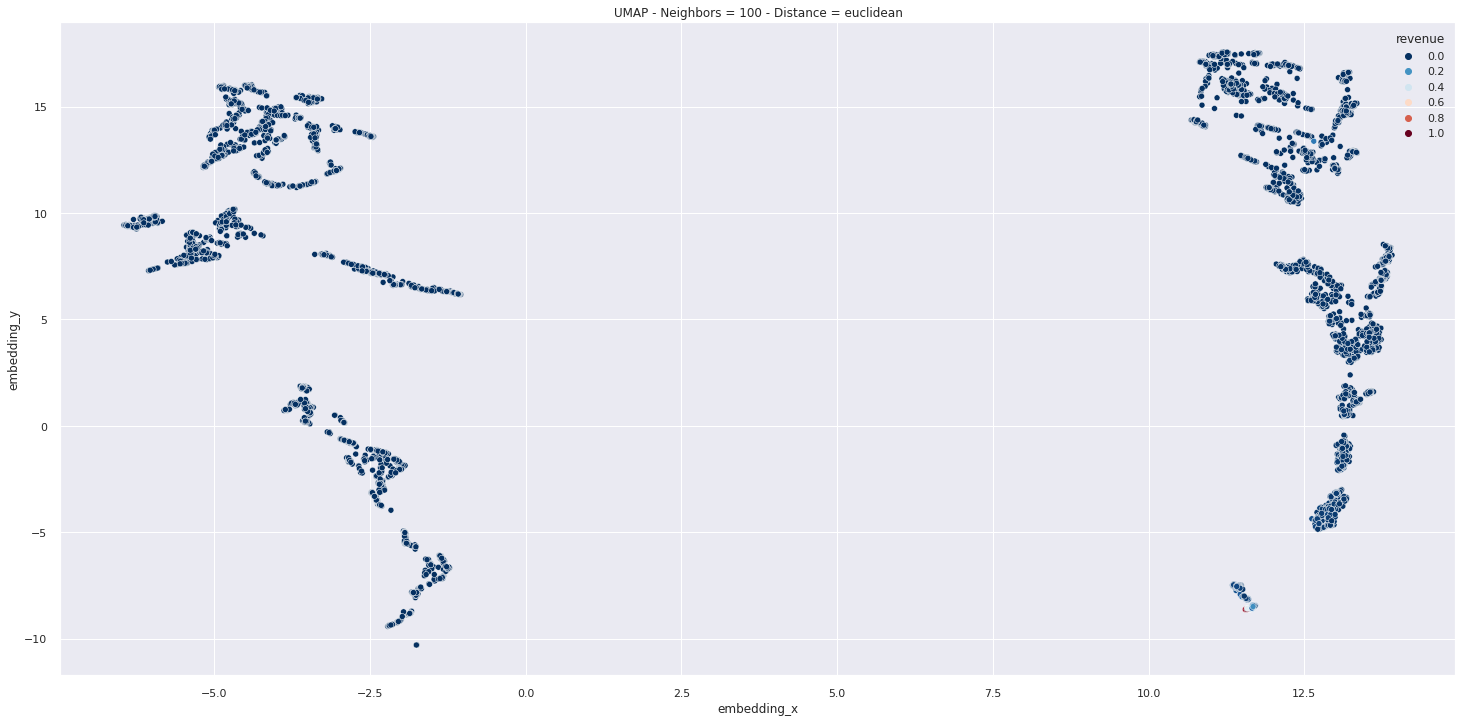

In [17]:
# Euclidean Distance 
n_neighbors = 100
umap = UMAP(n_neighbors = n_neighbors, random_state = 42, metric = 'euclidean')  
res_umap = umap.fit_transform(df_leaf)
metric = umap.metric

df_tree = df6.copy()
df_tree['embedding_x'] =  res_umap[:,0]
df_tree['embedding_y'] =  res_umap[:,1]

cmap = sns.color_palette('RdBu_r', as_cmap = True)
plt.title('UMAP - Neighbors = {} - Distance = {}'.format(n_neighbors, metric) )
sns.scatterplot( data = df_tree, x = 'embedding_x', y = 'embedding_y', hue = 'revenue', palette = cmap);

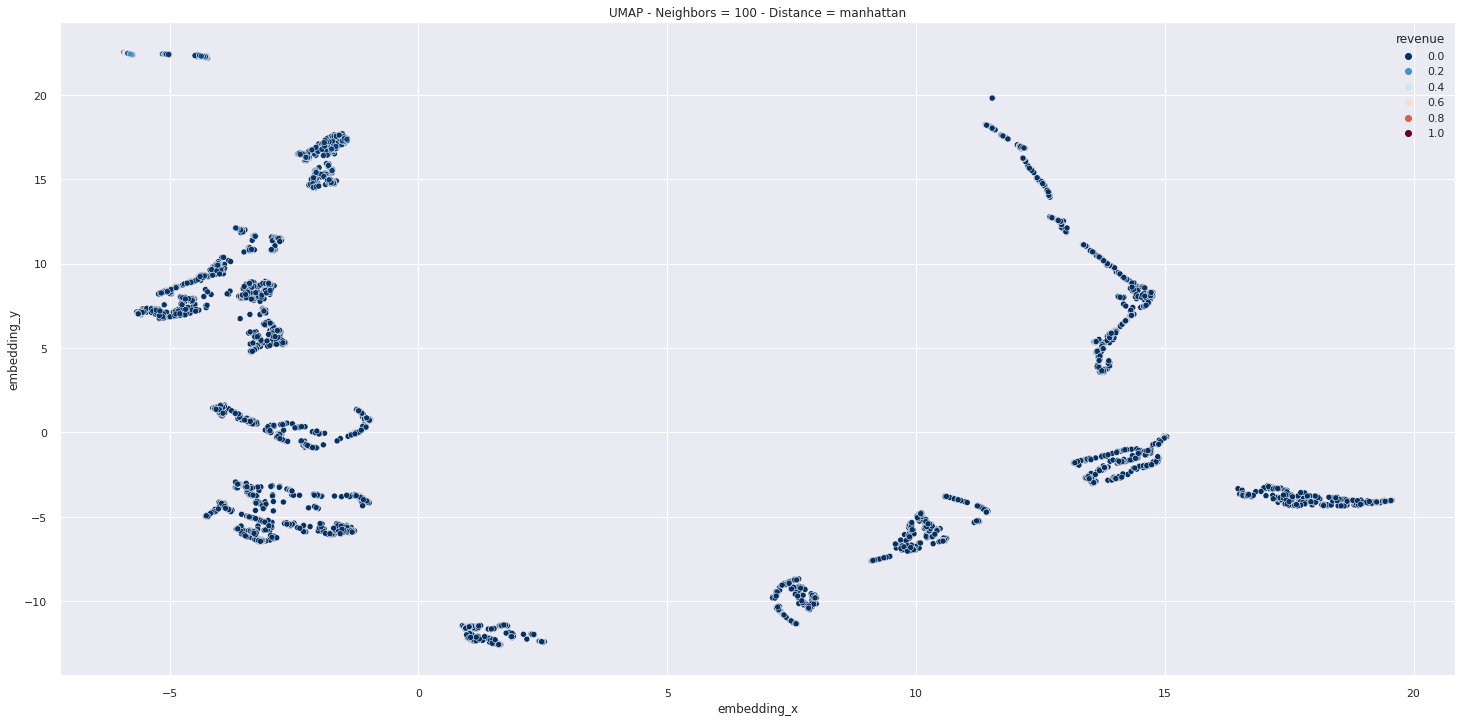

In [18]:
# Manhattan Distance 
n_neighbors = 100
umap = UMAP(n_neighbors = n_neighbors, random_state = 42, metric = 'manhattan')  
res_umap = umap.fit_transform(df_leaf)
metric = umap.metric

df_tree = df6.copy()
df_tree['embedding_x'] =  res_umap[:,0]
df_tree['embedding_y'] =  res_umap[:,1]

cmap = sns.color_palette('RdBu_r', as_cmap = True)
plt.title('UMAP - Neighbors = {} - Distance = {}'.format(n_neighbors, metric) )
sns.scatterplot( data = df_tree, x = 'embedding_x', y = 'embedding_y', hue = 'revenue', palette = cmap);

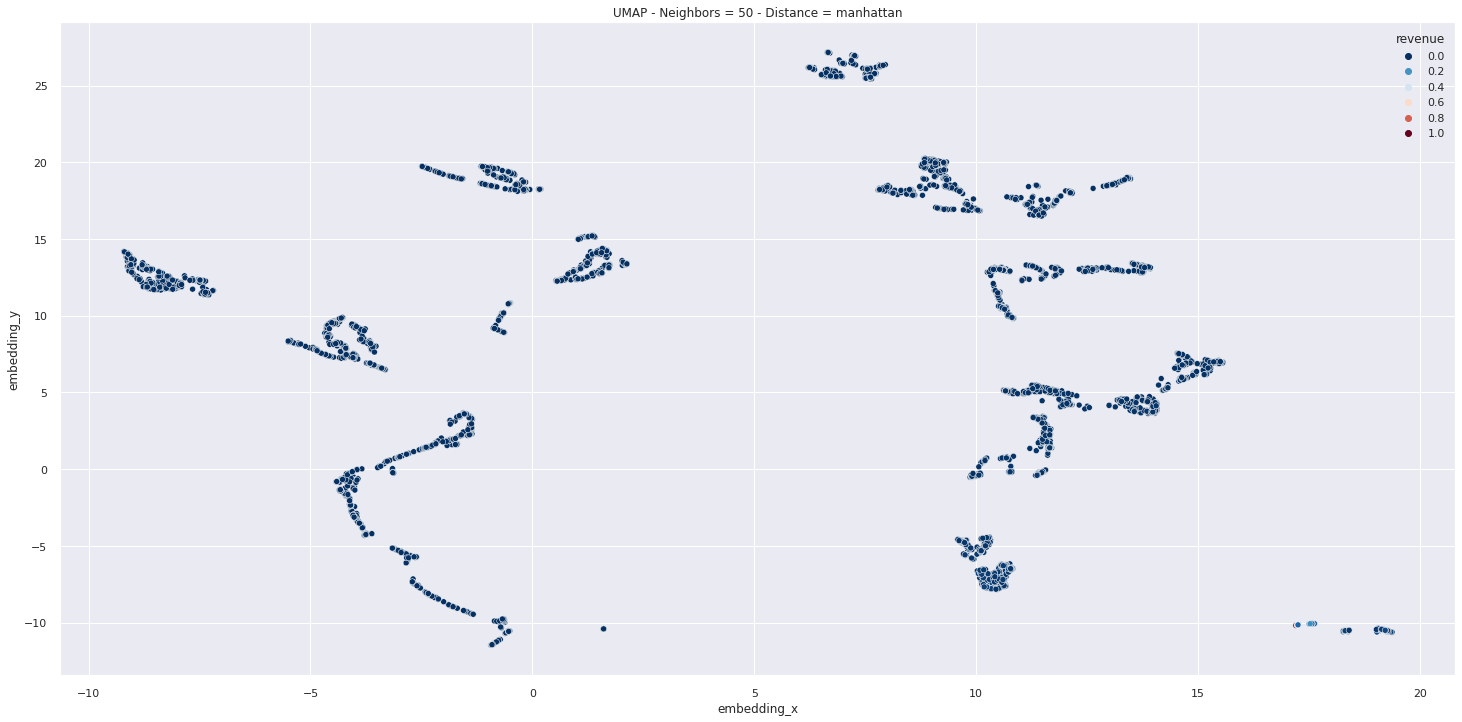

In [19]:
n_neighbors = 50
umap = UMAP(n_neighbors = n_neighbors, random_state = 42, metric = 'manhattan')  
res_umap = umap.fit_transform(df_leaf)
metric = umap.metric

df_tree = df6.copy()
df_tree['embedding_x'] =  res_umap[:,0]
df_tree['embedding_y'] =  res_umap[:,1]

cmap = sns.color_palette('RdBu_r', as_cmap = True)
plt.title('UMAP - Neighbors = {} - Distance = {}'.format(n_neighbors, metric) )
sns.scatterplot( data = df_tree, x = 'embedding_x', y = 'embedding_y', hue = 'revenue', palette = cmap);

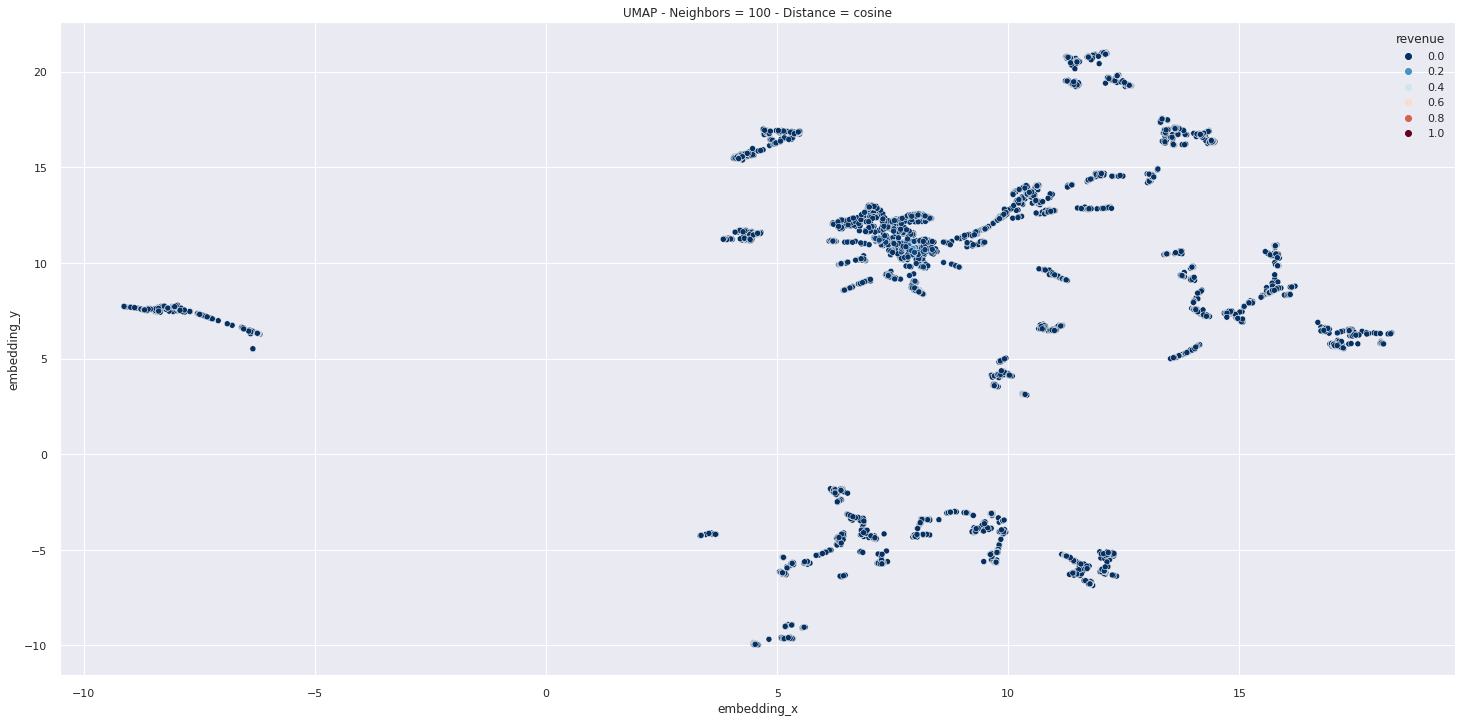

In [108]:
n_neighbors = 100
umap = UMAP(n_neighbors = n_neighbors, random_state = 42, metric = 'cosine')  
res_umap = umap.fit_transform(df_leaf)
metric = umap.metric

df_tree = df6.copy()
df_tree['embedding_x'] =  res_umap[:,0]
df_tree['embedding_y'] =  res_umap[:,1]

cmap = sns.color_palette('RdBu_r', as_cmap = True)
plt.title('UMAP - Neighbors = {} - Distance = {}'.format(n_neighbors, metric) )
sns.scatterplot( data = df_tree, x = 'embedding_x', y = 'embedding_y', hue = 'revenue', palette = cmap);

### 6.2.2 Space with less features

In [154]:
# cols_selected = ['qty_items','avg_ticket','num_returns','returns_revenue','avg_unique_prods','qty_returned','num_purchases','recency','frequency']# defining independent and dependent variable
cols_selected = ['recency',
                 'num_purchases',
                 'avg_ticket',
                 'frequency',
                 'revenue',
                 'qty_items',
                 'returns_revenue',
                 'qty_returned']

X = df5[cols_selected].drop(['revenue'], axis = 1).copy()
y = df5['revenue']

rf = RandomForestRegressor(random_state = 42, min_samples_split = 10) 
rf.fit(X, y)

# get leafs for each observation
df_leaf = pd.DataFrame( rf.apply(X) )

In [155]:
# Feature importance
sorted( list(zip(rf.feature_importances_, rf.feature_names_in_)), reverse = True )

[(0.9589475988313737, 'qty_items'),
 (0.019725297900651317, 'avg_ticket'),
 (0.00592589765997691, 'returns_revenue'),
 (0.00516721090138476, 'qty_returned'),
 (0.004285281452449522, 'num_purchases'),
 (0.004199579770241277, 'frequency'),
 (0.001749133483922551, 'recency')]

In [156]:
df_leaf.head()

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48   49   50   51   52   53   54   55   56   57   58   59   60   61   62   63   64   65   66   67   68   69   70   71   72   73   74   75   76   77   78   79   80   81   82   83   84   85   86   87   88   89   90   91   92   93   94   95   96   97   98   99
0  788  807  810  831  848  845  792  803  837  903  878  737  864  854  815  847  814  830  806  850  847  824  854  834  769  835  766  886  813  745  838  834  894  878  814  834  825  844  845  803  858  864  819  878  859  822  832  868  805  782  806  824  843  804  804  855  824  817  848  798  840  865  836  813  882  875  859  851  879  838  810  828  831  814  878  795  838  811  816  871  807  822  853  838  865  850  832  827  808  835  830  859  868  856  882  799  796  824  866  869
1  800  811  756  833  751  859  746  801  847  819  794  734  760  784  805  747  773  738  830  777  767  818  776  838  759  740  751  778  790  734  802  770  807  796  754  780  764  773  771  803  788  780  808  792  807  772  825  687  812  756  748  810  778  808  800  850  781  768  763  824  752  782  769  800  788  790  790  728  809  775  826  833  775  811  800  770  762  822  732  790  797  806  782  826  771  762  826  831  806  792  828  841  803  786  768  795  807  744  797  761
2  880  896  882  923  920  935  896  895  934  930  896  896  929  927  901  894  894  873  926  930  896  893  880  916  934  890  912  925  893  909  936  916  922  900  871  907  902  905  870  931  880  935  909  931  935  897  904  890  893  921  904  913  889  874  878  931  928  840  906  919  898  895  914  912  905  927  907  891  897  893  909  918  912  904  907  893  906  903  917  894  900  912  914  927  915  863  917  928  893  893  926  932  934  909  915  906  904  889  915  923
3  460  650  602  594  565  511  570  493  606  587  554  562  583  585  568  562  566  585  517  513  615  599  545  583  592  610  494  655  486  518  624  526  643  633  507  586  639  561  544  578  608  611  575  578  589  576  527  643  565  609  568  652  563  543  555  513  529  475  592  636  607  636  561  589  540  525  580  577  567  463  601  587  615  605  643  516  602  571  568  582  618  567  607  580  562  549  581  554  575  572  534  513  544  539  556  504  562  612  628  633
4  247  323  243  209  193  224  197  220  217  131  204  191  217  210  192  176  207  191  163  127  199  217  215  208  186  192  231  229  319  194  215  206  197  212  334  217  209  251  199  221  204  194  243  211  193  210  360  213  194  226  192  206  207  198  208  148  306  317  178  188  201  212  207  208  355  253  141  209  255  117  209  206  180  199  215  317  199  221  203  194  273  268  197  154  187  273  201  209  198  202  187  124  211  205  175  253  192  196  206  210

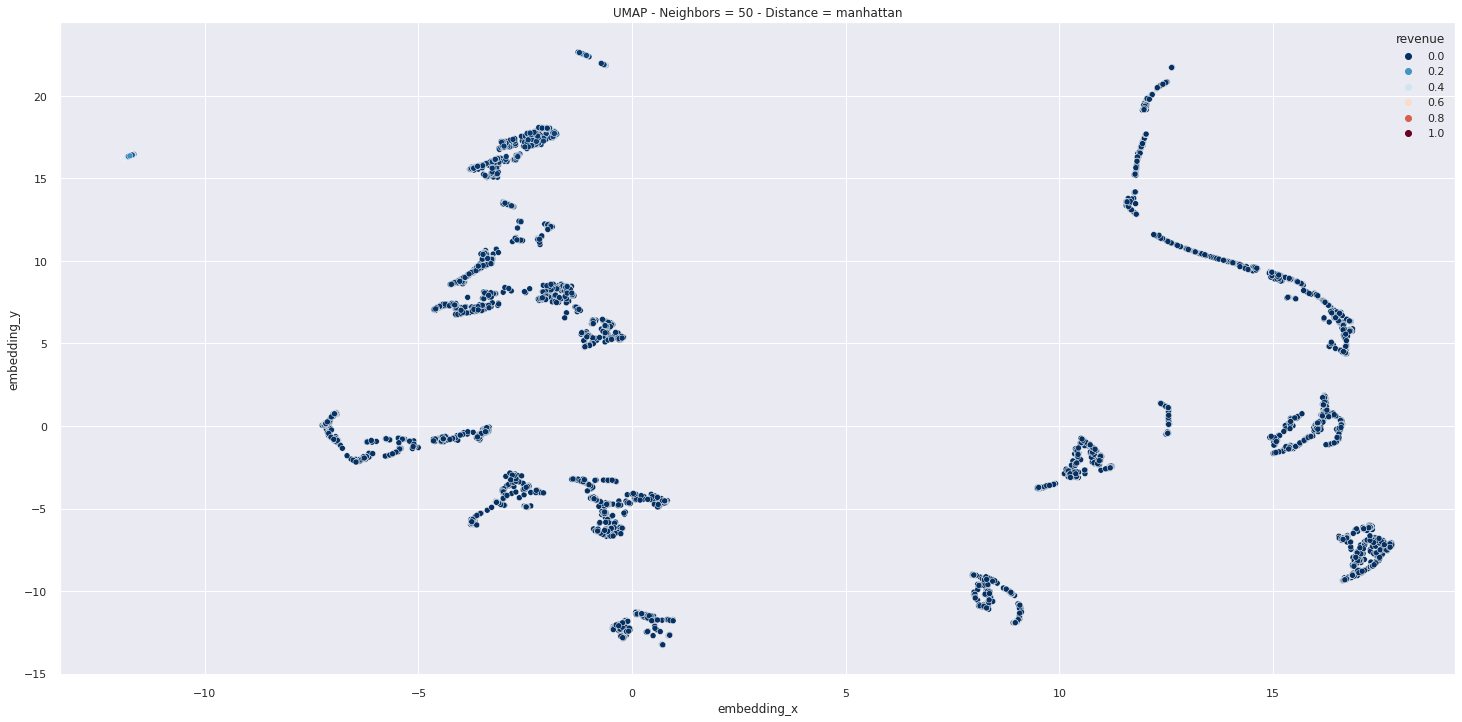

In [158]:
# Manhattan Distance 
n_neighbors = 50
umap = UMAP(n_neighbors = n_neighbors, random_state = 42, metric = 'manhattan')  
res_umap = umap.fit_transform(df_leaf)
metric = umap.metric

df_tree = df7.copy()
df_tree['embedding_x'] =  res_umap[:,0]
df_tree['embedding_y'] =  res_umap[:,1]

cmap = sns.color_palette('RdBu_r', as_cmap = True)
plt.title('UMAP - Neighbors = {} - Distance = {}'.format(n_neighbors, metric) )
sns.scatterplot( data = df_tree, x = 'embedding_x', y = 'embedding_y', hue = 'revenue', palette = cmap);

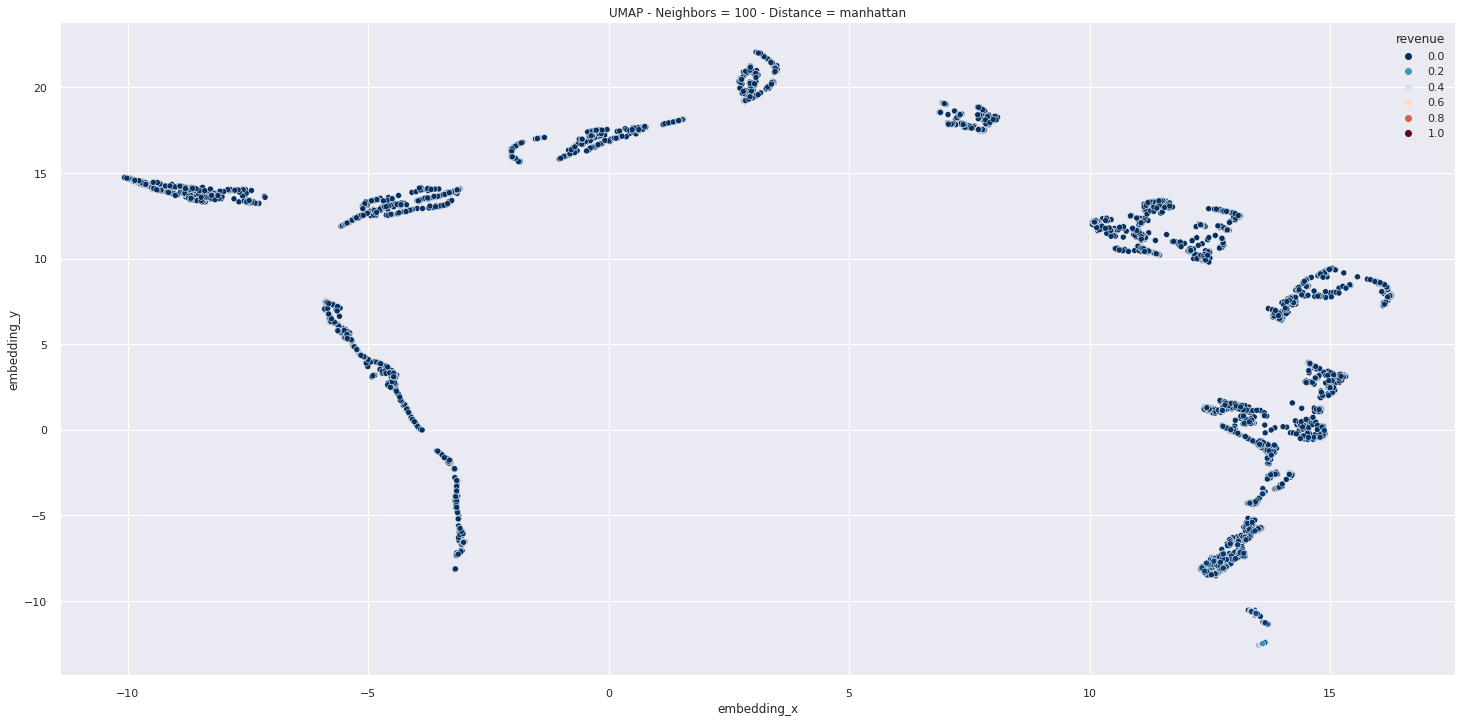

In [159]:
# Manhattan Distance 
n_neighbors = 100
umap = UMAP(n_neighbors = n_neighbors, random_state = 42, metric = 'manhattan')  
res_umap = umap.fit_transform(df_leaf)
metric = umap.metric

df_tree = df7.copy()
df_tree['embedding_x'] =  res_umap[:,0]
df_tree['embedding_y'] =  res_umap[:,1]

cmap = sns.color_palette('RdBu_r', as_cmap = True)
plt.title('UMAP - Neighbors = {} - Distance = {}'.format(n_neighbors, metric) )
sns.scatterplot( data = df_tree, x = 'embedding_x', y = 'embedding_y', hue = 'revenue', palette = cmap);

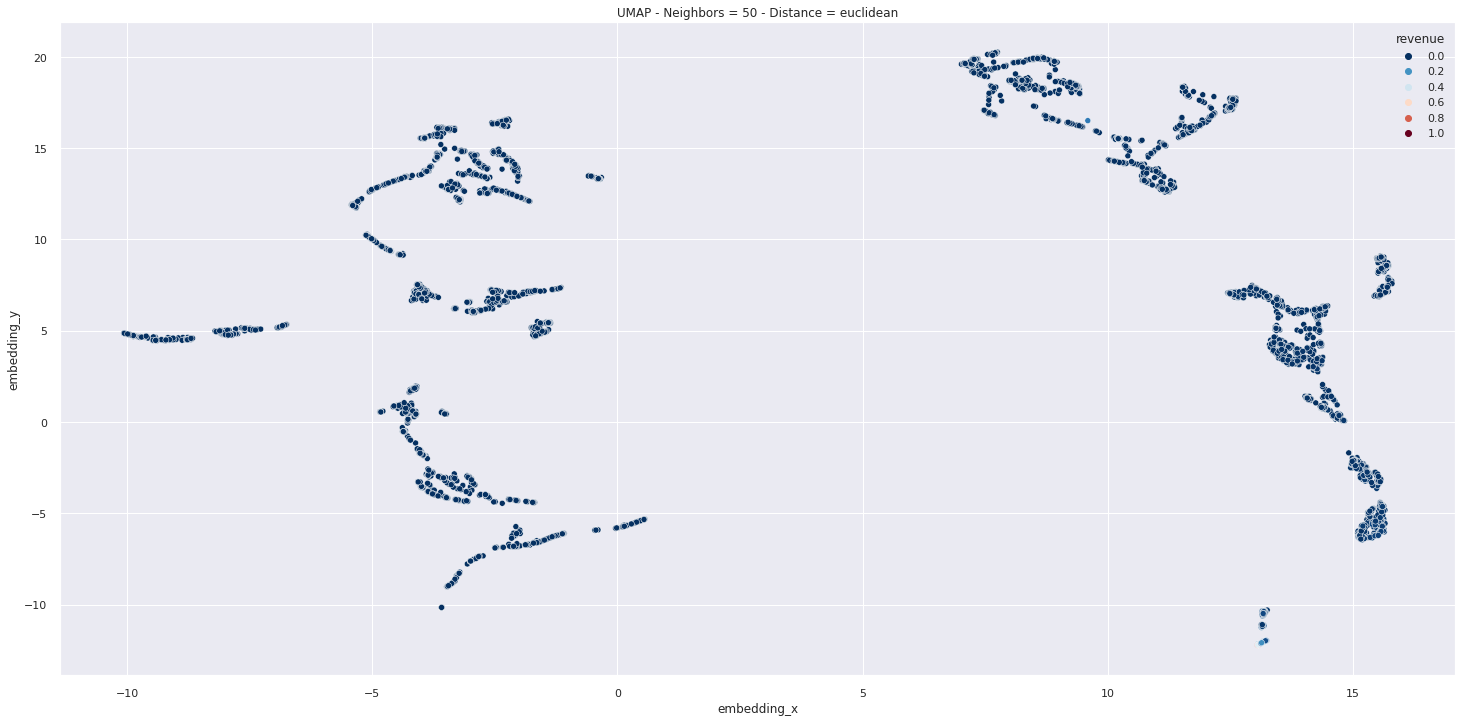

In [161]:
# Cosine Distance 
n_neighbors = 50
umap = UMAP(n_neighbors = n_neighbors, random_state = 42, metric = 'euclidean')  
res_umap = umap.fit_transform(df_leaf)
metric = umap.metric
metric = umap.metric

df_tree = df7.copy()
df_tree['embedding_x'] =  res_umap[:,0]
df_tree['embedding_y'] =  res_umap[:,1]

cmap = sns.color_palette('RdBu_r', as_cmap = True)
plt.title('UMAP - Neighbors = {} - Distance = {}'.format(n_neighbors, metric) )
sns.scatterplot( data = df_tree, x = 'embedding_x', y = 'embedding_y', hue = 'revenue', palette = cmap);

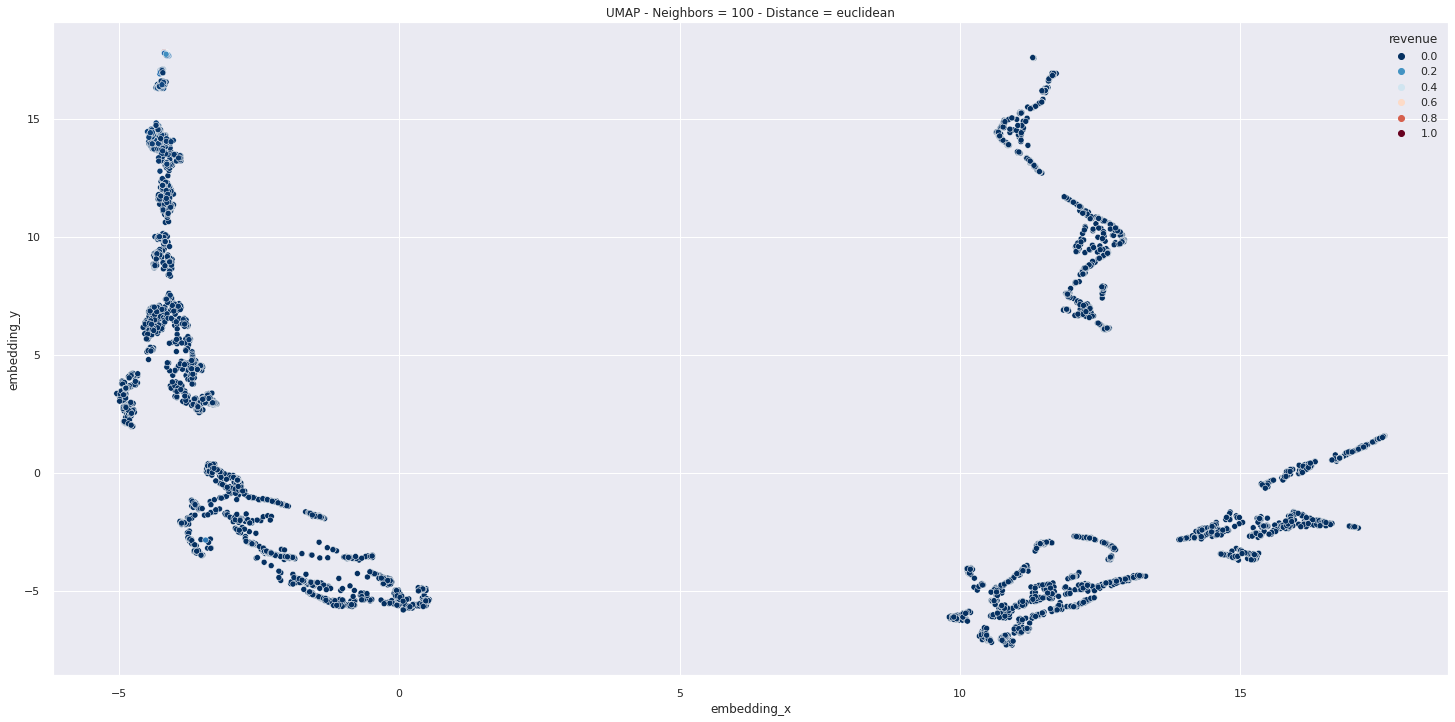

In [162]:
n_neighbors = 100
umap = UMAP(n_neighbors = n_neighbors, random_state = 42, metric = 'euclidean')  
res_umap = umap.fit_transform(df_leaf)
metric = umap.metric
metric = umap.metric

df_tree = df7.copy()
df_tree['embedding_x'] =  res_umap[:,0]
df_tree['embedding_y'] =  res_umap[:,1]

cmap = sns.color_palette('RdBu_r', as_cmap = True)
plt.title('UMAP - Neighbors = {} - Distance = {}'.format(n_neighbors, metric) )
sns.scatterplot( data = df_tree, x = 'embedding_x', y = 'embedding_y', hue = 'revenue', palette = cmap);

### 6.2.3 Space with less features and min_sample_split = 20

In [181]:
# cols_selected = ['qty_items','avg_ticket','num_returns','returns_revenue','avg_unique_prods','qty_returned','num_purchases','recency','frequency']# defining independent and dependent variable
cols_selected = ['recency',
                 'num_purchases',
                 'frequency',
                 'revenue',
                 'qty_items',
                 'returns_revenue',
                 'qty_returned']

X = df7[cols_selected].drop(['revenue'], axis = 1).copy()
y = df7['revenue']

rf = RandomForestRegressor(random_state = 42, min_samples_split = 20) 
rf.fit(X, y)

# get leafs for each observation
df_leaf = pd.DataFrame( rf.apply(X) )

In [182]:
df_leaf.head()

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48   49   50   51   52   53   54   55   56   57   58   59   60   61   62   63   64   65   66   67   68   69   70   71   72   73   74   75   76   77   78   79   80   81   82   83   84   85   86   87   88   89   90   91   92   93   94   95   96   97   98   99
0  571  608  595  611  526  563  570  542  585  625  581  502  584  602  579  623  543  579  547  593  591  571  606  557  527  579  538  626  556  523  549  639  625  613  577  561  558  617  613  554  609  585  581  593  610  554  622  600  612  552  609  594  616  585  606  607  585  563  591  578  614  606  612  573  606  603  600  612  559  599  615  560  547  553  601  615  620  603  585  645  582  566  627  560  616  609  579  613  565  576  562  582  587  628  601  584  582  583  584  639
1  559  600  569  605  518  558  558  542  585  569  521  501  529  560  565  526  499  519  541  545  539  569  565  550  522  519  530  558  511  517  524  603  568  562  533  519  516  555  567  554  577  545  566  529  573  512  617  480  594  543  566  569  566  576  603  596  563  498  538  564  554  566  571  565  552  540  522  557  514  551  604  552  513  535  541  592  571  599  548  573  569  522  576  504  562  552  541  568  552  544  556  568  562  577  536  575  582  535  553  539
2  620  657  643  666  622  610  640  612  628  641  590  575  619  624  621  667  589  605  607  641  617  616  621  591  625  619  634  659  589  615  611  681  641  627  616  603  616  668  628  627  615  623  628  626  651  591  663  629  661  634  659  659  647  624  653  643  637  595  619  642  646  619  677  615  620  636  639  636  570  620  665  601  579  604  617  691  663  656  642  659  641  623  669  616  647  618  622  645  629  615  612  633  644  657  608  667  654  615  620  660
3  352  489  469  427  374  364  424  374  444  428  390  396  390  386  405  474  387  429  367  396  414  400  431  388  419  422  374  482  343  373  403  431  462  450  355  379  449  418  438  424  450  425  435  391  436  410  407  451  417  436  456  358  412  410  425  370  379  353  407  439  475  472  439  416  400  372  401  417  386  376  444  415  406  398  439  399  460  427  421  461  448  422  467  390  420  379  441  460  400  416  387  381  400  400  390  376  424  452  440  473
4   66  117  108   94   76   94   95  113  142  104  121   86  124   48   88  104   53   66   71  108   79   90   43   46   44   35   78   49   92   76   50   42   37  106  116   68   42   77  126   40   73   87   95   91   83   40   78   80   72   70   38  128   47   63   58   34   96   90   83  138   62  110   94   87   84   38  102  117   36   85   54   84   85   76   70   39   80  104  106   90   95   41  107   40   88  105  101   92   77  101   97  117   94   94   59   83   90   84   38  102

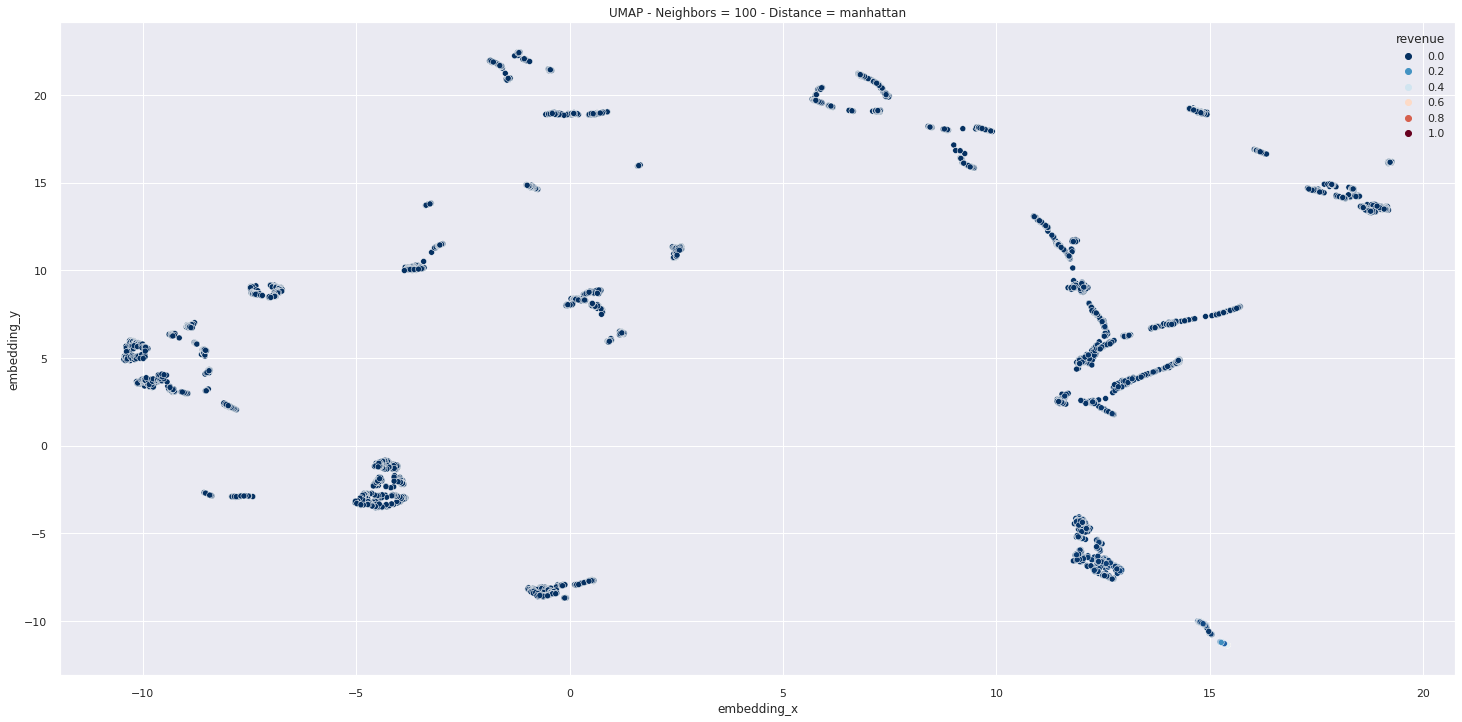

In [183]:
# Manhattan Distance 
n_neighbors = 100
umap = UMAP(n_neighbors = n_neighbors, random_state = 42, metric = 'manhattan')  
res_umap = umap.fit_transform(df_leaf)
metric = umap.metric

df_tree = df7.copy()
df_tree['embedding_x'] =  res_umap[:,0]
df_tree['embedding_y'] =  res_umap[:,1]

cmap = sns.color_palette('RdBu_r', as_cmap = True)
plt.title('UMAP - Neighbors = {} - Distance = {}'.format(n_neighbors, metric) )
sns.scatterplot( data = df_tree, x = 'embedding_x', y = 'embedding_y', hue = 'revenue', palette = cmap);

In [176]:
# cols_selected = ['qty_items','avg_ticket','num_returns','returns_revenue','avg_unique_prods','qty_returned','num_purchases','recency','frequency']# defining independent and dependent variable
cols_selected = ['recency',
                 'num_purchases',
                 'frequency',
                 'revenue',
                 'qty_items',
                 'returns_revenue',
                 'qty_returned']

X = df5[cols_selected].drop(['revenue'], axis = 1).copy()
y = df5['revenue']

rf = RandomForestRegressor(random_state = 42, min_samples_split = 20) 
rf.fit(X, y)

# get leafs for each observation
df_leaf2 = pd.DataFrame( rf.apply(X) )

In [177]:
df_leaf2.head()

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48   49   50   51   52   53   54   55   56   57   58   59   60   61   62   63   64   65   66   67   68   69   70   71   72   73   74   75   76   77   78   79   80   81   82   83   84   85   86   87   88   89   90   91   92   93   94   95   96   97   98   99
0  571  608  595  611  526  563  570  542  585  625  581  502  584  605  579  623  543  579  547  593  591  571  606  557  527  579  538  626  556  523  549  639  625  613  577  561  558  617  613  554  609  585  581  593  610  554  622  600  612  552  609  594  616  585  606  607  585  563  591  578  614  606  612  573  606  603  600  612  559  599  615  560  547  553  601  615  620  603  585  645  582  566  627  560  616  609  579  613  565  576  562  582  587  628  601  584  582  585  584  637
1  559  600  569  605  518  558  558  542  585  569  521  501  529  560  565  526  499  519  541  545  539  569  565  550  522  519  530  558  511  517  524  603  568  562  533  519  516  555  567  554  577  545  566  529  573  512  617  480  594  543  566  569  566  576  603  596  563  498  538  564  554  566  571  565  552  540  522  557  514  551  604  552  513  535  541  592  571  599  548  573  569  522  576  504  562  552  541  568  552  544  556  568  562  577  536  575  582  535  553  539
2  620  657  643  666  622  610  640  612  628  641  590  575  619  624  621  667  589  605  607  641  617  616  621  591  625  619  634  660  589  615  611  681  641  627  616  603  616  667  628  627  615  623  628  626  651  591  663  629  661  634  659  659  647  624  653  643  637  595  619  642  646  619  677  615  620  636  639  636  570  620  665  600  579  604  617  690  663  656  642  659  641  623  669  616  647  618  622  645  629  615  612  633  644  657  608  666  654  615  620  660
3  352  489  469  427  374  364  424  374  444  428  390  396  390  386  405  474  387  429  367  396  414  400  431  388  419  422  374  482  343  373  403  431  462  450  355  379  449  418  438  424  450  425  435  391  436  410  407  451  417  436  456  358  412  410  425  370  379  353  407  439  475  472  439  416  400  372  401  417  386  376  444  415  406  398  439  399  460  427  421  461  448  422  467  390  420  379  441  460  400  416  387  381  400  400  390  376  424  452  440  473
4   66  117  108   94   76   94   95  113  142  104  121   86  124   48   88  104   53   66   71  108   79   90   43   46   44   35   78   49   92   76   50   42   37  106  116   68   42   77  126   40   73   87   95   91   83   40   78   80   72   70   38  113   47   63   58   34   96   90   83  138   62  110   94   87   83   38  102  117   36   85   54   84   85   76   70   39   80  104  106   97   95   41  107   40   88  105  101   92   77  101   97  117   94   94   59   83   90   84   38  102

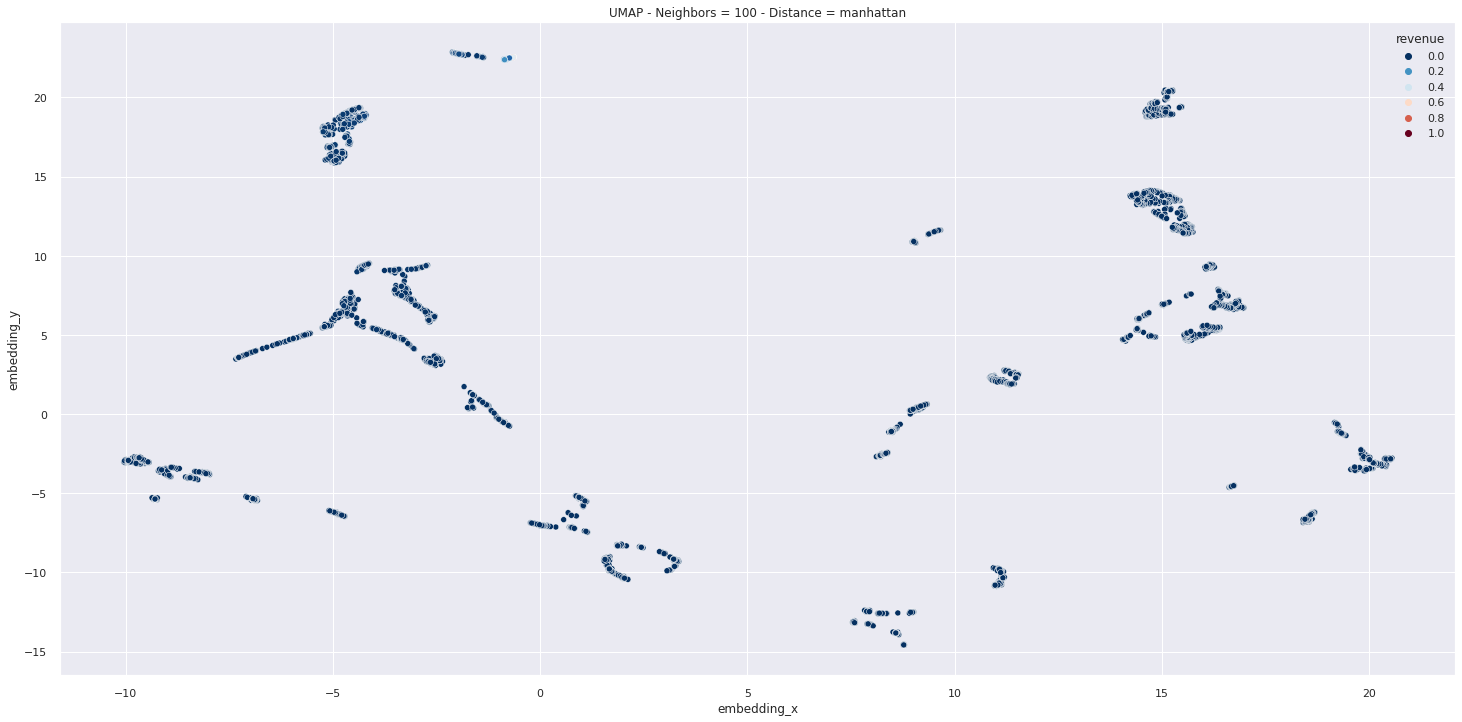

In [180]:
# Manhattan Distance 
n_neighbors = 100
umap = UMAP(n_neighbors = n_neighbors, random_state = 42, metric = 'manhattan')  
res_umap = umap.fit_transform(df_leaf)
metric = umap.metric

df_tree = df7.copy()
df_tree['embedding_x'] =  res_umap[:,0]
df_tree['embedding_y'] =  res_umap[:,1]

cmap = sns.color_palette('RdBu_r', as_cmap = True)
plt.title('UMAP - Neighbors = {} - Distance = {}'.format(n_neighbors, metric) )
sns.scatterplot( data = df_tree, x = 'embedding_x', y = 'embedding_y', hue = 'revenue', palette = cmap);

## 6.3 Selected Embedding Space

In [134]:
df4.reset_index(inplace = True, drop = True)
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4314 entries, 0 to 4313
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            4314 non-null   int64  
 1   country                4314 non-null   object 
 2   recency                4314 non-null   int64  
 3   avg_days_bw_purchases  4314 non-null   float64
 4   num_purchases          4314 non-null   int64  
 5   date_range             4314 non-null   int64  
 6   frequency              4314 non-null   float64
 7   revenue                4314 non-null   float64
 8   avg_ticket             4314 non-null   float64
 9   qty_items              4314 non-null   int64  
 10  avg_basket_size        4314 non-null   float64
 11  avg_unique_prods       4314 non-null   float64
 12  returns_revenue        4314 non-null   float64
 13  avg_return_revenue     4314 non-null   float64
 14  num_returns            4314 non-null   float64
 15  qty_

In [46]:
df4.iloc[4,8]

211.70000000000002

In [47]:
df4.to_csv('./df4_test.csv', index = False)

In [48]:
df4_test = pd.read_csv('./df4_test.csv')
df4_test.iloc[4,8]

211.7

In [81]:
df4_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4314 entries, 0 to 4313
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            4314 non-null   int64  
 1   country                4314 non-null   object 
 2   recency                4314 non-null   int64  
 3   avg_days_bw_purchases  4314 non-null   float64
 4   num_purchases          4314 non-null   int64  
 5   date_range             4314 non-null   int64  
 6   frequency              4314 non-null   float64
 7   revenue                4314 non-null   float64
 8   avg_ticket             4314 non-null   float64
 9   qty_items              4314 non-null   int64  
 10  avg_basket_size        4314 non-null   float64
 11  avg_unique_prods       4314 non-null   float64
 12  returns_revenue        4314 non-null   float64
 13  avg_return_revenue     4314 non-null   float64
 14  num_returns            4314 non-null   float64
 15  qty_

In [49]:
df4_test.head() == df4.head()

customer_id  country  recency  avg_days_bw_purchases  num_purchases  date_range  frequency  revenue  avg_ticket  qty_items  avg_basket_size  avg_unique_prods  returns_revenue  avg_return_revenue  num_returns  qty_returned
0         True     True     True                   True           True        True       True     True        True       True             True              True             True                True         True          True
1         True     True     True                   True           True        True      False     True       False       True             True              True             True                True         True          True
2         True     True     True                   True           True        True      False     True        True       True             True             False             True                True         True          True
3         True     True     True                  False           True        True      False     True        True       True             True              True             True                True         True          True
4         True     True     True                   True           True        True       True     True       False       True             True              True            False                True         True          True

In [58]:
df4_test.iloc[1:4,6]

1    0.028391
2    0.040431
3    0.017986
Name: frequency, dtype: float64

In [142]:
# df4 da memoria
cols_selected = ['qty_items','avg_ticket','num_returns','returns_revenue','avg_unique_prods','qty_returned','num_purchases','recency','frequency']

# defining independent and dependent variable
X = df4[cols_selected].copy()
y = df4['revenue']

# defining random forest regresor for embedding
rf = RandomForestRegressor(random_state = 42, min_samples_split = 20) 
rf.fit(X, y)

# get leafs for each observation
df_leaf_sem_reset = pd.DataFrame( rf.apply(X) )

n_neighbors = 50
umap = UMAP(n_neighbors = n_neighbors, random_state = 42, metric = 'manhattan')  
res_umap_sem_reset = umap.fit_transform(df_leaf_sem_reset)


###########################
# começando de novo df4 do HD
cols_selected = ['qty_items','avg_ticket','num_returns','returns_revenue','avg_unique_prods','qty_returned','num_purchases','recency','frequency']

df4.to_csv('./df4_test.csv', index = False)
df4_test = pd.read_csv('./df4_test.csv')

# defining independent and dependent variable
X = df4_test[cols_selected].copy()
y = df4_test['revenue']

# defining random forest regresor for embedding
rf = RandomForestRegressor(random_state = 42, min_samples_split = 20) 
rf.fit(X, y)

df_leaf_hd = pd.DataFrame( rf.apply(X) )

n_neighbors = 50
umap = UMAP(n_neighbors = n_neighbors, random_state = 42, metric = 'manhattan')  
res_umap_hd = umap.fit_transform(df_leaf_hd)

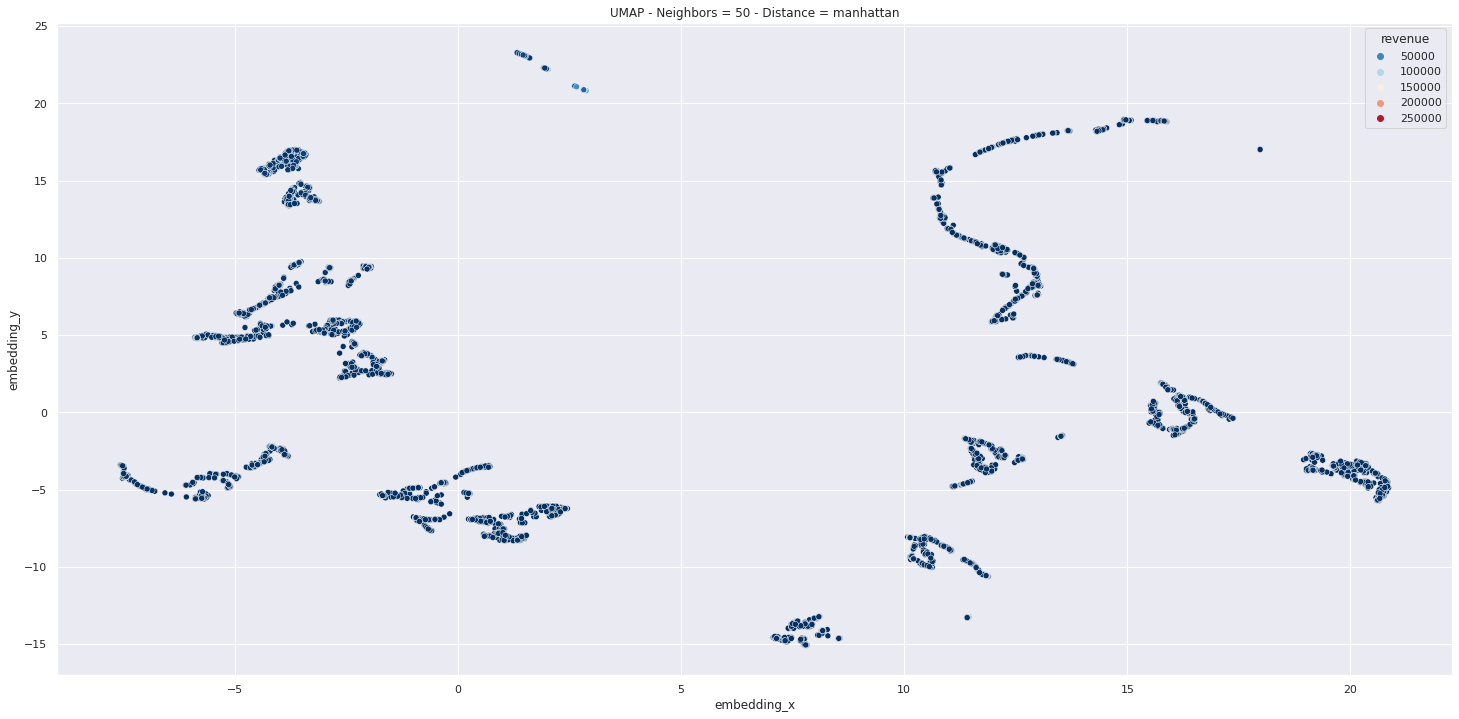

In [143]:
df_tree = df4.copy()
df_tree['embedding_x'] =  res_umap_sem_reset[:,0]
df_tree['embedding_y'] =  res_umap_sem_reset[:,1]
metric = umap.metric

# ploting results
cmap = sns.color_palette('RdBu_r', as_cmap = True)
plt.title('UMAP - Neighbors = {} - Distance = {}'.format(n_neighbors, metric) )
sns.scatterplot( data = df_tree, x = 'embedding_x', y = 'embedding_y', hue = 'revenue', palette = cmap);

In [145]:
#reading from csv with precision

df_csv = pd.read_csv('./df4_test.csv', float_precision = 'round_trip')

# df4 da memoria
cols_selected = ['qty_items','avg_ticket','num_returns','returns_revenue','avg_unique_prods','qty_returned','num_purchases','recency','frequency']

# defining independent and dependent variable
X = df_csv[cols_selected].copy()
y = df_csv['revenue']

# defining random forest regresor for embedding
rf = RandomForestRegressor(random_state = 42, min_samples_split = 20) 
rf.fit(X, y)

# get leafs for each observation
df_leaf_precision = pd.DataFrame( rf.apply(X) )

n_neighbors = 50
umap = UMAP(n_neighbors = n_neighbors, random_state = 42, metric = 'manhattan')  
res_umap_sem_reset = umap.fit_transform(df_leaf_sem_reset)


0.028391167192429023

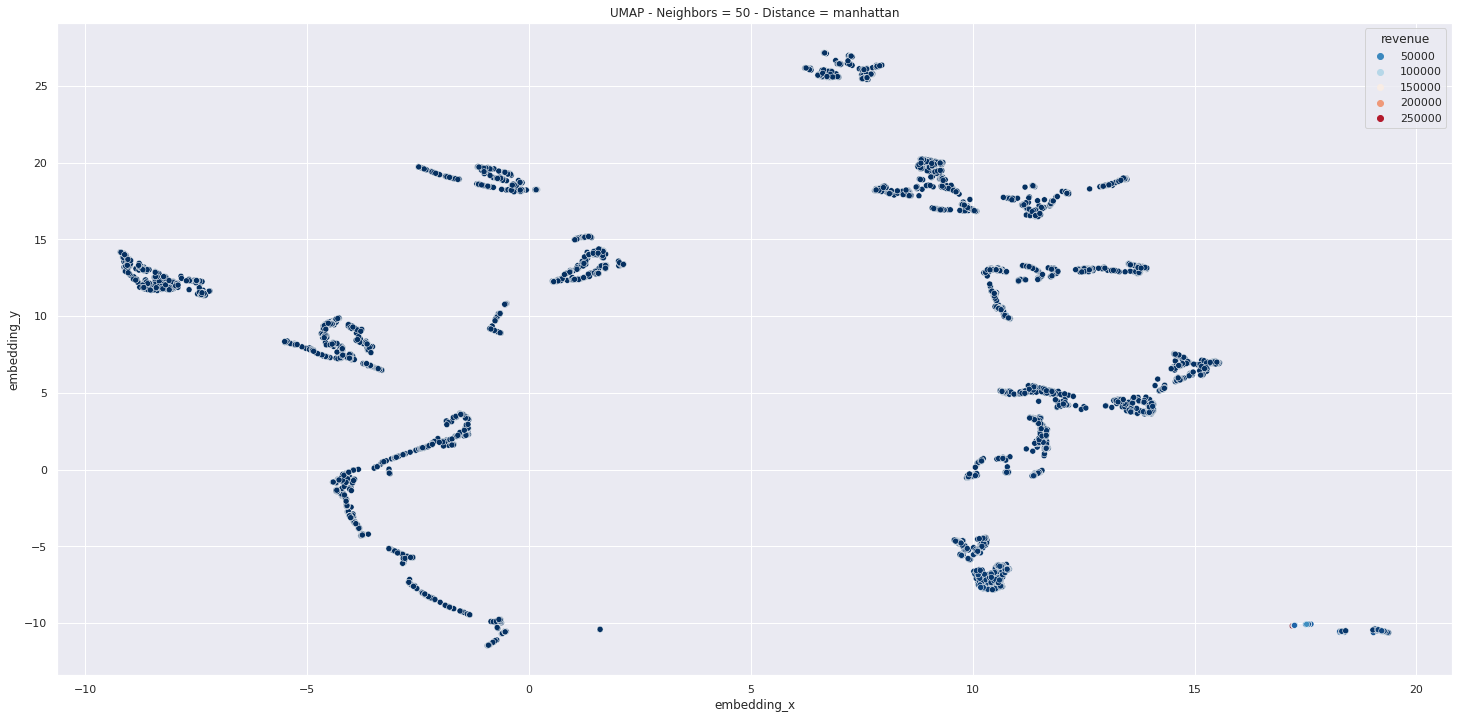

In [139]:
df_tree = df4_test.copy()
df_tree['embedding_x'] =  res_umap_hd[:,0]
df_tree['embedding_y'] =  res_umap_hd[:,1]
metric = umap.metric

# ploting results
cmap = sns.color_palette('RdBu_r', as_cmap = True)
plt.title('UMAP - Neighbors = {} - Distance = {}'.format(n_neighbors, metric) )
sns.scatterplot( data = df_tree, x = 'embedding_x', y = 'embedding_y', hue = 'revenue', palette = cmap);

In [61]:
# COM RESET INDEX
cols_selected = ['qty_items','avg_ticket','num_returns','returns_revenue','avg_unique_prods','qty_returned','num_purchases','recency','frequency']

# defining independent and dependent variable
X = df5[cols_selected].copy()
y = df5['revenue']

# defining random forest regresor for embedding
rf = RandomForestRegressor(random_state = 42, min_samples_split = 20) 
rf.fit(X, y)

# get leafs for each observation
df_leaf_com_reset = pd.DataFrame( rf.apply(X) )

n_neighbors = 50
umap = UMAP(n_neighbors = n_neighbors, random_state = 42, metric = 'manhattan')  
res_umap_com_reset = umap.fit_transform(df_leaf_com_reset)

In [69]:
# np.all(res_umap_set_reset == res_umap_hd)
res_umap_set_reset[:5]
res_umap_com_reset[:5]
res_umap_hd[:5]

array([[11.384928 , -0.3676688],
       [11.623067 ,  1.610966 ],
       [10.325433 , -7.799127 ],
       [10.479339 , 11.446996 ],
       [-7.344989 , 11.388304 ]], dtype=float32)

In [68]:
np.all(res_umap_com_reset == res_umap_set_reset)

True

In [75]:
df_precision = pd.read_csv('./df4_test.csv', float_precision='round_trip')
df_precision.iloc[4,8]

# COM RESET INDEX
cols_selected = ['qty_items','avg_ticket','num_returns','returns_revenue','avg_unique_prods','qty_returned','num_purchases','recency','frequency']

# defining independent and dependent variable
X = df_precision[cols_selected].copy()
y = df_precision['revenue']

# defining random forest regresor for embedding
rf = RandomForestRegressor(random_state = 42, min_samples_split = 20) 
rf.fit(X, y)

# get leafs for each observation
df_leaf_precision = pd.DataFrame( rf.apply(X) )

n_neighbors = 50
umap = UMAP(n_neighbors = n_neighbors, random_state = 42, metric = 'manhattan')  
res_umap_precision = umap.fit_transform(df_leaf_precision)

In [77]:
res_umap_precision[:5]
np.all(res_umap_precision == res_umap_com_reset)

True

In [152]:
res_umap_precision[:5]
res_umap_sem_reset[:5]

np.all(res_umap_sem_reset == res_umap_precision)


True

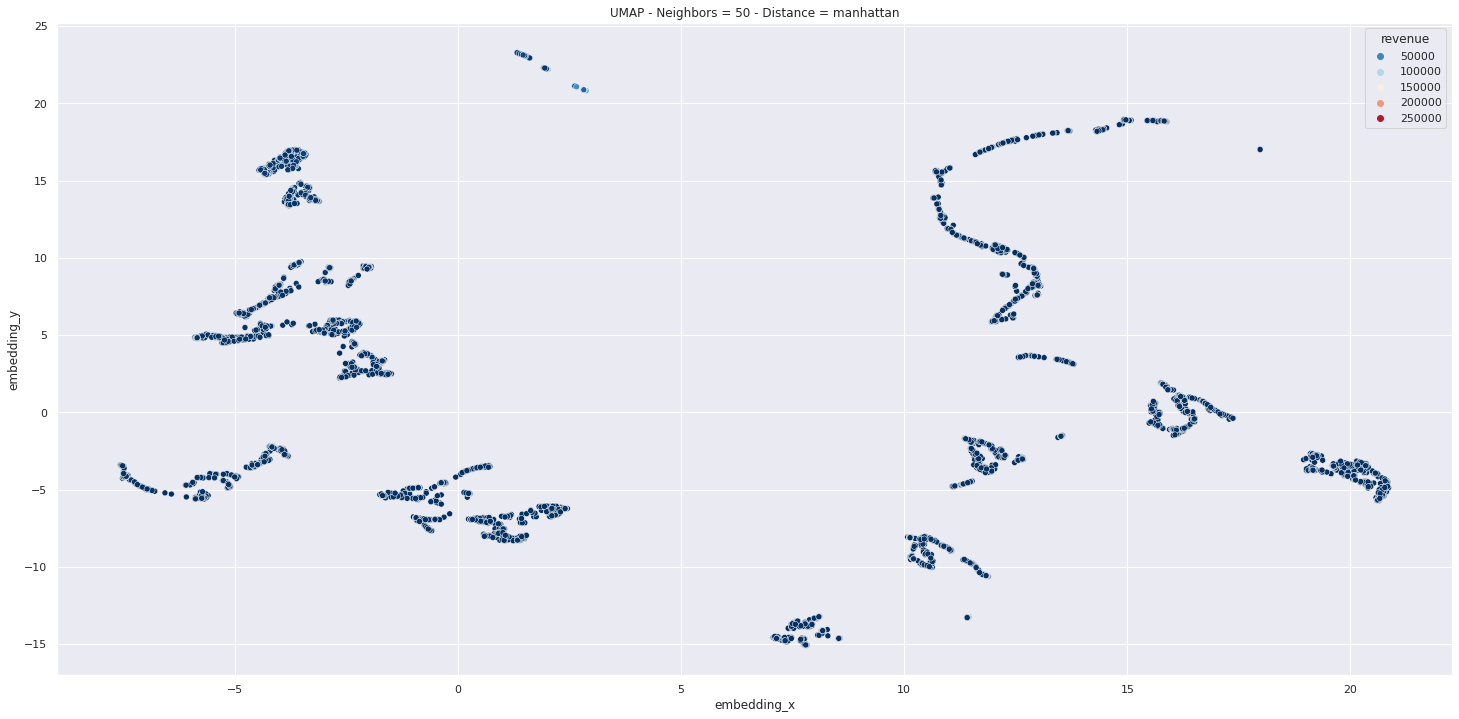

In [80]:
df_tree = df_precision.copy()
df_tree['embedding_x'] =  res_umap_precision[:,0]
df_tree['embedding_y'] =  res_umap_precision[:,1]
metric = umap.metric

# ploting results
cmap = sns.color_palette('RdBu_r', as_cmap = True)
plt.title('UMAP - Neighbors = {} - Distance = {}'.format(n_neighbors, metric) )
sns.scatterplot( data = df_tree, x = 'embedding_x', y = 'embedding_y', hue = 'revenue', palette = cmap);

In [96]:
# df5.avg_basket_size = df5.avg_basket_size.round()
df5_round = df5.round(6)
df5_round.iloc[4,8]

# df5.copy(float_precision = None )

211.7

In [97]:

# COM RESET INDEX
cols_selected = ['qty_items','avg_ticket','num_returns','returns_revenue','avg_unique_prods','qty_returned','num_purchases','recency','frequency']

# defining independent and dependent variable
X = df5_round[cols_selected].copy()
y = df5_round['revenue']

# defining random forest regresor for embedding
rf = RandomForestRegressor(random_state = 42, min_samples_split = 20) 
rf.fit(X, y)

# get leafs for each observation
df_leaf_round = pd.DataFrame( rf.apply(X) )

n_neighbors = 50
umap = UMAP(n_neighbors = n_neighbors, random_state = 42, metric = 'manhattan')  
res_umap_round = umap.fit_transform(df_leaf_round)

In [98]:
res_umap_round[:5]

array([[13.579046  , -0.54047424],
       [14.834789  ,  1.4942992 ],
       [ 9.431904  , -5.835226  ],
       [14.941818  , 12.414405  ],
       [-8.624617  , 12.773276  ]], dtype=float32)

In [99]:
res_umap_hd[:5]

array([[11.384928 , -0.3676688],
       [11.623067 ,  1.610966 ],
       [10.325433 , -7.799127 ],
       [10.479339 , 11.446996 ],
       [-7.344989 , 11.388304 ]], dtype=float32)

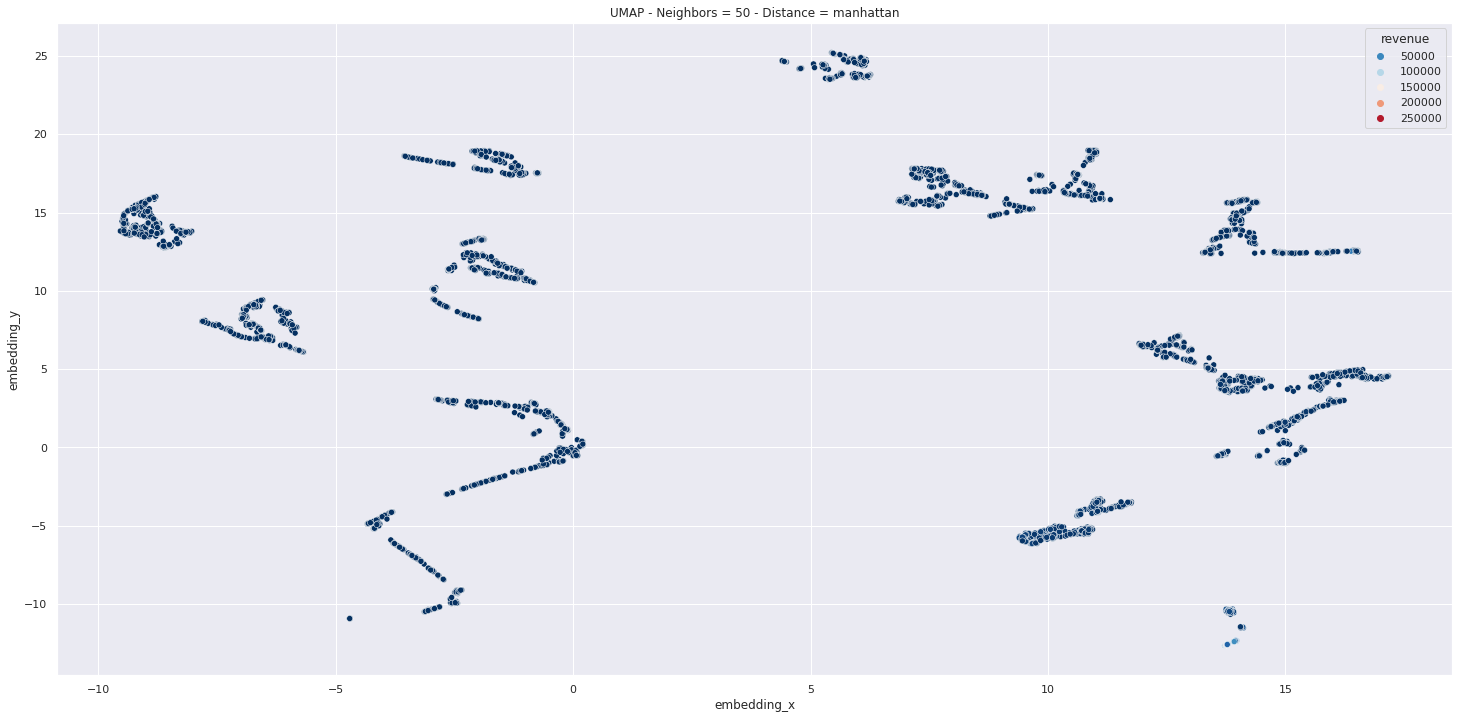

In [100]:
df_tree = df5_round.copy()
df_tree['embedding_x'] =  res_umap_round[:,0]
df_tree['embedding_y'] =  res_umap_round[:,1]
metric = umap.metric

# ploting results
cmap = sns.color_palette('RdBu_r', as_cmap = True)
plt.title('UMAP - Neighbors = {} - Distance = {}'.format(n_neighbors, metric) )
sns.scatterplot( data = df_tree, x = 'embedding_x', y = 'embedding_y', hue = 'revenue', palette = cmap);

In [105]:
df4_test = pd.read_csv('./df4_test.csv', float_precision=None)
df4_test.head()
df4_test.iloc[4,8]

211.7

In [113]:
df4.head() == df4_test.head()
df4.iloc[1,6]

0.028391167192429023

In [114]:
df4_test.head()
df4_test.iloc[1,6]

# 15 decimals

0.028391167192429

In [135]:
df_round2 = df4.round(15)
df_round2.head() == df4_test.head()

customer_id  country  recency  avg_days_bw_purchases  num_purchases  date_range  frequency  revenue  avg_ticket  qty_items  avg_basket_size  avg_unique_prods  returns_revenue  avg_return_revenue  num_returns  qty_returned
0         True     True     True                   True           True        True       True     True        True       True             True              True             True                True         True          True
1         True     True     True                   True           True        True       True     True       False       True             True              True             True                True         True          True
2         True     True     True                   True           True        True      False     True        True       True             True             False            False                True         True          True
3         True     True     True                  False           True        True      False     True        True       True             True              True             True                True         True          True
4         True     True     True                   True           True        True       True     True       False       True             True              True            False                True         True          True

In [128]:
df4_test.iloc[2,6]


0.0404312668463611

In [129]:
df_round2.iloc[2,6]

0.040431266846361

In [124]:
df4.head()
# df4.iloc[3,3]
# df4_test.iloc[3,3]
df4.iloc[1,6] == 
df_round2.iloc[1,6]


False

In [136]:
# COM RESET INDEX
cols_selected = ['qty_items','avg_ticket','num_returns','returns_revenue','avg_unique_prods','qty_returned','num_purchases','recency','frequency']

# defining independent and dependent variable
X = df_round2[cols_selected].copy()
y = df_round2['revenue']

# defining random forest regresor for embedding
rf = RandomForestRegressor(random_state = 42, min_samples_split = 20) 
rf.fit(X, y)

# get leafs for each observation
df_leaf_round2 = pd.DataFrame( rf.apply(X) )

n_neighbors = 50
umap = UMAP(n_neighbors = n_neighbors, random_state = 42, metric = 'manhattan')  
res_umap_round2 = umap.fit_transform(df_leaf_round2)

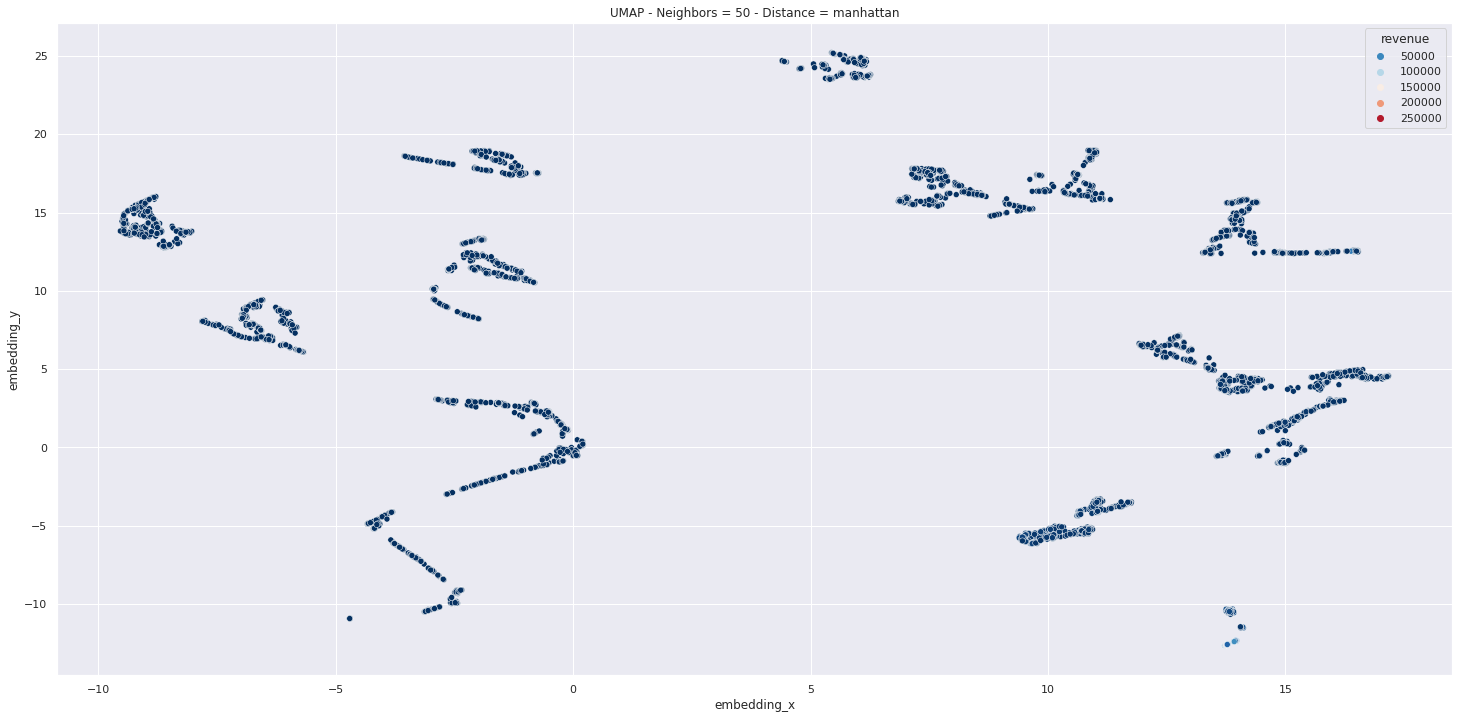

In [137]:
# ROUND 15
df_tree = df_round2.copy()
df_tree['embedding_x'] =  res_umap_round[:,0]
df_tree['embedding_y'] =  res_umap_round[:,1]
metric = umap.metric

# ploting results
cmap = sns.color_palette('RdBu_r', as_cmap = True)
plt.title('UMAP - Neighbors = {} - Distance = {}'.format(n_neighbors, metric) )
sns.scatterplot( data = df_tree, x = 'embedding_x', y = 'embedding_y', hue = 'revenue', palette = cmap);

In [275]:
a = np.array(df_leaf_hd)
b = np.array(df_leaf_sem_reset)

np.all( a == b)
# np.where( a!= b)
# a[20,95]
# b[4024,52]

False

In [259]:
# np.all( df4_reset['revenue'] == df4_test['revenue'] )
# df_leaf_hd.head() == df_leaf_sem_reset.head()
# df_leaf_sem_reset.head()
# df_leaf.head()

0     1     2     3     4     5     6     7     8     9     10    11    12    13    14    15    16    17    18    19    20    21    22    23    24    25    26    27    28    29    30    31    32    33    34    35    36    37    38    39    40    41    42    43    44    45    46    47    48    49    50    51    52    53    54    55    56    57    58    59    60    61    62    63    64    65    66    67    68    69    70    71    72    73    74    75    76    77    78    79    80    81    82    83    84    85    86    87    88    89    90    91    92    93    94    95    96    97    98    99
0  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
1  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
2  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
3  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True
4  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True

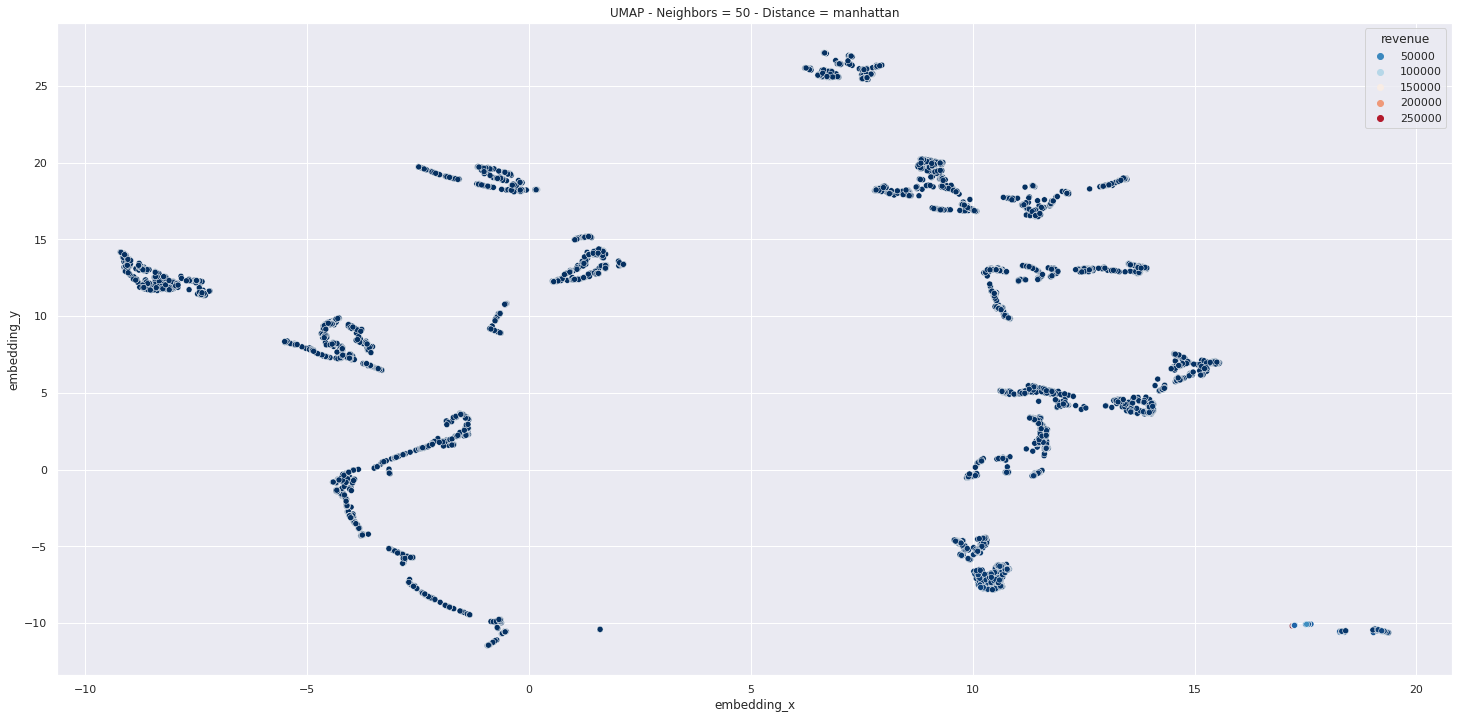

In [229]:
# começando de novo df4 do HD
cols_selected = ['qty_items','avg_ticket','num_returns','returns_revenue','avg_unique_prods','qty_returned','num_purchases','recency','frequency']

# defining independent and dependent variable
X = df4_test[cols_selected].copy()
y = df4_test['revenue']

# defining random forest regresor for embedding
rf = RandomForestRegressor(random_state = 42, min_samples_split = 20) 
rf.fit(X, y)

# get leafs for each observation
df_leaf = pd.DataFrame( rf.apply(X) )

# defining umap algorithm
n_neighbors = 50
umap = UMAP(n_neighbors = n_neighbors, random_state = 42, metric = 'manhattan')  
res_umap = umap.fit_transform(df_leaf)
metric = umap.metric

# storing embedding results on a dataframe
df_tree = df4_test.copy()
df_tree['embedding_x'] =  res_umap[:,0]
df_tree['embedding_y'] =  res_umap[:,1]

# ploting results
cmap = sns.color_palette('RdBu_r', as_cmap = True)
plt.title('UMAP - Neighbors = {} - Distance = {}'.format(n_neighbors, metric) )
sns.scatterplot( data = df_tree, x = 'embedding_x', y = 'embedding_y', hue = 'revenue', palette = cmap);

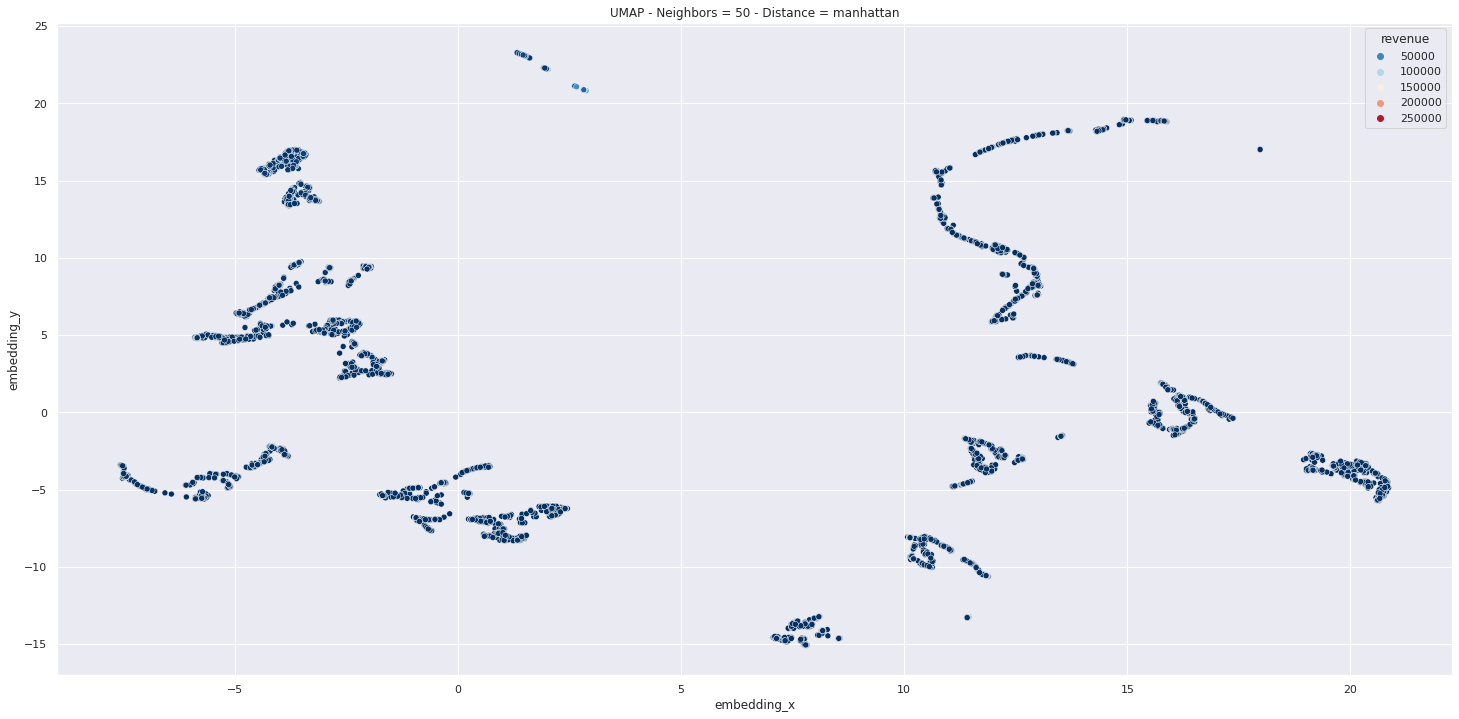

In [145]:
# começando de novo df4_reset com reset

df4_reset = df4.reset_index(drop = True)
cols_selected = ['qty_items','avg_ticket','num_returns','returns_revenue','avg_unique_prods','qty_returned','num_purchases','recency','frequency']

# defining independent and dependent variable
X = df4_reset[cols_selected].copy()
y = df4_reset['revenue']

# defining random forest regresor for embedding
rf = RandomForestRegressor(random_state = 42, min_samples_split = 20) 
rf.fit(X, y)

# get leafs for each observation
df_leaf = pd.DataFrame( rf.apply(X) )

# defining umap algorithm
n_neighbors = 50
umap = UMAP(n_neighbors = n_neighbors, random_state = 42, metric = 'manhattan')  
res_umap = umap.fit_transform(df_leaf)
metric = umap.metric

# storing embedding results on a dataframe
df_tree = df4_reset.copy()
df_tree['embedding_x'] =  res_umap[:,0]
df_tree['embedding_y'] =  res_umap[:,1]

# ploting results
cmap = sns.color_palette('RdBu_r', as_cmap = True)
plt.title('UMAP - Neighbors = {} - Distance = {}'.format(n_neighbors, metric) )
sns.scatterplot( data = df_tree, x = 'embedding_x', y = 'embedding_y', hue = 'revenue', palette = cmap);

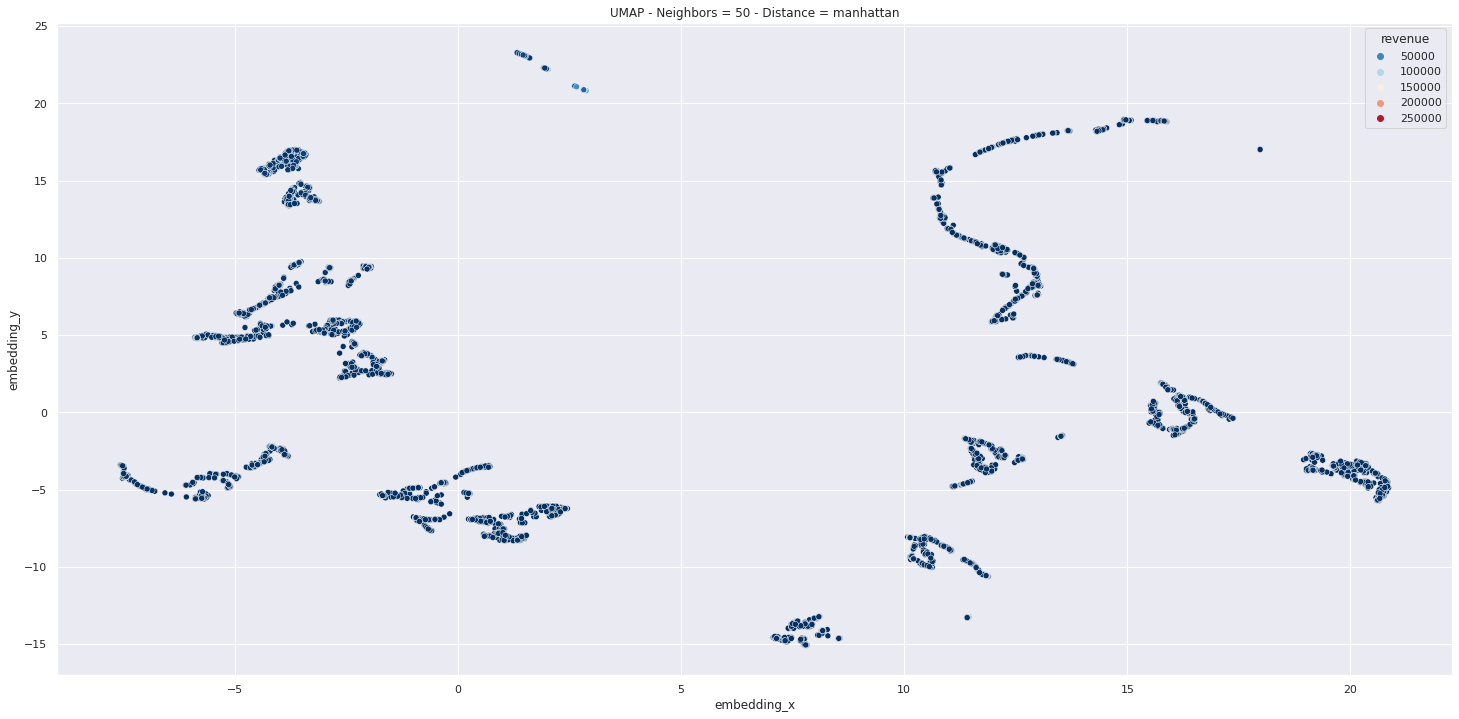

In [143]:
# começando de novo df4 sem reset
cols_selected = ['qty_items','avg_ticket','num_returns','returns_revenue','avg_unique_prods','qty_returned','num_purchases','recency','frequency']

# defining independent and dependent variable
X = df4[cols_selected].copy()
y = df4['revenue']

# defining random forest regresor for embedding
rf = RandomForestRegressor(random_state = 42, min_samples_split = 20) 
rf.fit(X, y)

# get leafs for each observation
df_leaf = pd.DataFrame( rf.apply(X) )

# defining umap algorithm
n_neighbors = 50
umap = UMAP(n_neighbors = n_neighbors, random_state = 42, metric = 'manhattan')  
res_umap = umap.fit_transform(df_leaf)
metric = umap.metric

# storing embedding results on a dataframe
df_tree = df4.copy()
df_tree['embedding_x'] =  res_umap[:,0]
df_tree['embedding_y'] =  res_umap[:,1]

# ploting results
cmap = sns.color_palette('RdBu_r', as_cmap = True)
plt.title('UMAP - Neighbors = {} - Distance = {}'.format(n_neighbors, metric) )
sns.scatterplot( data = df_tree, x = 'embedding_x', y = 'embedding_y', hue = 'revenue', palette = cmap);

In [144]:
res_umap[:5]

array([[-3.5439818,  9.718514 ],
       [-4.0253124,  8.022521 ],
       [-3.534883 , 16.845985 ],
       [-6.975824 , -4.9420776],
       [19.139286 , -2.6793914]], dtype=float32)

In [52]:
X

qty_items    avg_ticket  num_returns  returns_revenue  avg_unique_prods  qty_returned  num_purchases  recency  frequency
0          1693    155.547941         15.0          -102.58          8.735294         -40.0             34      373  34.000000
1          1355    343.233333         23.0          -143.49         19.000000         -35.0              9       57   0.028391
2          4978    441.956000          3.0           -76.04         15.466667         -50.0             15        3   0.040431
3           439    189.650000          0.0             0.00          5.600000           0.0              5       96   0.017986
4            58    211.700000          3.0          -240.90          1.000000         -22.0              3      334   0.075000
5          2073    325.107857          6.0           -71.79          7.285714         -29.0             14       26   0.040230
6          3222    243.208571         32.0          -523.49         15.285714        -399.0             21        8   0.057377
7          2016    445.404167          2.0           -67.06          5.083333         -41.0             12       17   0.033613
8         37720    652.959780        112.0         -1348.56         25.901099        -474.0             91        1   0.243968
9           613    286.518571          0.0             0.00          9.428571           0.0              7       88   0.024476
10          190    489.600000          0.0             0.00         13.000000           0.0              1      374   0.002674
11          265    199.610000          0.0             0.00         10.000000           0.0              3       51   0.009288
12        32203    938.610484         23.0        -14688.24          3.854839       -8004.0             62       39   0.185075
13          208    194.720000          0.0             0.00         12.000000           0.0              2      262   0.017857
14         2861    420.759333          4.0           -71.06         15.533333         -50.0             15       36   0.044379
15        63014   2843.167742        111.0         -2924.18         31.064516       -1535.0             31        3   0.083558
16          363    237.286667          0.0             0.00          9.333333           0.0              3        8   0.008197
17            8     79.600000          0.0             0.00          1.000000           0.0              1      374   0.002674
18        16128    449.812581         14.0          -228.66          7.709677        -104.0             62        2   0.166667
19         7258    457.992162         31.0          -274.65          9.945946         -64.0             37        3   0.099730
20         1141    413.475714          7.0           -68.17          4.428571         -19.0              7       12   0.019337
21         1638    577.611667          4.0           -73.70         31.666667         -22.0              6       17   0.016807
22          585    208.220000          0.0             0.00         36.750000           0.0              4        9   0.010959
23         5545    764.214737          6.0          -238.14         16.210526        -164.0             19       34   0.055882
24           96    177.600000          0.0             0.00          1.000000           0.0              1      374   0.002674
25         2077    436.410000          6.0           -29.81         12.000000         -11.0              7       30   0.020349
26          535    414.937500          0.0             0.00          1.500000           0.0              4      110   0.015152
27         2058    499.286667          0.0             0.00         30.000000           0.0              6       89   0.021053
28          173    243.280000          0.0             0.00         51.000000           0.0              1      374   0.002674
29         2514    246.600000          0.0             0.00         37.000000           0.0             17        5   0.046070
30          359    341.565000          0.0             0.00         5

In [54]:
X.columns

Index(['qty_items', 'avg_ticket', 'num_returns', 'returns_revenue',
       'avg_unique_prods', 'qty_returned', 'num_purchases', 'recency',
       'frequency'],
      dtype='object')

In [72]:
# from hd
df5_hd = pd.read_csv('../data/processed/df4_processed.csv')

# selecting most important features. Removing ('avg_basket_size', 'avg_days_bw_purchases', 'avg_return_revenue', 'date_range)
cols_selected = ['qty_items','avg_ticket','num_returns','returns_revenue','avg_unique_prods','qty_returned','num_purchases','recency','frequency']

# defining independent and dependent variable
X_hd = df5_hd[cols_selected].copy()
y_hd = df5_hd['revenue']

# defining random forest regresor for embedding
rf = RandomForestRegressor(random_state = 42, min_samples_split = 20) 
rf.fit(X_hd, y_hd)

# get leafs for each observation
df_leaf_hd = pd.DataFrame( rf.apply(X_hd) )
df_leaf_hd.tail()

# defining umap algorithm
n_neighbors = 50
umap = UMAP(n_neighbors = n_neighbors, random_state = 42, metric = 'manhattan')  
res_umap_hd = umap.fit_transform(df_leaf_hd)
metric = umap.metric

# storing embedding results on a dataframe
df_tree_hd = df5_hd.copy()
df_tree_hd['embedding_x'] =  res_umap_hd[:,0]
df_tree_hd['embedding_y'] =  res_umap_hd[:,1]

# # ploting results
# cmap = sns.color_palette('RdBu_r', as_cmap = True)
# plt.title('UMAP - Neighbors = {} - Distance = {}'.format(n_neighbors, metric) )
# sns.scatterplot( data = df_tree_hd, x = 'embedding_x', y = 'embedding_y', hue = 'revenue', palette = cmap);

res_umap_hd[:5]

array([[11.384928 , -0.3676688],
       [11.623067 ,  1.610966 ],
       [10.325433 , -7.799127 ],
       [10.479339 , 11.446996 ],
       [-7.344989 , 11.388304 ]], dtype=float32)

In [120]:
X.iloc[4,1]
# X_hd.iloc[4,1]


211.70000000000002

In [78]:
X[:5] == X_hd[:5]
X[:5]

qty_items  avg_ticket  num_returns  returns_revenue  avg_unique_prods  qty_returned  num_purchases  recency  frequency
0       1693  155.547941         15.0          -102.58          8.735294         -40.0             34      373  34.000000
1       1355  343.233333         23.0          -143.49         19.000000         -35.0              9       57   0.028391
2       4978  441.956000          3.0           -76.04         15.466667         -50.0             15        3   0.040431
3        439  189.650000          0.0             0.00          5.600000           0.0              5       96   0.017986
4         58  211.700000          3.0          -240.90          1.000000         -22.0              3      334   0.075000

In [79]:
X_hd[:5]

qty_items  avg_ticket  num_returns  returns_revenue  avg_unique_prods  qty_returned  num_purchases  recency  frequency
0       1693  155.547941         15.0          -102.58          8.735294         -40.0             34      373  34.000000
1       1355  343.233333         23.0          -143.49         19.000000         -35.0              9       57   0.028391
2       4978  441.956000          3.0           -76.04         15.466667         -50.0             15        3   0.040431
3        439  189.650000          0.0             0.00          5.600000           0.0              5       96   0.017986
4         58  211.700000          3.0          -240.90          1.000000         -22.0              3      334   0.075000

In [61]:
# mine

df5 = df4.copy()
# df5.reset_index(inplace = True, drop= True)

# selecting most important features. Removing ('avg_basket_size', 'avg_days_bw_purchases', 'avg_return_revenue', 'date_range)
cols_selected = ['qty_items','avg_ticket','num_returns','returns_revenue','avg_unique_prods','qty_returned','num_purchases','recency','frequency']

# defining independent and dependent variable
X = df5[cols_selected].copy()
y = df5['revenue']

# defining random forest regresor for embedding
rf = RandomForestRegressor(random_state = 42, min_samples_split = 20) 
rf.fit(X, y)

# get leafs for each observation
df_leaf = pd.DataFrame( rf.apply(X) )
df_leaf.tail()

# defining umap algorithm
n_neighbors = 50
umap = UMAP(n_neighbors = n_neighbors, random_state = 42, metric = 'manhattan')  
res_umap_mine = umap.fit_transform(df_leaf)
# metric = umap.metric

# # storing embedding results on a dataframe
# df_tree = df5.copy()
# df_tree['embedding_x'] =  res_umap_mine[:,0]
# df_tree['embedding_y'] =  res_umap_mine[:,1]

# # ploting results
# cmap = sns.color_palette('RdBu_r', as_cmap = True)
# plt.title('UMAP - Neighbors = {} - Distance = {}'.format(n_neighbors, metric) )
# sns.scatterplot( data = df_tree, x = 'embedding_x', y = 'embedding_y', hue = 'revenue', palette = cmap);

res_umap_mine

array([[-3.5439818 ,  9.718514  ],
       [-4.0253124 ,  8.022521  ],
       [-3.534883  , 16.845985  ],
       ...,
       [17.075638  , -0.10805517],
       [12.205334  ,  6.599212  ],
       [ 0.59354407, -8.022127  ]], dtype=float32)

In [64]:
np.all( res_umap_hd ==  res_umap_mine )

False

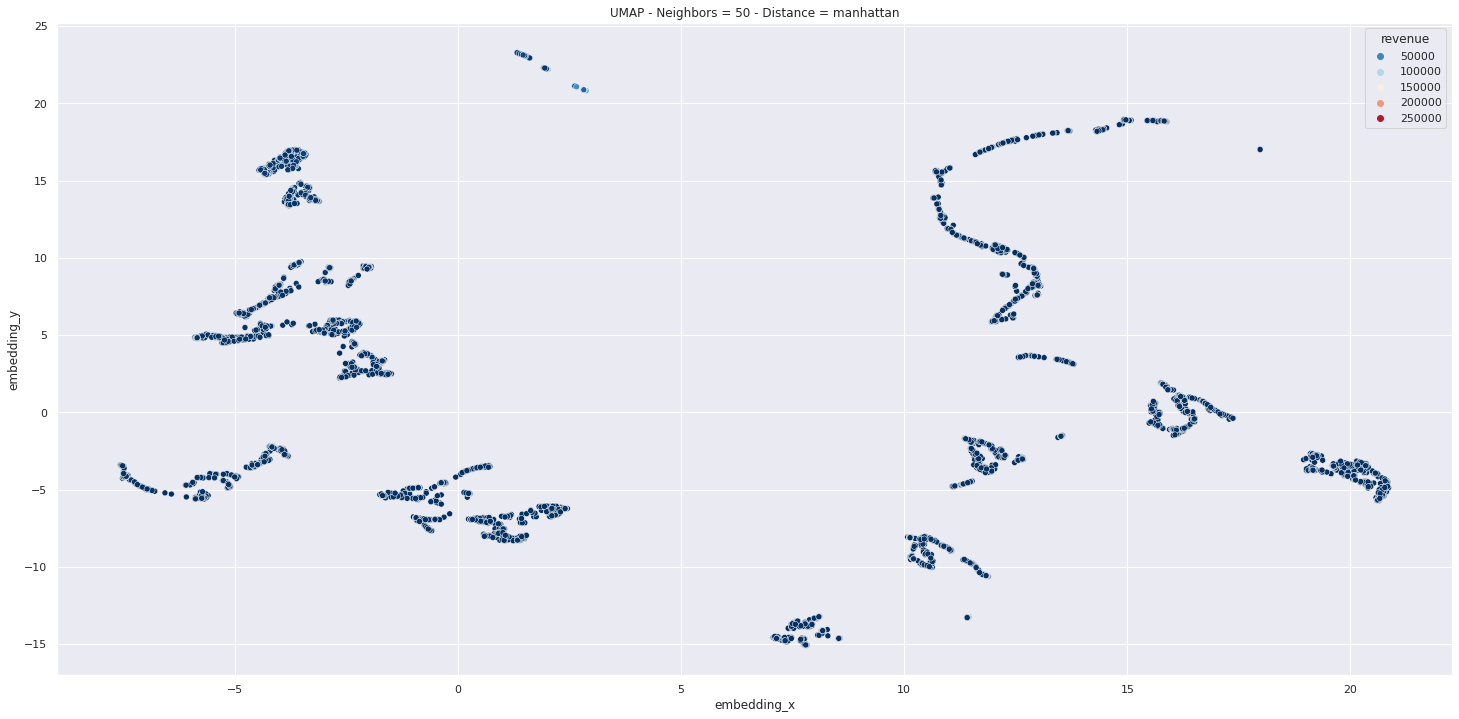

In [43]:
# selecting most important features. Removing ('avg_basket_size', 'avg_days_bw_purchases', 'avg_return_revenue', 'date_range)
cols_selected = ['qty_items','avg_ticket','num_returns','returns_revenue','avg_unique_prods','qty_returned','num_purchases','recency','frequency']

# defining independent and dependent variable
X = df5[cols_selected].copy()
y = df5['revenue']

# defining random forest regresor for embedding
rf = RandomForestRegressor(random_state = 42, min_samples_split = 20) 
rf.fit(X, y)

# get leafs for each observation
df_leaf = pd.DataFrame( rf.apply(X) )

# defining umap algorithm
n_neighbors = 50
umap = UMAP(n_neighbors = n_neighbors, random_state = 42, metric = 'manhattan')  
res_umap = umap.fit_transform(df_leaf)
metric = umap.metric

# storing embedding results on a dataframe
df_tree = df5.copy()
df_tree['embedding_x'] =  res_umap[:,0]
df_tree['embedding_y'] =  res_umap[:,1]

# ploting results
cmap = sns.color_palette('RdBu_r', as_cmap = True)
plt.title('UMAP - Neighbors = {} - Distance = {}'.format(n_neighbors, metric) )
sns.scatterplot( data = df_tree, x = 'embedding_x', y = 'embedding_y', hue = 'revenue', palette = cmap);

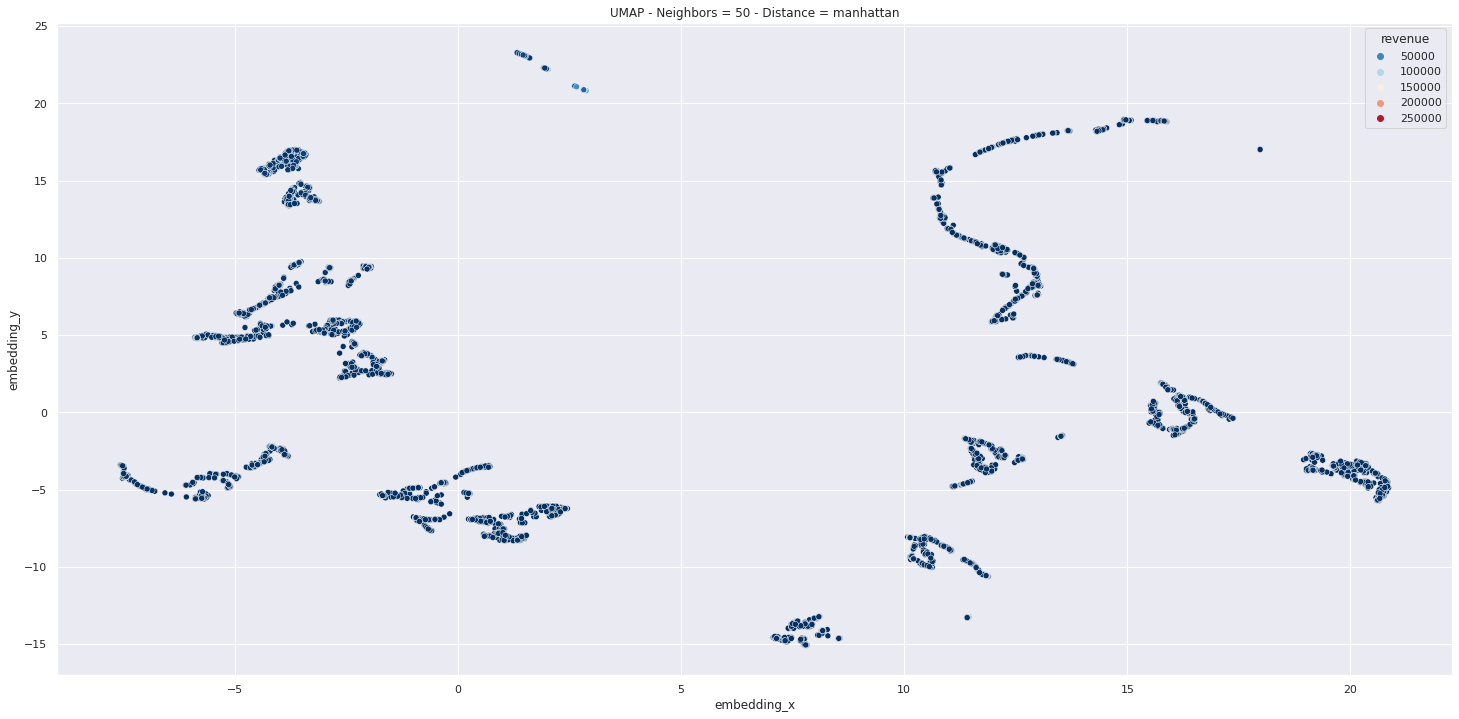

In [142]:
# selecting most important features. Removing ('avg_basket_size', 'avg_days_bw_purchases', 'avg_return_revenue', 'date_range)
cols_selected = ['qty_items','avg_ticket','num_returns','returns_revenue','avg_unique_prods','qty_returned','num_purchases','recency','frequency']

# defining independent and dependent variable
X = df4[cols_selected].copy()
y = df4['revenue']

# defining random forest regresor for embedding
rf = RandomForestRegressor(random_state = 42, min_samples_split = 20) 
rf.fit(X, y)

# get leafs for each observation
df_leaf = pd.DataFrame( rf.apply(X) )

# defining umap algorithm
n_neighbors = 50
umap = UMAP(n_neighbors = n_neighbors, random_state = 42, metric = 'manhattan')  
res_umap = umap.fit_transform(df_leaf)
metric = umap.metric

# storing embedding results on a dataframe
df_tree = df4.copy()
df_tree['embedding_x'] =  res_umap[:,0]
df_tree['embedding_y'] =  res_umap[:,1]

# ploting results
cmap = sns.color_palette('RdBu_r', as_cmap = True)
plt.title('UMAP - Neighbors = {} - Distance = {}'.format(n_neighbors, metric) )
sns.scatterplot( data = df_tree, x = 'embedding_x', y = 'embedding_y', hue = 'revenue', palette = cmap);

In [94]:
# sns.scatterplot( data = df_tree, x = 'embedding_x', y = 'embedding_y', hue = 'revenue', palette = cmap);


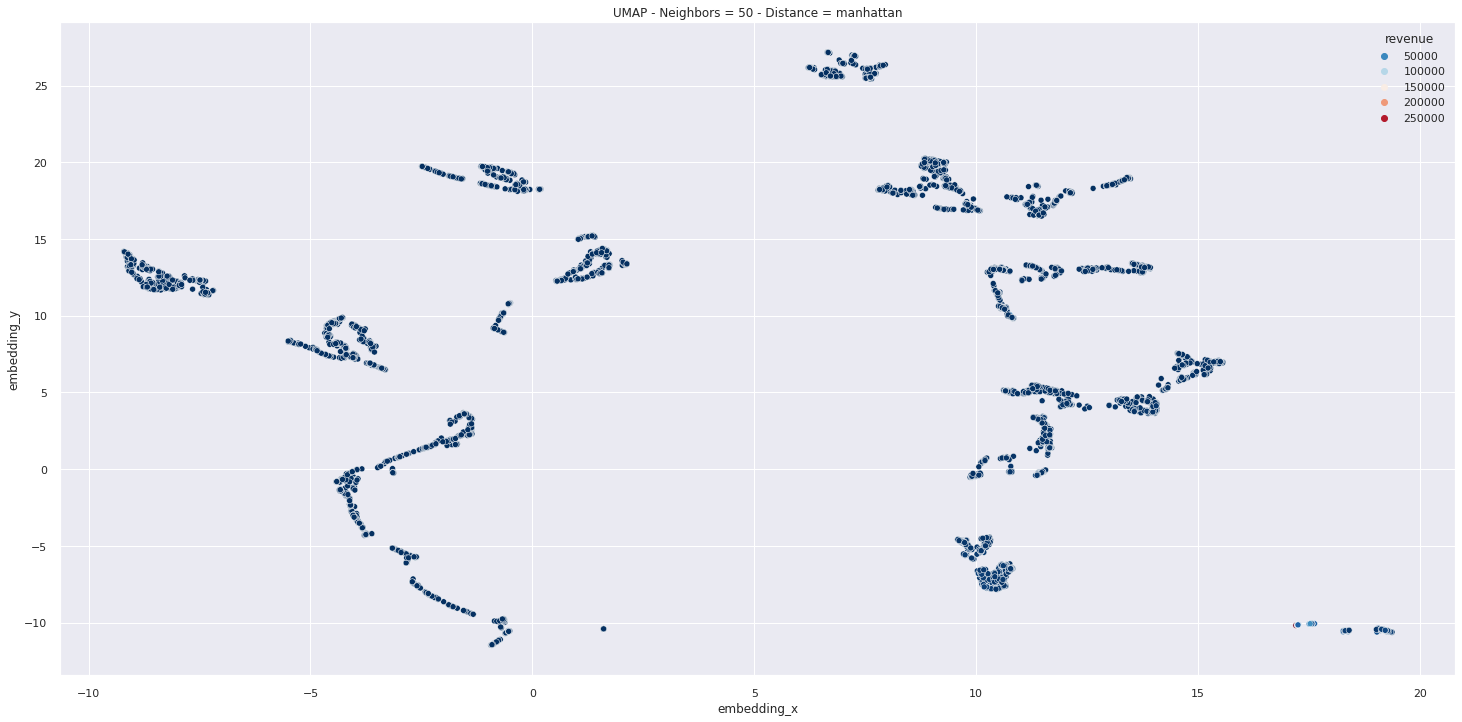

In [ ]:
# selecting most important features. Removing ('avg_basket_size', 'avg_days_bw_purchases', 'avg_return_revenue', 'date_range)
cols_selected = ['qty_items','avg_ticket','num_returns','returns_revenue','avg_unique_prods','qty_returned','num_purchases','recency','frequency']

# defining independent and dependent variable
X = df5[cols_selected].copy()
y = df5['revenue']

# defining random forest regresor for embedding
rf = RandomForestRegressor(random_state = 42, min_samples_split = 20) 
rf.fit(X, y)

# get leafs for each observation
df_leaf = pd.DataFrame( rf.apply(X) )

# defining umap algorithm
n_neighbors = 50
umap = UMAP(n_neighbors = n_neighbors, random_state = 42, metric = 'manhattan')  
res_umap = umap.fit_transform(df_leaf)
metric = umap.metric

# storing embedding results on a dataframe
df_tree = df5.copy()
df_tree['embedding_x'] =  res_umap[:,0]
df_tree['embedding_y'] =  res_umap[:,1]

# ploting results
cmap = sns.color_palette('RdBu_r', as_cmap = True)
plt.title('UMAP - Neighbors = {} - Distance = {}'.format(n_neighbors, metric) )
sns.scatterplot( data = df_tree, x = 'embedding_x', y = 'embedding_y', hue = 'revenue', palette = cmap);

# 7.0 Model Testing

In [8]:
# defining two spaces of data (embedded and rescaled) to test models

# tree embedded data
df_tree = pd.DataFrame()
df_tree['embedding_x'] =  res_umap[:,0]
df_tree['embedding_y'] =  res_umap[:,1]

# rescaled data
df7 = df6.copy()

## 7.1 KMeans

### 7.1.1 Rescaled Data

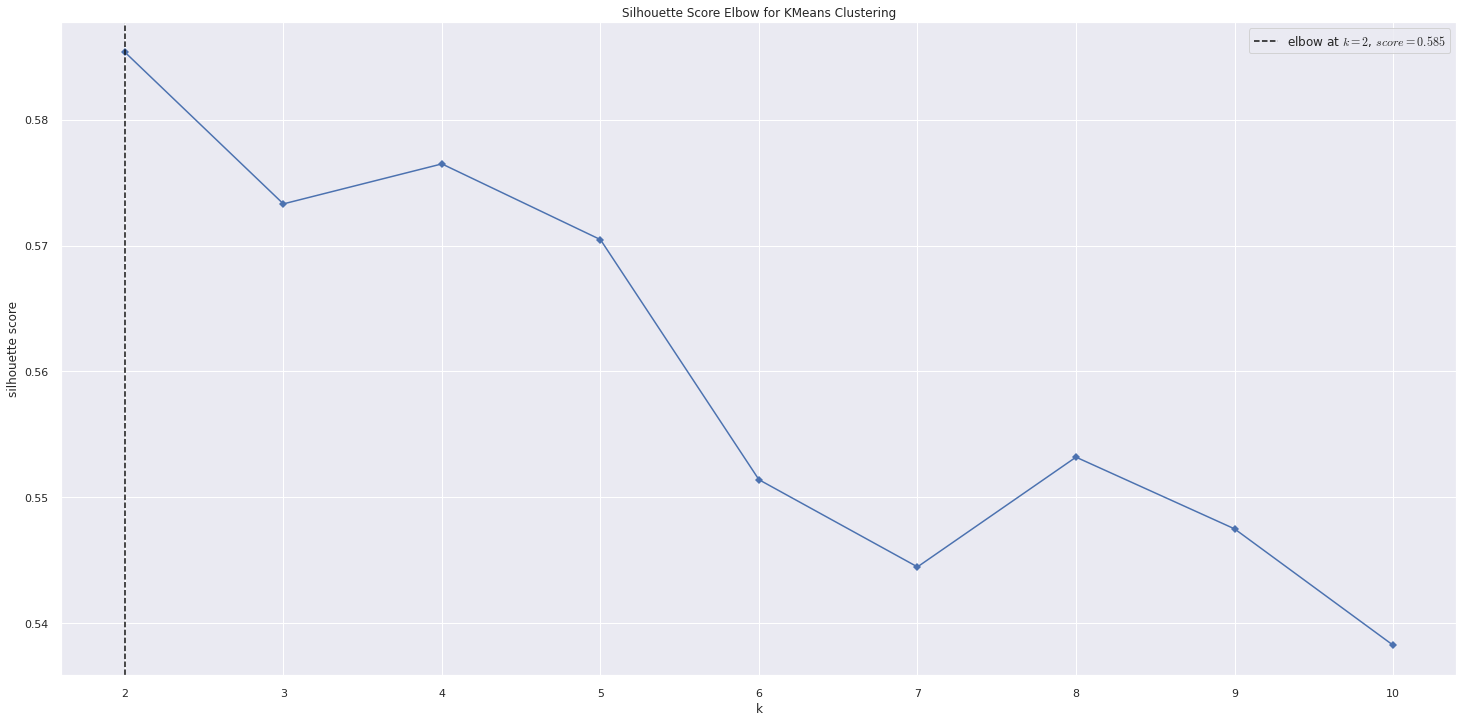

In [204]:
kmeans = KMeans( random_state = 42)
visualizer = KElbowVisualizer(kmeans, k=(2,11), timings = False, metric = 'silhouette' )
visualizer.fit(df7)
visualizer.finalize();

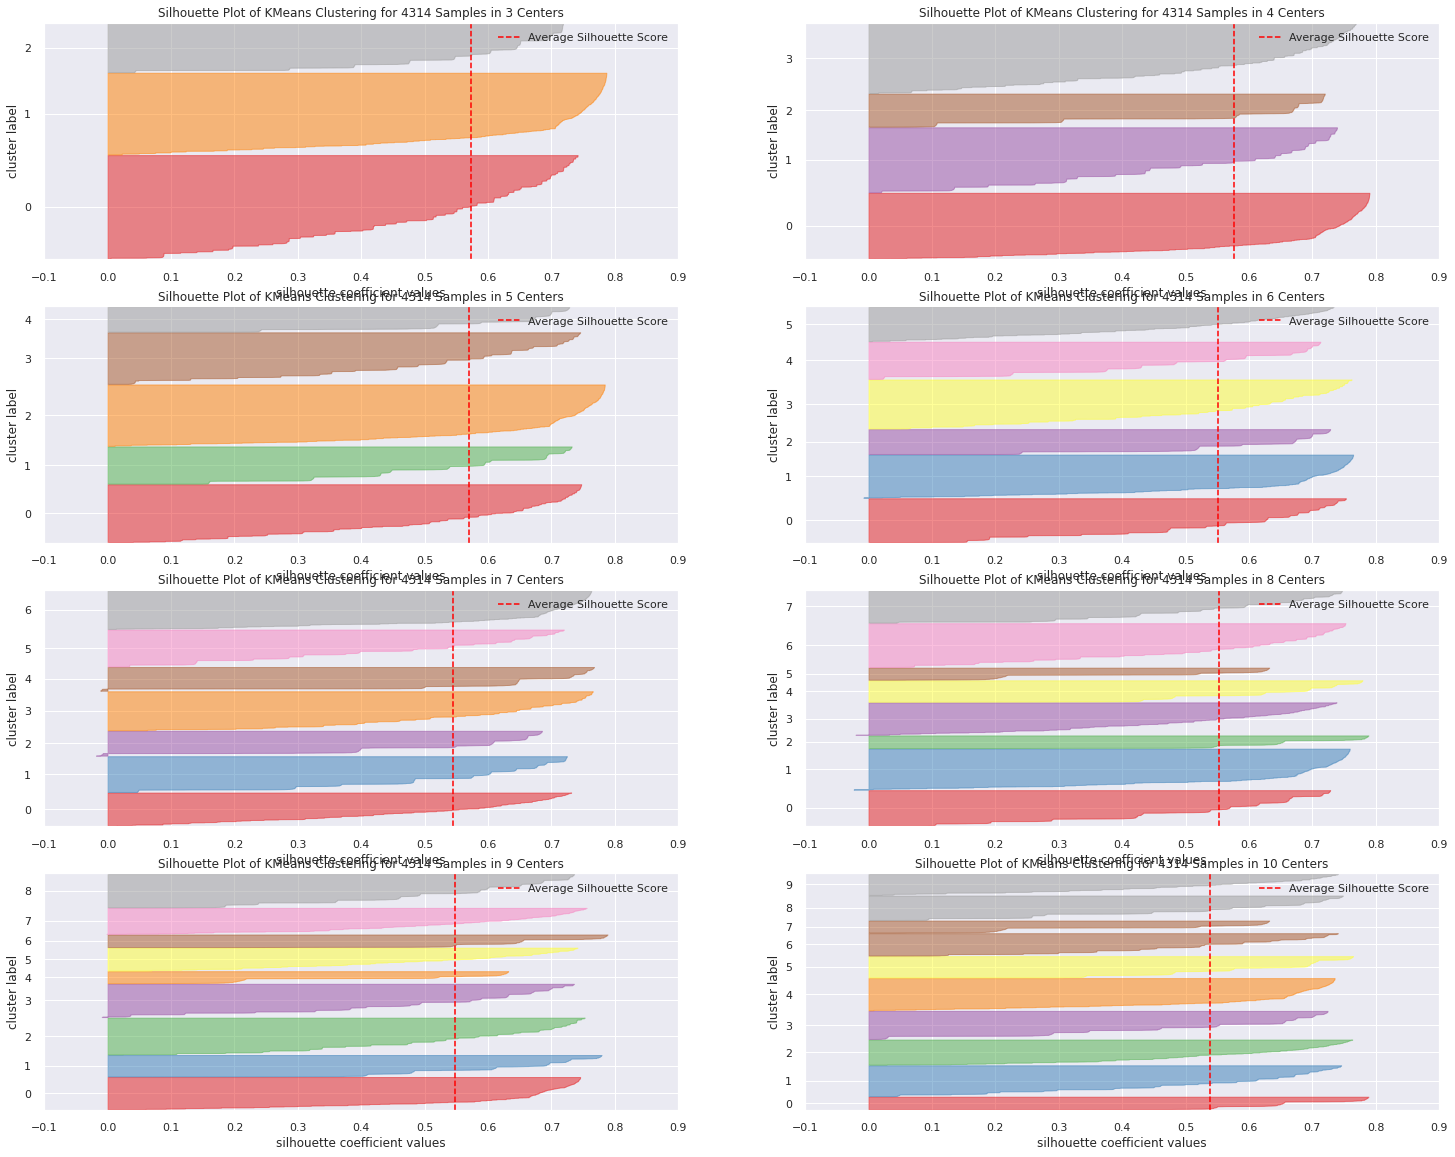

In [219]:
clusters = np.arange(3, 11)

# figure to plot
fig, ax = plt.subplots(4,2, figsize = (25,20) )
kmeans_silhouette = []

for idx, n_clusters in enumerate(clusters):
    # defining model
    kmeans = KMeans(n_clusters = n_clusters, random_state = 42)
    
    # getting row and col
    row, col = divmod(idx, 2)
    
    # calculating silhouette score
    labels = kmeans.fit_predict(df7.values)
    sil = silhouette_score( df7, labels)
    kmeans_silhouette.append(sil)
    
    # applying model
    model = SilhouetteVisualizer( kmeans, ax = ax[row][col] )
    model.fit(df7.values)
    model.finalize()

In [8]:
# calculating silhouette score for evaluation
kmeans_silhouette = []
for n_clusters in range(2,13):
    # defining model
    kmeans = KMeans(n_clusters = n_clusters, random_state = 42)
      
    # calculating silhouette score
    labels = kmeans.fit_predict(df7.values)
    sil = silhouette_score( df7, labels)
    kmeans_silhouette.append(sil)

### 7.1.2 Embedded Data

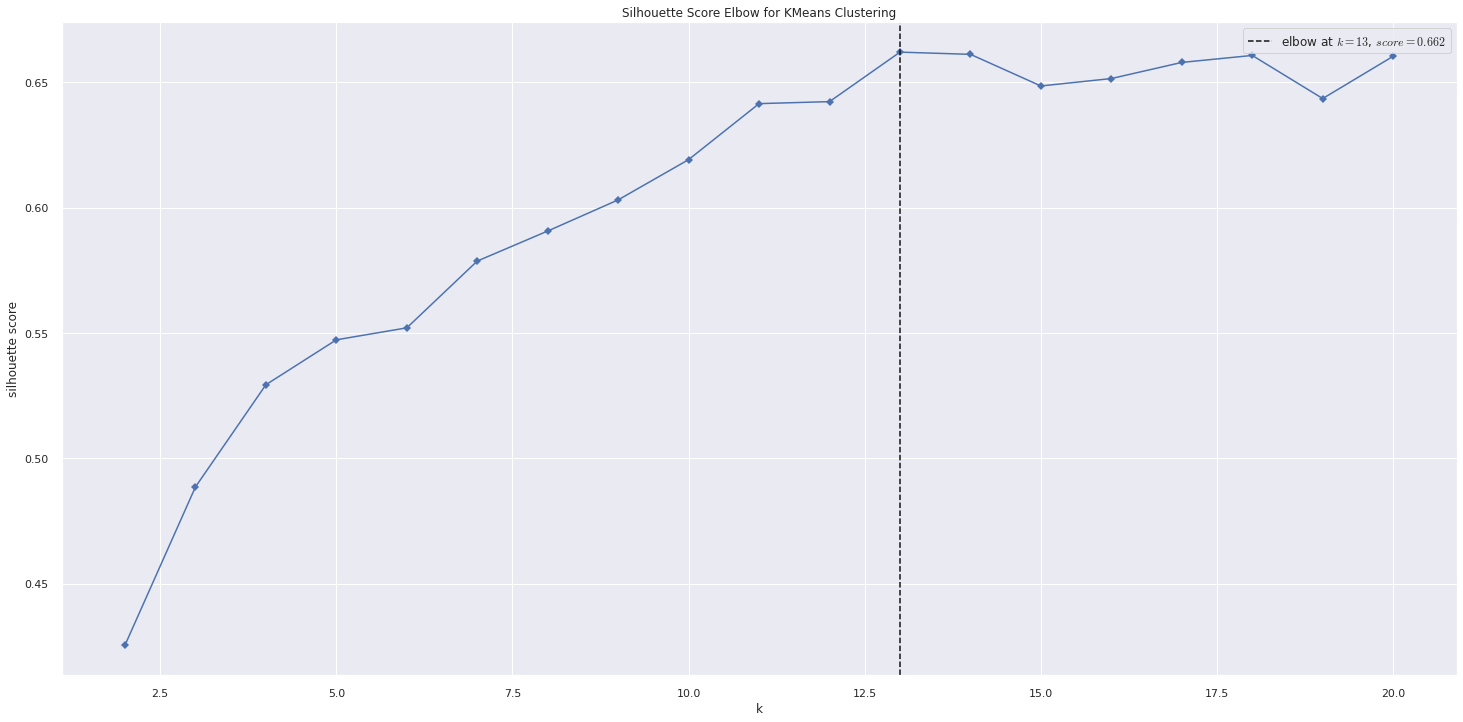

In [38]:
kmeans = KMeans( random_state = 42)
visualizer = KElbowVisualizer(kmeans, k=(2,21), timings = False, metric = 'silhouette' )
visualizer.fit(df_tree)
visualizer.finalize();

In [66]:
# calculating silhouette score for evaluation
n_max = 20

clusters = np.arange(2, n_max+1, 1)

kmeans_silhouette_emb = []
for n_clusters in clusters:
    # defining model
    kmeans = KMeans(n_clusters = n_clusters, random_state = 42)
      
    # calculating silhouette score
    labels = kmeans.fit_predict(df_tree.values)
    sil = silhouette_score( df_tree, labels)
    kmeans_silhouette_emb.append(sil)

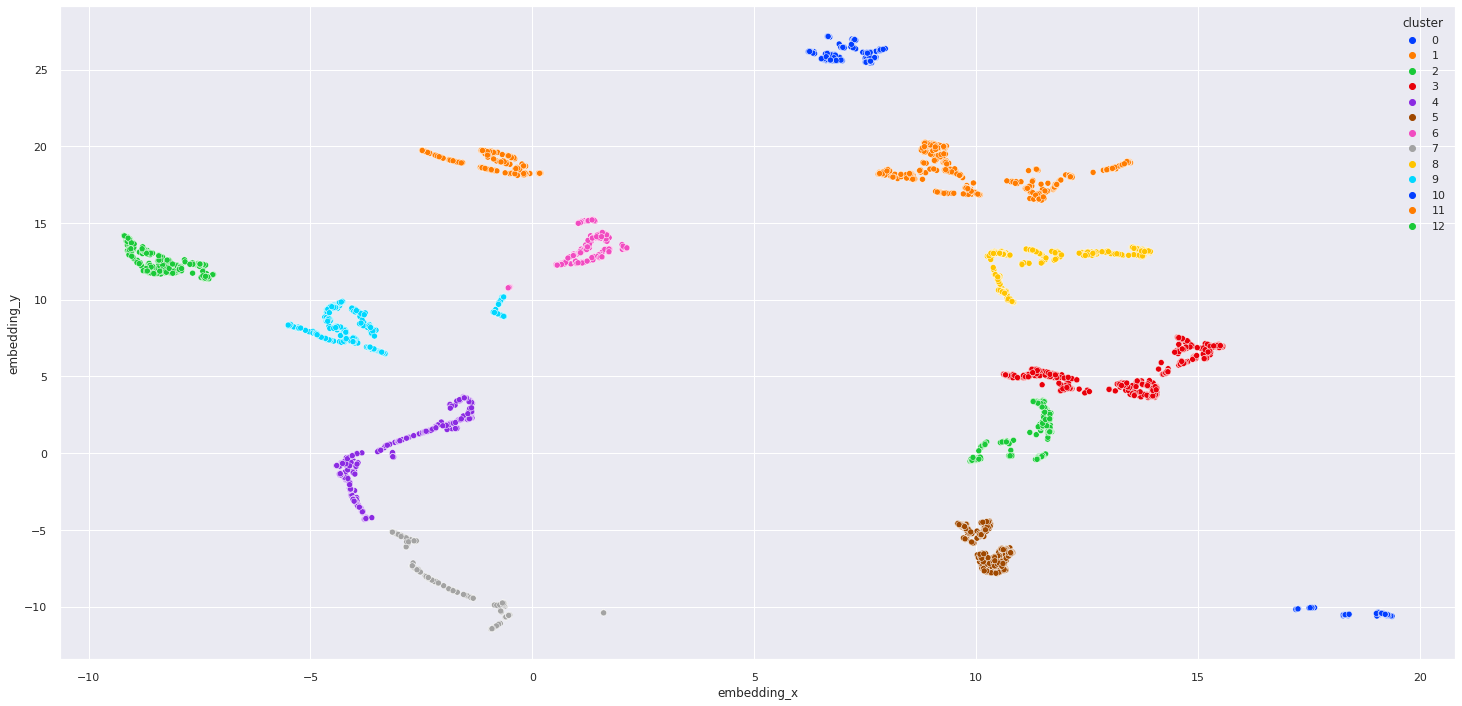

In [276]:
n_clusters = 13

kmeans = KMeans(n_clusters = n_clusters, random_state = 42)

labels = kmeans.fit_predict(df_tree)

df_res = df_tree.copy()
df_res['cluster'] = labels

sns.scatterplot(data = df_res, x = 'embedding_x', y = 'embedding_y', hue = 'cluster', palette = 'bright');

## 7.2 Hierarchical Clustering


### 7.2.1 Rescaled Data

In [220]:
# defining model 
hc_model = hc.linkage( pd.DataFrame(df7), 'ward' )

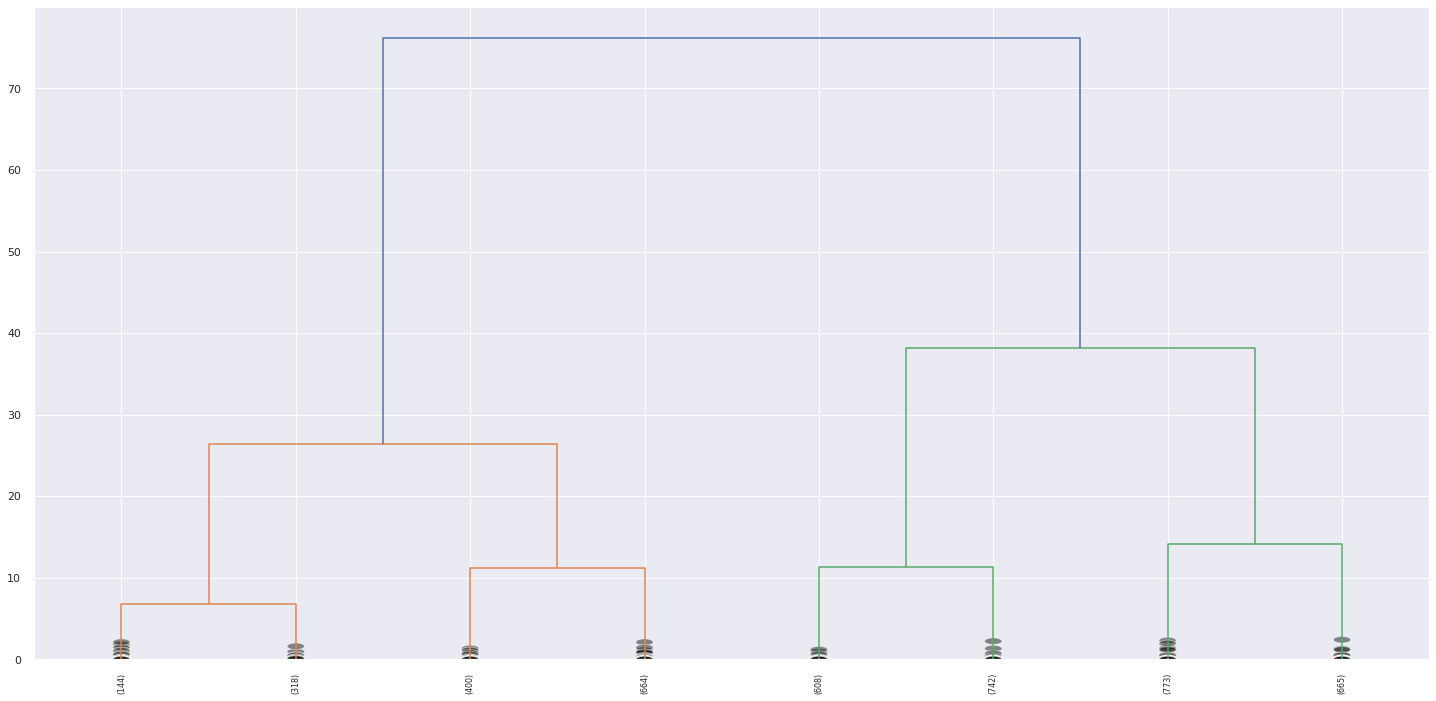

In [221]:
hc.dendrogram( hc_model, truncate_mode='lastp', p = 8,  leaf_rotation = 90, leaf_font_size = 8,  show_contracted=True)

plt.plot();

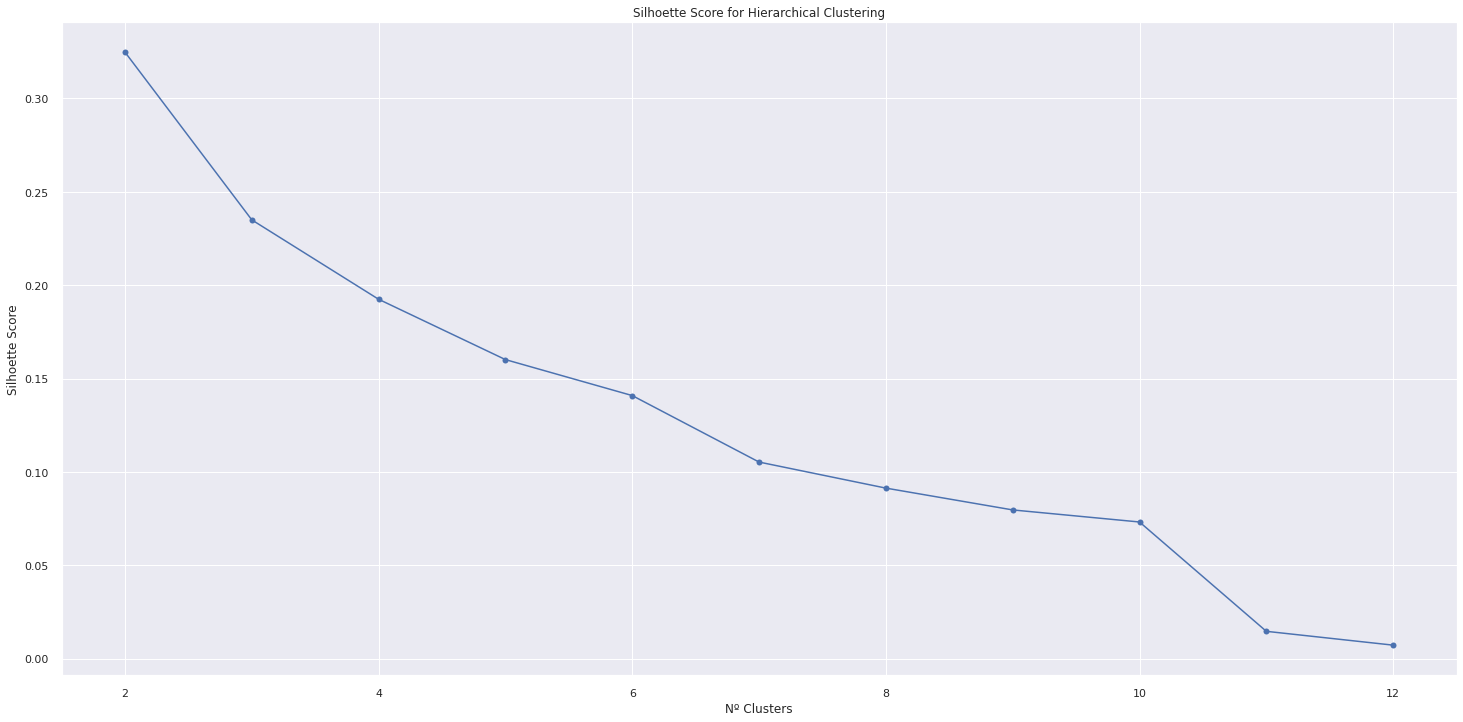

In [20]:
# HC
n_max = 12

hc_silhouette = []
for n_clusters in range(2, n_max + 1):
    # define model
    hc_model = hc.linkage(df7, 'ward')

    labels = hc.fcluster(hc_model, t = n_clusters, criterion = 'maxclust')
    # get labels

    # metric
    sil = silhouette_score(df_prep, labels)
    hc_silhouette.append(sil)

# ploting silhouette
plt.title('Silhoette Score for Hierarchical Clustering')
plt.xlabel('Nº Clusters')
plt.ylabel('Silhoette Score')
plt.plot( range(2, n_max + 1) , hc_silhouette, marker = 'o', color = 'b');

### 7.2.2 Embedded Data

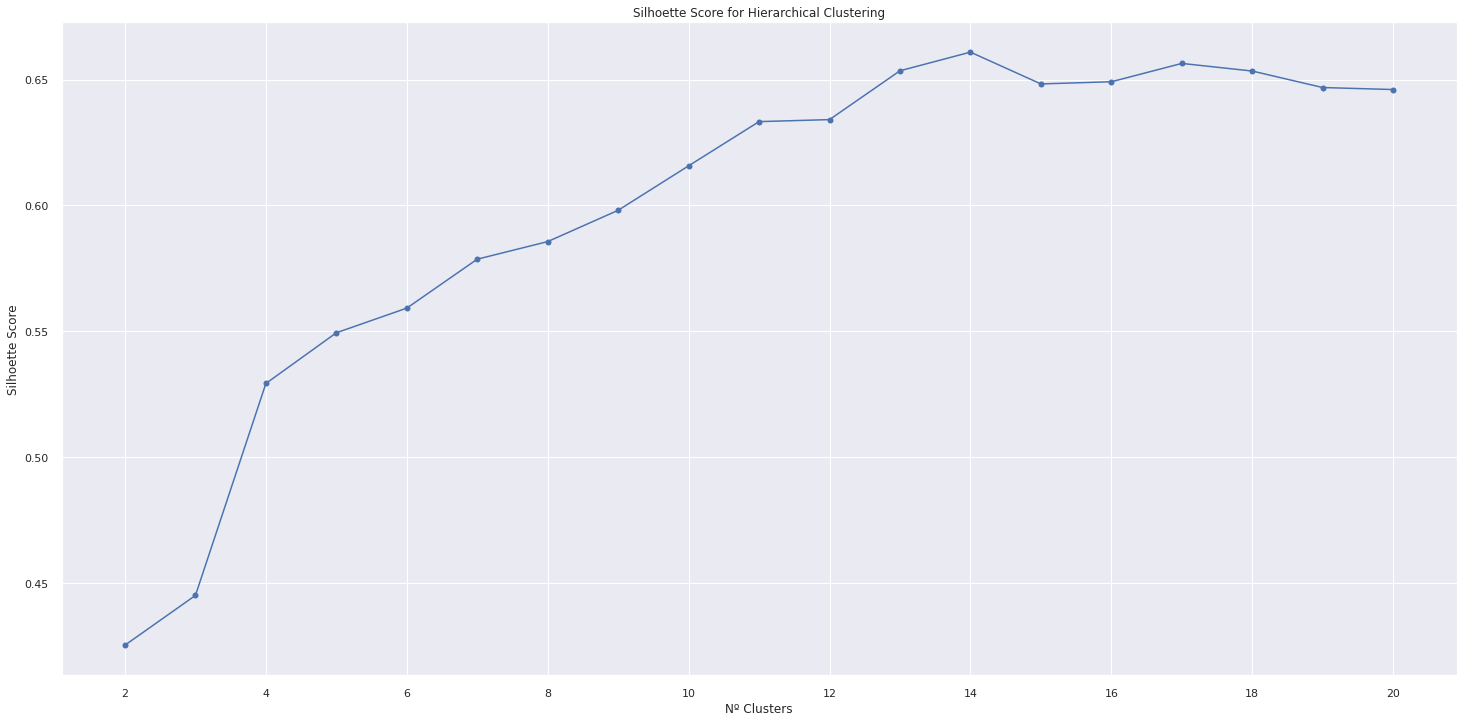

In [67]:
# HC
n_max = 20

hc_silhouette_emb = []
for n_clusters in range(2, n_max + 1):
    # define model
    hc_model = hc.linkage(df_tree, 'ward')

    labels = hc.fcluster(hc_model, t = n_clusters, criterion = 'maxclust')
    # get labels

    # metric
    sil = silhouette_score(df_tree, labels)
    hc_silhouette_emb.append(sil)

# ploting silhouette
plt.title('Silhoette Score for Hierarchical Clustering')
plt.xlabel('Nº Clusters')
plt.ylabel('Silhoette Score')
plt.xticks(np.arange(2, n_max+1, 2) )
plt.plot( range(2, n_max + 1) , hc_silhouette_emb, marker = 'o', color = 'b');

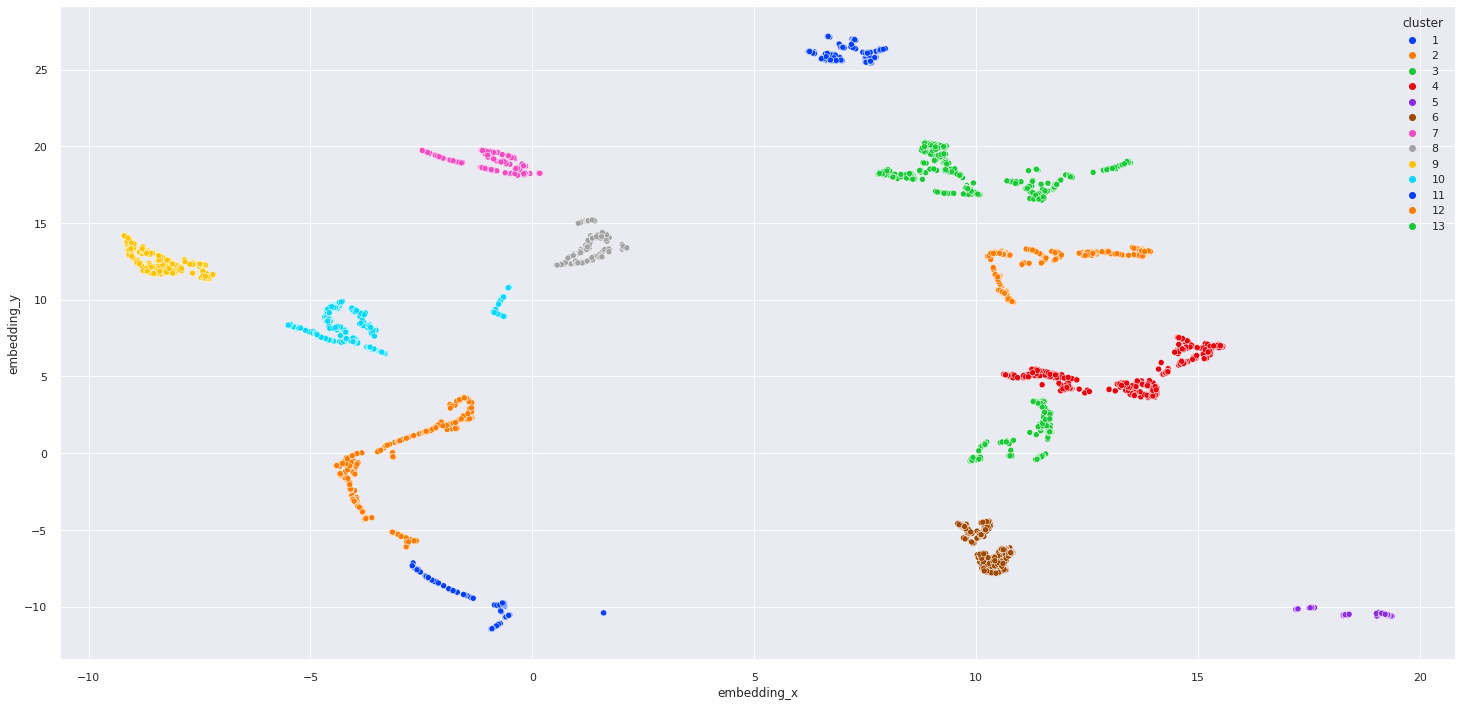

In [277]:
# plotting embedded space with clusters
n_clusters = 13

hc_model = hc.linkage(df_tree, 'ward')

labels = hc.fcluster(hc_model, t = n_clusters, criterion = 'maxclust')

df_res = df_tree.copy()
df_res['cluster'] = labels

sns.scatterplot(data = df_res, x = 'embedding_x', y = 'embedding_y', hue = 'cluster', palette = 'bright');

## 7.3 DBSCAN

### 7.3.1 Rescaled Data

In [128]:
# hyperparameters
eps = 0.3
min_samples = 20

# defining model
db_model = DBSCAN( eps = eps, min_samples = min_samples, metric = 'euclidean')
labels = db_model.fit_predict(df7)

print( 'Silhouette Score: {:,.4f}'.format(silhouette_score(df7, labels)) )
print( 'Number of Clusters: {}'.format(len(np.unique(labels))) )
print( 'Clusters: {}'.format(np.unique(labels)) )

Silhouette Score: 0.3581
Number of Clusters: 3
Clusters: [-1  0  1]


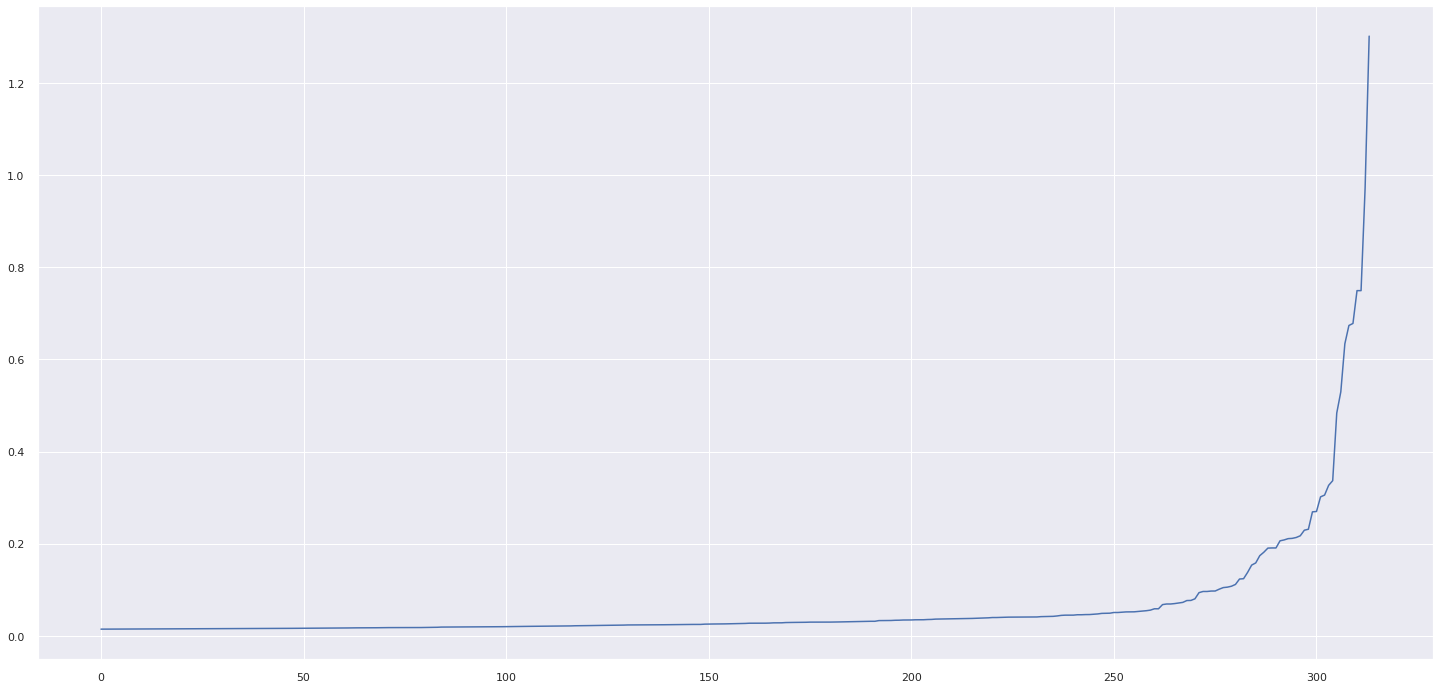

In [173]:
# Tuning DBSAN

from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors = 2)

nbrs.fit(df7)

dist, idx = nbrs.kneighbors(df7)

distances = np.sort(dist, axis = 0)

# # full distances array for the last neighbor
# plt.plot(distances[:, 9]);

# distances array for the last neighbor starting from the 4000th neighbor
plt.plot(distances[4000:, 1]);



In [179]:
# hyperparameters
eps = 0.2
min_samples = 20

# defining model
db_model = DBSCAN( eps = eps, min_samples = min_samples, metric = 'euclidean')
labels = db_model.fit_predict(df7)

print( 'Silhouette Score: {:,.4f}'.format(silhouette_score(df7, labels)) )
print( 'Number of Clusters: {}'.format(len(np.unique(labels))) )
print( 'Clusters: {}'.format(np.unique(labels)) )

# the results were not satisfactory using the proposed method

Silhouette Score: 0.3405
Number of Clusters: 4
Clusters: [-1  0  1  2]


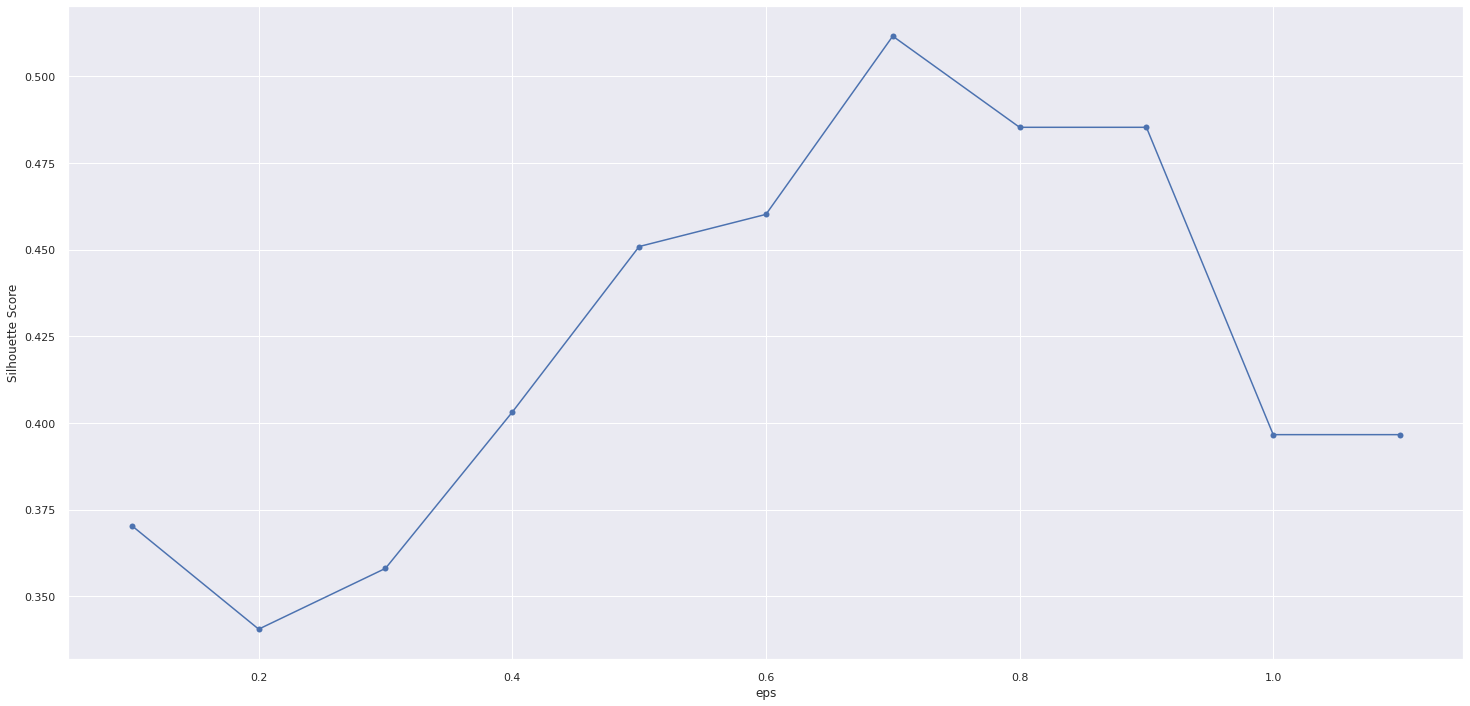

In [247]:
# DBSCAN
# testing multiple values for eps
max_eps = 1.1

dbscan_silhouette = []
n_clust = []

for eps in np.arange(0.1 , max_eps+ 0.1, 0.1):
    # define model
    db_model = DBSCAN(eps = eps, min_samples = 20)
    # get labels
    labels = db_model.fit_predict(df7)

    # n_clusters
    current_nclust = len( np.unique(labels) )
    # metric
    sil = silhouette_score(df7, labels)
    dbscan_silhouette.append(sil)
    n_clust.append(current_nclust)

# ploting silhouette
plt.plot( np.arange(0.1 , max_eps+ 0.1, 0.1) , dbscan_silhouette, marker = 'o', color = 'b');
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.show();

In [55]:
# DBSCAN
max_eps = 0.2

dbscan_silhouette = []
n_clust = []

for eps in np.arange(0.01 , max_eps+ 0.01, 0.01):
    # define model
    db_model = DBSCAN(eps = eps, min_samples = 20)
    # get labels
    labels = db_model.fit_predict(df7)

    # n_clusters
    current_nclust = len( np.unique(labels) )
    # metric
    sil = silhouette_score(df7, labels)
    dbscan_silhouette.append(sil)
    n_clust.append(current_nclust)

# ploting silhouette
plt.plot( np.arange(0.01 , max_eps+ 0.01, 0.1) , dbscan_silhouette, marker = 'o', color = 'b');
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.show();

NameError: name 'df7' is not defined

### 7.3.2 Embedded Data

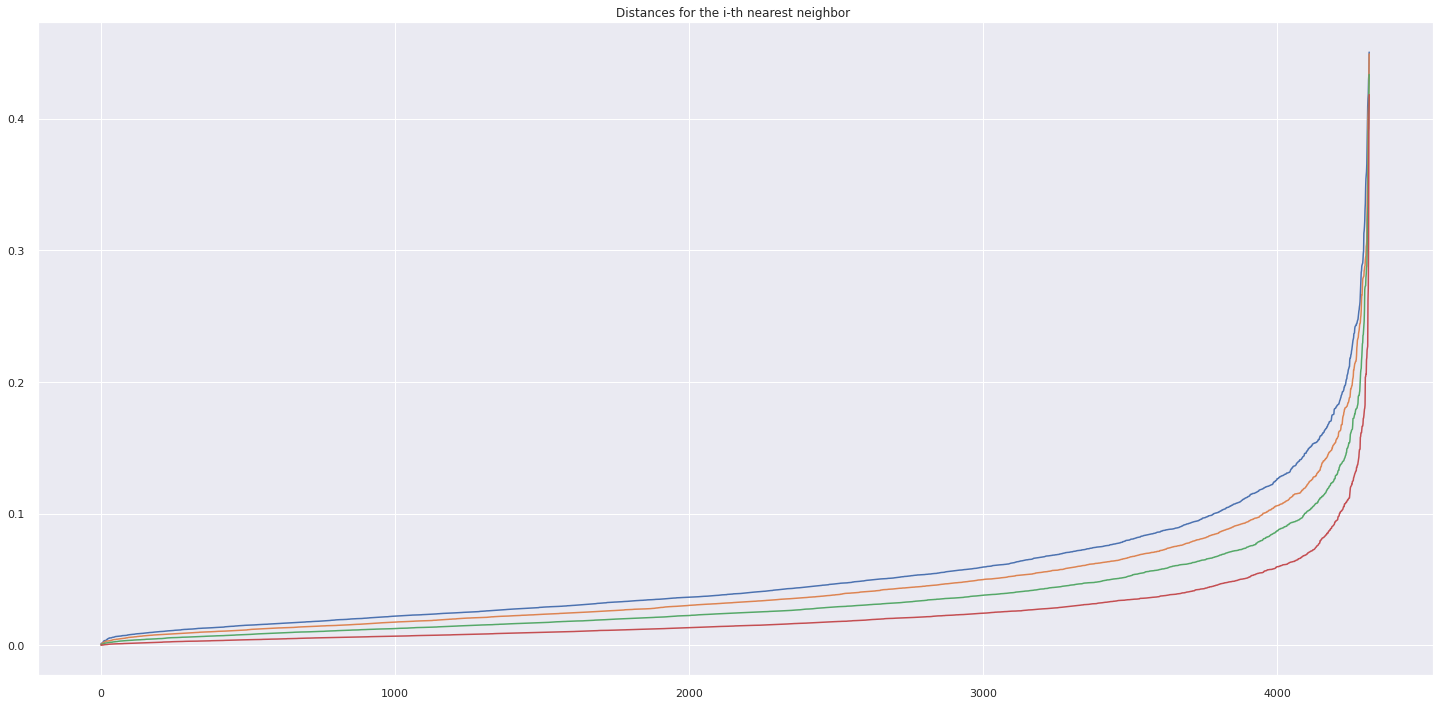

In [126]:
# testing proposed tuning method
nn = NearestNeighbors(n_neighbors = 5)
nn.fit(df_tree)

dist, _ = nn.kneighbors(df_tree)

distances = np.sort(dist, axis = 0)

plt.title('Distances for the i-th nearest neighbor ')
plt.plot(distances[:, 4]);
plt.plot(distances[:, 3]);
plt.plot(distances[:, 2]);
plt.plot(distances[:, 1]);

# this method suggested an eps value that led to houdreds of clusters

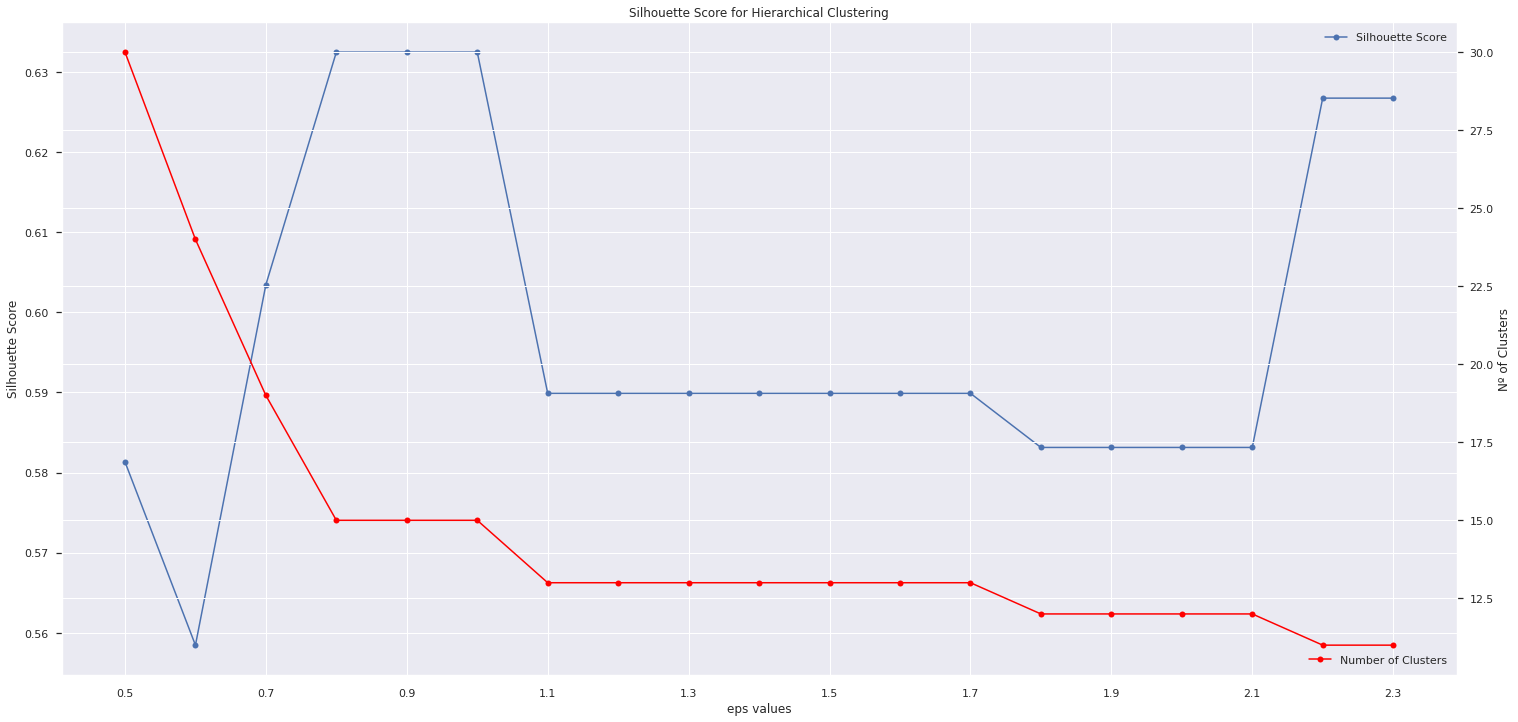

In [256]:
# testing dbscan for a few epd values

eps_list = np.arange(0.5, 2.4, 0.1)

db_silhouette_emb = []
n_clusters = []

for eps in eps_list:
    # define model
    db_model = DBSCAN(eps = eps, min_samples = 5, metric = 'euclidean' )
    
    # get labels
    labels = db_model.fit_predict(df_tree)

    # metric
    sil = silhouette_score(df_tree, labels)
    db_silhouette_emb.append(sil)
    
    #nº of clusters
    n_clusters.append( len(np.unique(labels)) )

# ploting silhouette
fig, ax1 = plt.subplots( )

x = eps_list
ax1.set_title('Silhouette Score for Hierarchical Clustering')
ax1.set_xlabel('eps values')
ax1.set_ylabel('Silhouette Score')
ax1.set_xticks( np.arange(0.5, 2.4, 0.2) )
ax1.plot( x , db_silhouette_emb, marker = 'o', color = 'b', label = 'Silhouette Score');
ax1.legend(loc = 'upper right');

ax2 = ax1.twinx()
ax2.set_ylabel('Nº of Clusters')
ax2.plot(x, n_clusters, marker = 'o', color = 'red', label = 'Number of Clusters')
ax2.legend( loc = 'lower right');
ax2.set_yscale('linear')

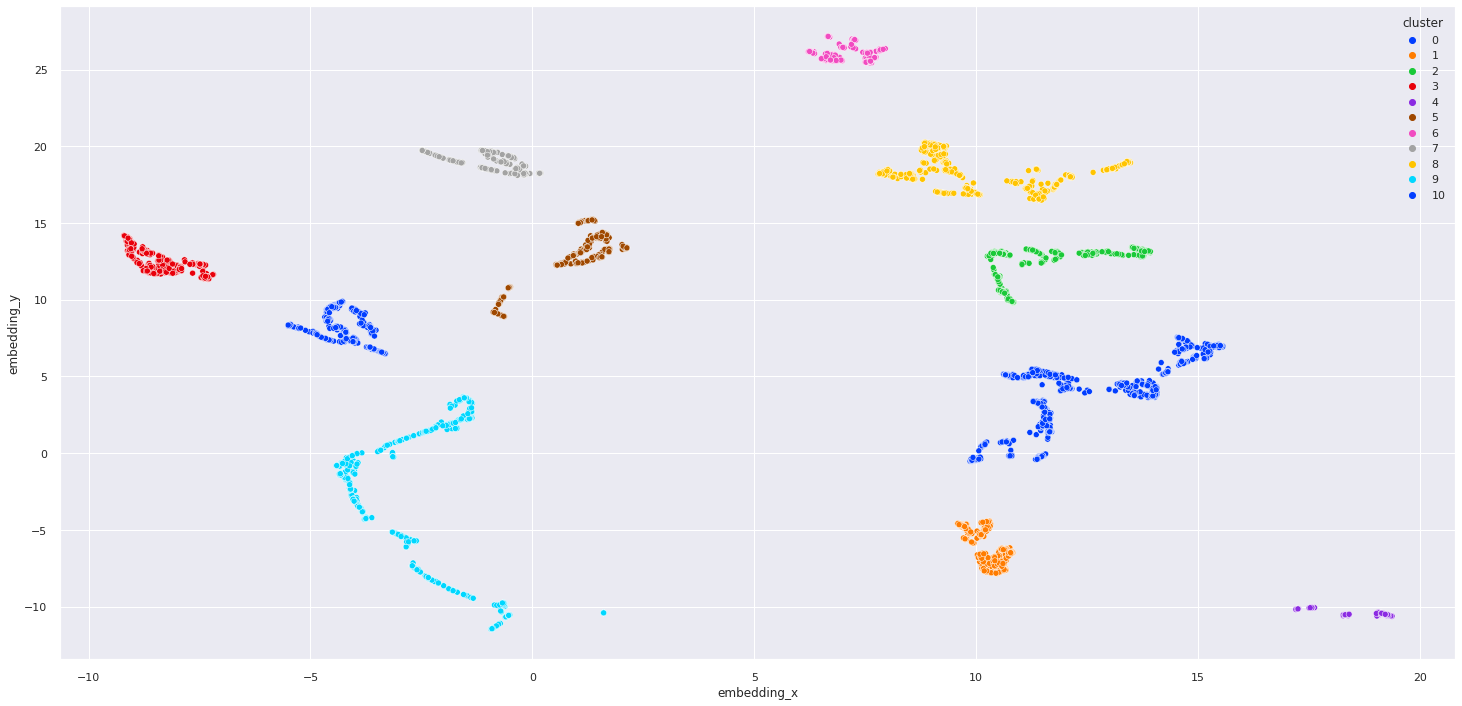

In [252]:
db_model = DBSCAN(eps = 2.3, min_samples=5)

labels = db_model.fit_predict(df_tree)

df_res = df_tree.copy()
df_res['cluster'] = labels

sns.scatterplot(data = df_res, x = 'embedding_x', y = 'embedding_y', hue = 'cluster', palette = 'bright');

## 7.4 AffinityPropagation


In [84]:
# hyperparameters
damping = 0.8

# defining model
ap_model = AffinityPropagation( damping = damping, random_state=42)
labels = ap_model.fit_predict(df7)

print( 'Silhouette Score: {:,.4f}'.format(silhouette_score(df_prep, labels)) )
print( 'Number of Clusters: {}'.format(len(np.unique(labels))) )
print( 'Clusters: {}'.format(np.unique(labels)) )


Silhouette Score: 0.3130
Number of Clusters: 46
Clusters: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


In [249]:
# hyperparameters
damping = 0.8

# defining model
ap_model = AffinityPropagation( damping = damping, random_state=42)
labels = ap_model.fit_predict(df7)

print( 'Silhouette Score: {:,.4f}'.format(silhouette_score(df_prep, labels)) )
print( 'Number of Clusters: {}'.format(len(np.unique(labels))) )
print( 'Clusters: {}'.format(np.unique(labels)) )


Silhouette Score: -0.0430
Number of Clusters: 29
Clusters: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]


This one did not converge or returned too many clusters (i.e. 46)

## 7.5 SpectralClustering


### 7.5.1 Rescaled Data

In [251]:
# hyperparameters
n_clusters = 5
random_state = 42
affinity = 'rbf' # rbf, polynomial, poly, laplacian
n_jobs = -1

# defining model
sp_model = SpectralClustering(n_clusters = n_clusters, random_state = random_state, affinity = affinity, n_jobs = n_jobs)
labels = sp_model.fit_predict(df7)

# Checking Performance
print( 'Silhouette Score: {:,.4f}'.format(silhouette_score(df7, labels)) )
print( 'Number of Clusters: {}'.format(len(np.unique(labels))) )
print( 'Clusters: {}'.format(np.unique(labels)) )

Silhouette Score: 0.4902
Number of Clusters: 5
Clusters: [0 1 2 3 4]


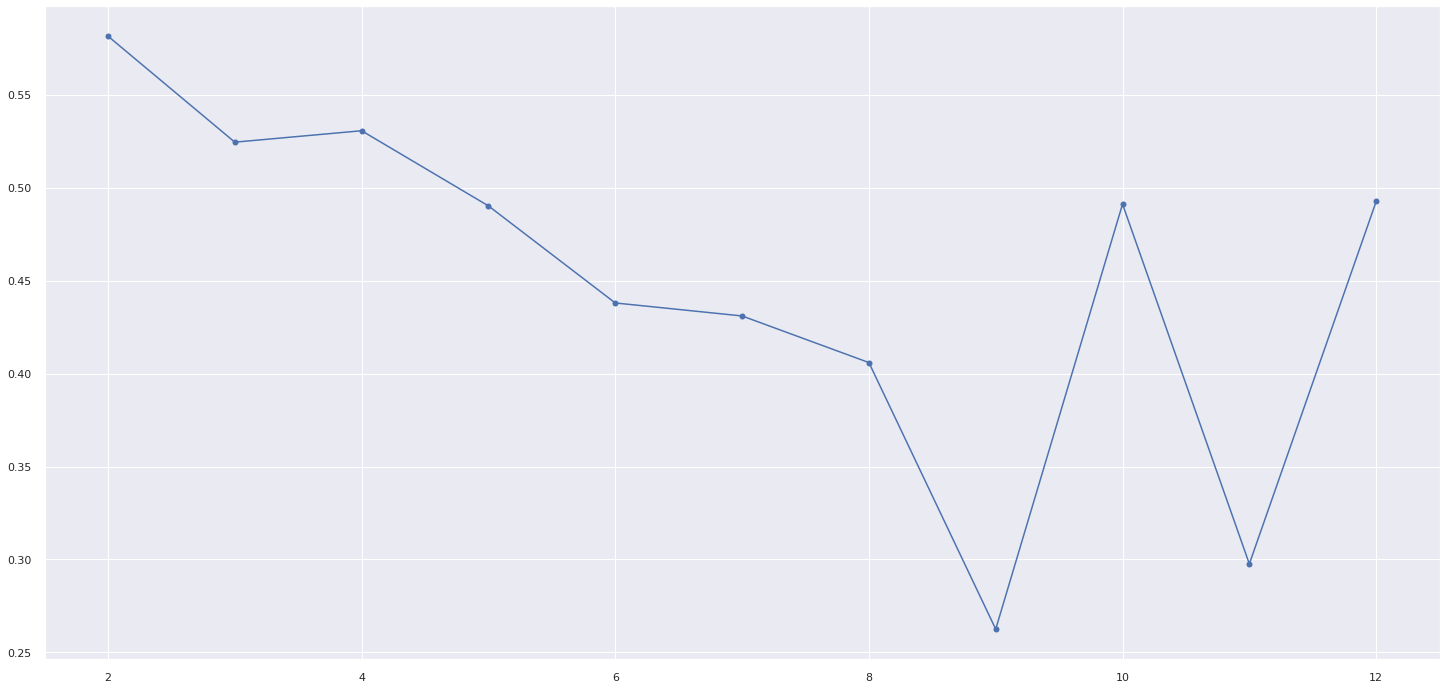

In [21]:
# Spectral
n_max = 12

# hyperparameters
affinity = 'rbf' # rbf, polynomial, poly, laplacian

spc_silhouette = []
for n_clusters in range(2, n_max + 1):
    # define model
    sp_model = SpectralClustering(n_clusters = n_clusters, random_state = 42, affinity = affinity, n_jobs = -1)
    
    # get labels
    labels = sp_model.fit_predict(df7)

    # metric
    sil = silhouette_score(df7, labels)
    spc_silhouette.append(sil)

# ploting silhouette
plt.plot( range(2, n_max + 1) , spc_silhouette, marker = 'o', color = 'b');

In [264]:
n_clusters = 12
affinity = 'rbf'
sp_model = SpectralClustering(n_clusters = n_clusters, random_state = 42, affinity = affinity, n_jobs = -1)
    
# get labels
labels = sp_model.fit_predict(df7)

# metric
sil = silhouette_score(df7, labels)
sil

0.4925401732463315

For n_clusters = 2 the average silhouette_score is : 0.5815
For n_clusters = 3 the average silhouette_score is : 0.5244
For n_clusters = 4 the average silhouette_score is : 0.5306
For n_clusters = 5 the average silhouette_score is : 0.4902
For n_clusters = 6 the average silhouette_score is : 0.4380
For n_clusters = 7 the average silhouette_score is : 0.4310


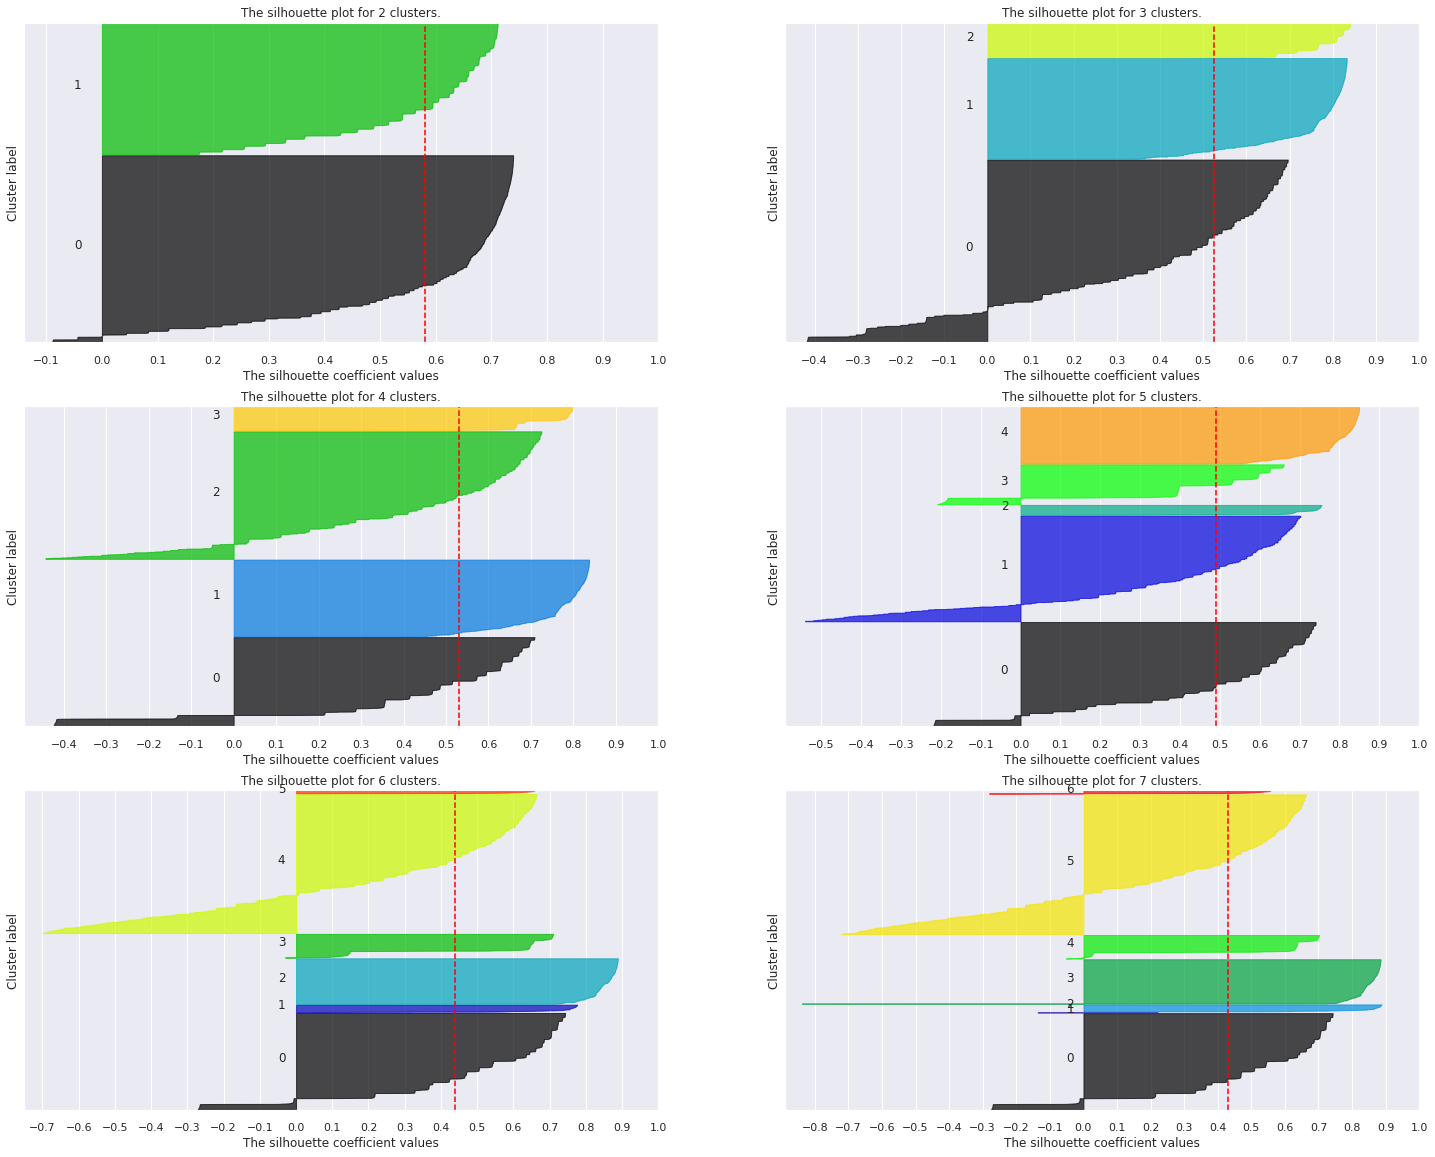

In [265]:
clusters = np.arange(2,8)

n_rows = math.ceil( len(clusters)/2 )
fig, ax = plt.subplots(n_rows, 2, figsize = (25,20) )

for idx, n_clusters in enumerate( clusters ):
    # defining model
    affinity = 'rbf'
    sp_model = SpectralClustering(n_clusters = n_clusters, random_state = 42, affinity = affinity, n_jobs = -1)
    
    labels = sp_model.fit_predict(df7)

    # ploting silhouette
    row, col = divmod(idx, 2)
    plot_silhouette( df7, labels, ax[row][col] )

plt.show()

For n_clusters = 8 the average silhouette_score is : 0.4059
For n_clusters = 9 the average silhouette_score is : 0.2625
For n_clusters = 10 the average silhouette_score is : 0.4911
For n_clusters = 11 the average silhouette_score is : 0.2976
For n_clusters = 12 the average silhouette_score is : 0.4925
For n_clusters = 13 the average silhouette_score is : 0.4412
For n_clusters = 14 the average silhouette_score is : 0.3639
For n_clusters = 15 the average silhouette_score is : 0.4674


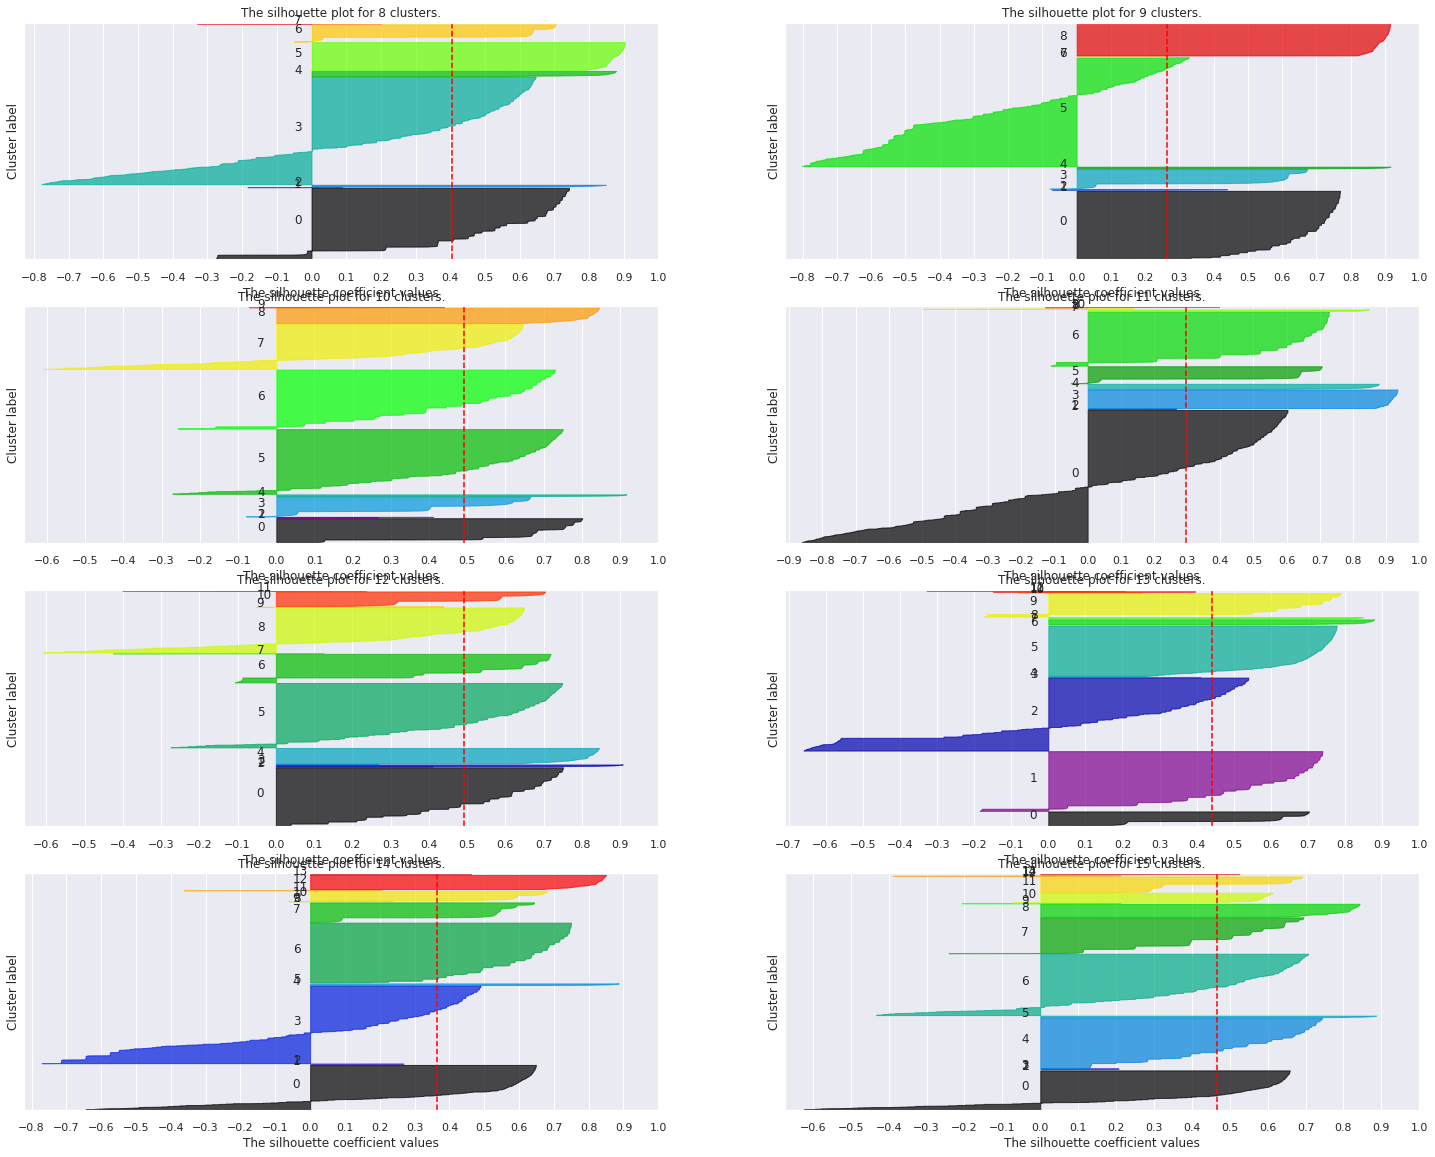

In [266]:
clusters = np.arange(8,16)

n_rows = math.ceil( len(clusters)/2 )
fig, ax = plt.subplots(n_rows, 2, figsize = (25,20) )

for idx, n_clusters in enumerate( clusters ):
    # defining model
    affinity = 'rbf'
    sp_model = SpectralClustering(n_clusters = n_clusters, random_state = 42, affinity = affinity, n_jobs = -1)
    
    labels = sp_model.fit_predict(df7)

    # ploting silhouette
    row, col = divmod(idx, 2)
    plot_silhouette( df7, labels, ax[row][col] )

plt.show()

### 7.5.2 Embedded Data

In [34]:
# rescaling df_tree using minmax in order to the spectral clustering algorithm work properly. 
# (The algorithm did not work with data on it's normal range, but worked on 0-1 range. May be due to the eigen_solver or rbf affinity)
pipe = make_pipeline( MinMaxScaler() )
df_tree_min_max = pd.DataFrame(pipe.fit_transform(df_tree))

sp_model = SpectralClustering(n_clusters = 5, random_state = 42, affinity = 'rbf')

# get labels
labels = sp_model.fit_predict(df_tree_min_max)

# metric
silhouette_score(df_tree_min_max, labels)

0.5172048

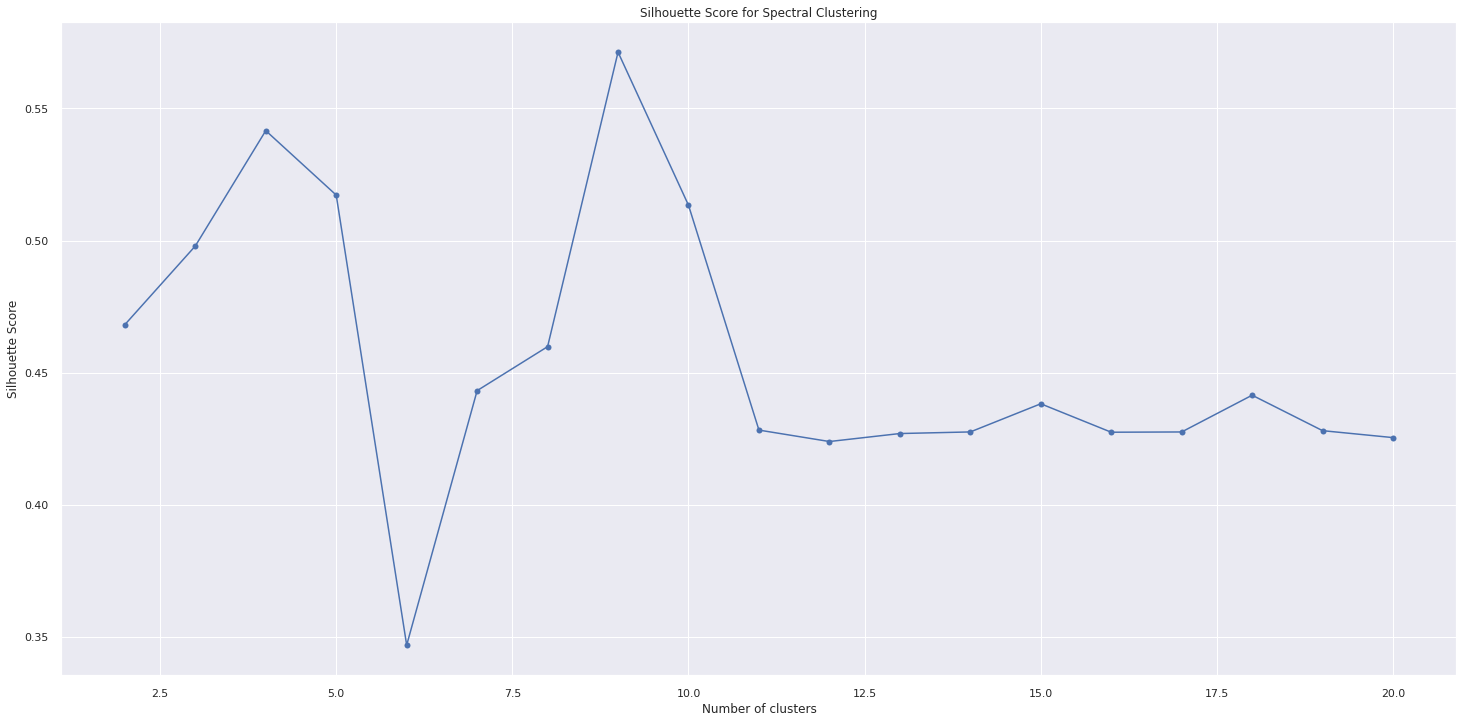

In [36]:
# Spectral
n_max = 20

# hyperparameters
affinity = 'rbf' # rbf, polynomial, poly, laplacian

spc_silhouette_emb = []
for n_clusters in range(2, n_max + 1):
    # define model
    sp_model = SpectralClustering(n_clusters = n_clusters, random_state = 42, affinity = affinity, n_jobs = -1)
    
    # get labels
    labels = sp_model.fit_predict(df_tree_min_max)

    # metric
    sil = silhouette_score(df_tree_min_max, labels)
    spc_silhouette_emb.append(sil)

# ploting silhouette
plt.title('Silhouette Score for Spectral Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
# plt.xticks( np.arange(2, n_max+1, 2) )
plt.plot( range(2, n_max + 1) , spc_silhouette_emb, marker = 'o', color = 'b');

In [40]:
n_clusters = 14

sp_model = SpectralClustering(n_clusters = n_clusters, random_state = 42, affinity = affinity, n_jobs = -1)

# get labels
labels = sp_model.fit_predict(df_tree_min_max)

# metric
sil = silhouette_score(df_tree_min_max, labels)

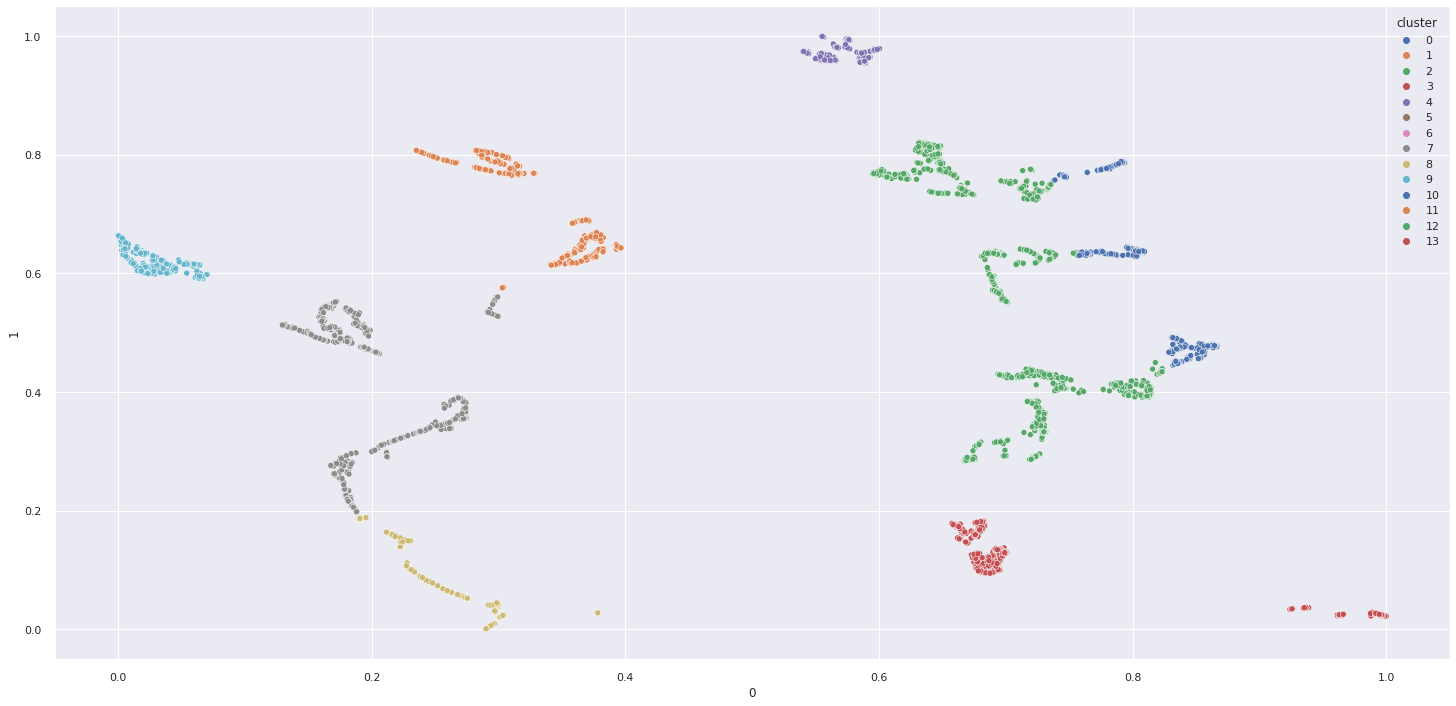

In [41]:
df_res = df_tree_min_max.copy()
df_res['cluster'] = labels

sns.scatterplot(data = df_res, x = 0, y = 1, hue = 'cluster', palette = 'deep');

## 7.6 Gaussian Mixture


### 7.6.1 Rescaled Data

In [267]:
# hyperparameters
n_components = 5
random_state = 42

# defining model
gm_model = GaussianMixture( n_components = n_components, random_state = random_state)
labels = gm_model.fit_predict(df7)

# Checking Performance
print( 'Silhouette Score: {:,.4f}'.format(silhouette_score(df7, labels)) )
print( 'Number of Clusters: {}'.format(len(np.unique(labels))) )

Silhouette Score: 0.0197
Number of Clusters: 5


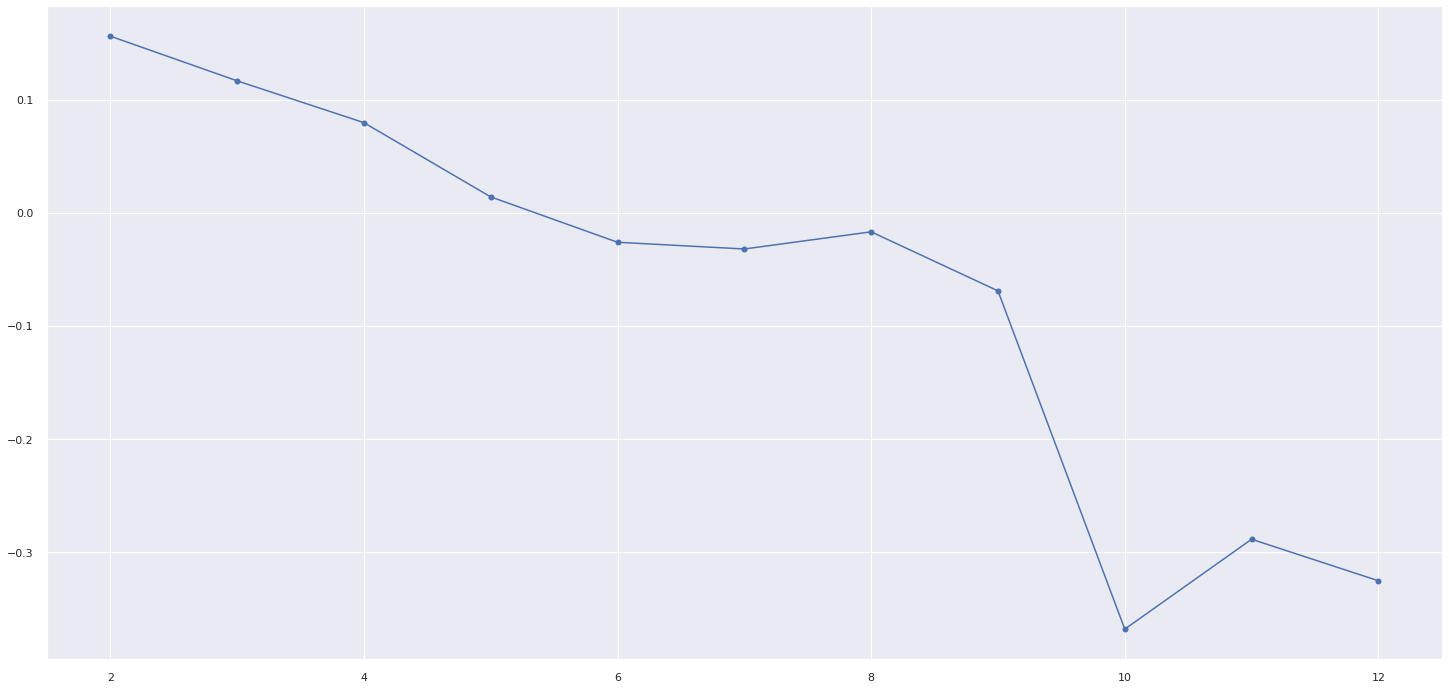

In [22]:
# GMM 
n_max = 12

gmm_silhouette = []
for n_components in range(2, n_max + 1):
    # define model
    gmm = GaussianMixture(n_components = n_components)
    # get labels
    labels = gmm.fit_predict(df7)

    # metric
    sil = silhouette_score(df7, labels)
    gmm_silhouette.append(sil)

# ploting silhouette
plt.plot( range(2, n_max + 1) , gmm_silhouette, marker = 'o', color = 'b');

For n_clusters = 2 the average silhouette_score is : 0.1561
For n_clusters = 3 the average silhouette_score is : 0.1166
For n_clusters = 4 the average silhouette_score is : 0.0427
For n_clusters = 5 the average silhouette_score is : 0.0197
For n_clusters = 6 the average silhouette_score is : -0.0262
For n_clusters = 7 the average silhouette_score is : -0.0232


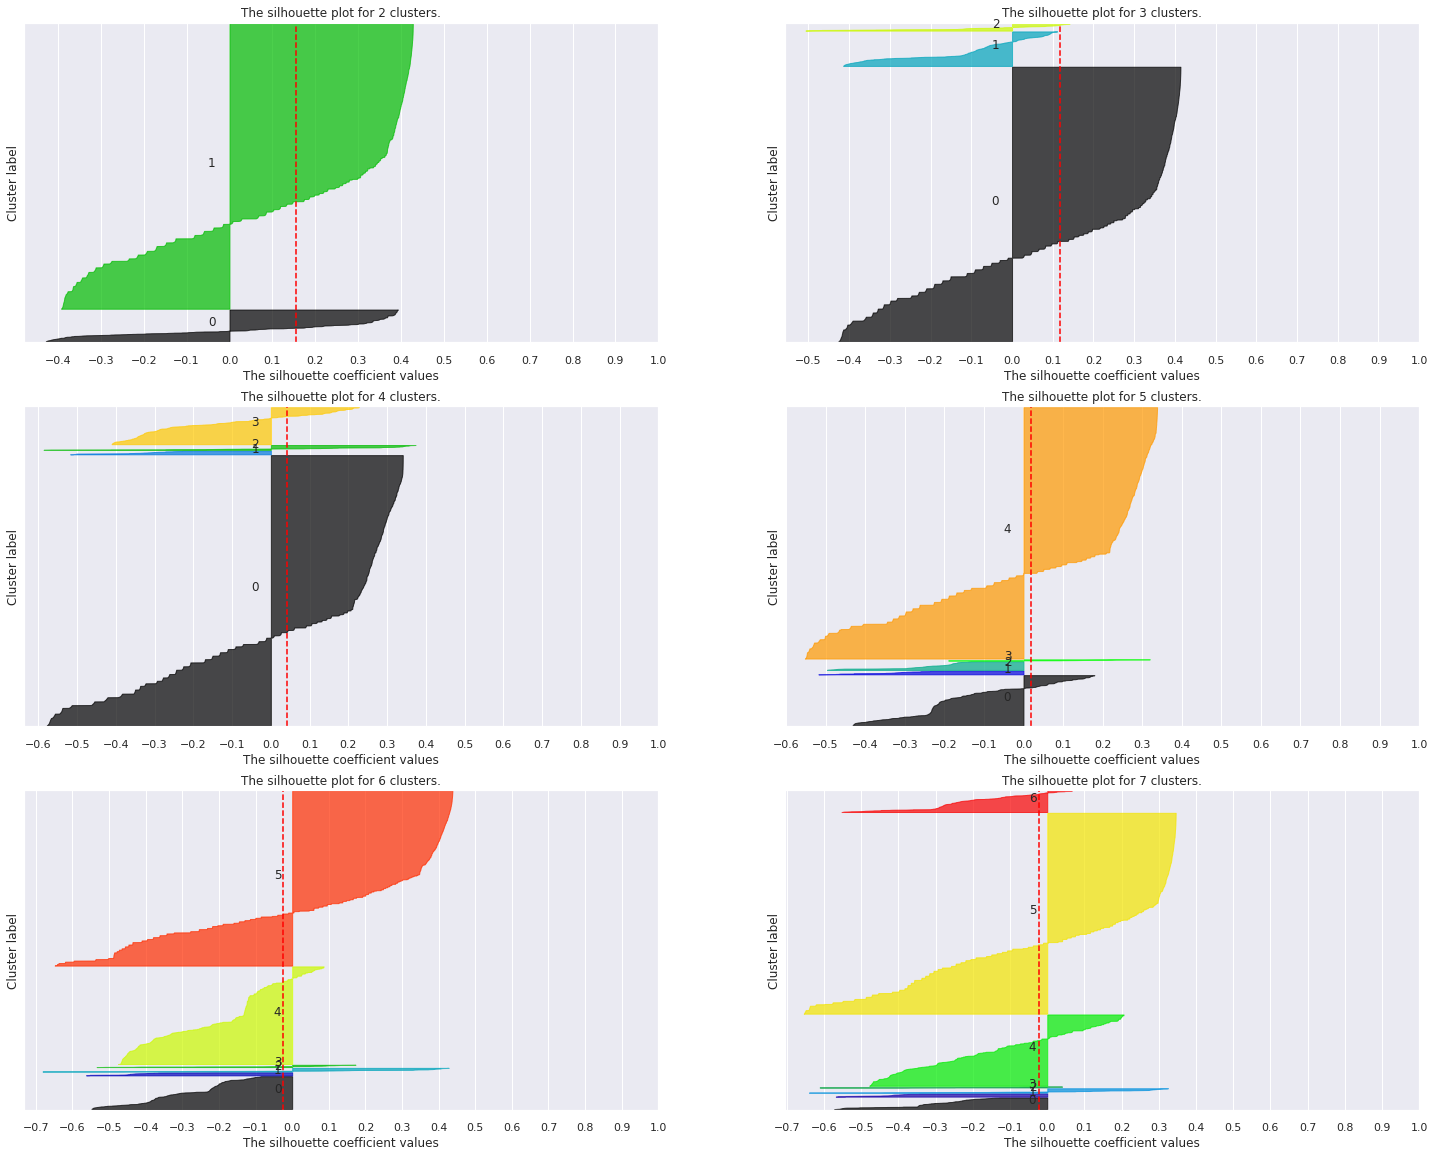

In [269]:
# Taking a look at the results with our personalized function

clusters = np.arange(2,8)

# setting number of rows and defining a subplots instance
n_rows = math.ceil( len(clusters)/2 )
figg, ax = plt.subplots(n_rows, 2, figsize = (25,20))

for idx, n_clusters in enumerate(clusters):

    clusterer = GaussianMixture(n_components=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(df7)

    # since we are using 2 + figures subplots returns a 2d axes list (matrix)
    row, col = divmod(idx, 2)
    plot_silhouette(df7, cluster_labels, ax[row][col] )
    

For n_clusters = 8 the average silhouette_score is : -0.0118
For n_clusters = 9 the average silhouette_score is : -0.2224
For n_clusters = 10 the average silhouette_score is : -0.1431
For n_clusters = 11 the average silhouette_score is : -0.1371
For n_clusters = 12 the average silhouette_score is : -0.2024
For n_clusters = 13 the average silhouette_score is : -0.1716


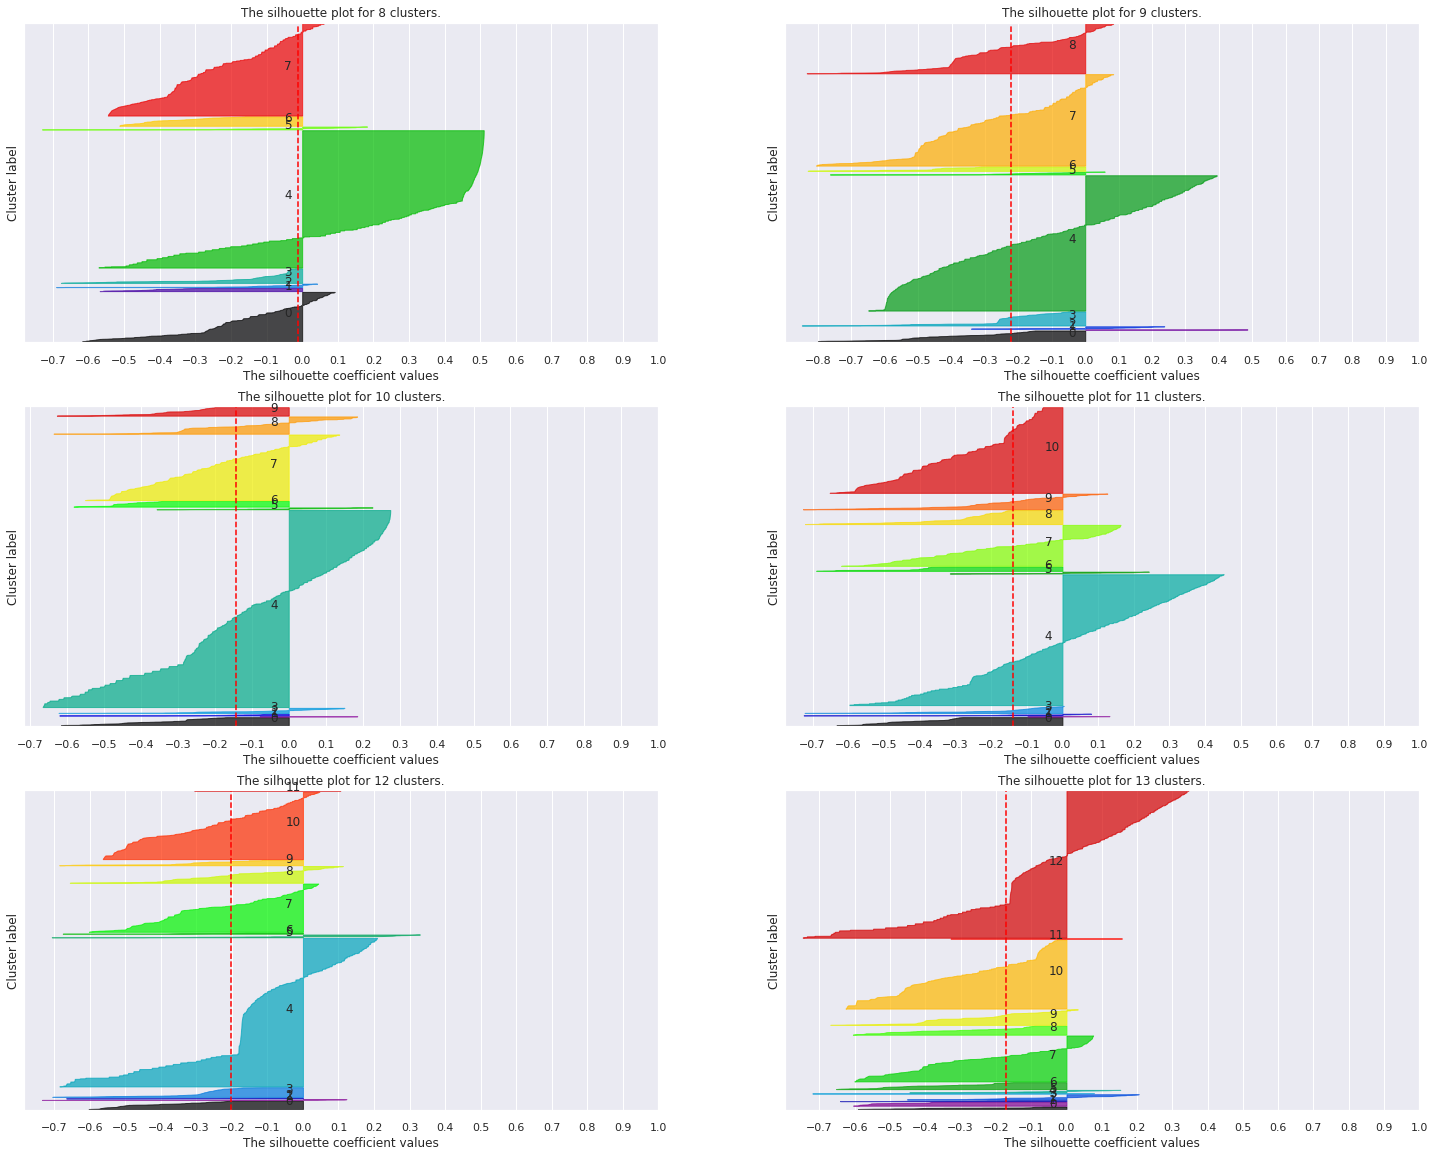

In [270]:
# Taking a look at the results with our personalized function

clusters = np.arange(8,14)

# setting number of rows and defining a subplots instance
n_rows = math.ceil( len(clusters)/2 )
figg, ax = plt.subplots(n_rows, 2, figsize = (25,20))

for idx, n_clusters in enumerate(clusters):

    clusterer = GaussianMixture(n_components=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(df7)

    # since we are using 2 + figures subplots returns a 2d axes list (matrix)
    row, col = divmod(idx, 2)
    plot_silhouette(df7, cluster_labels, ax[row][col] )
    

### 7.6.2 Embedded Data

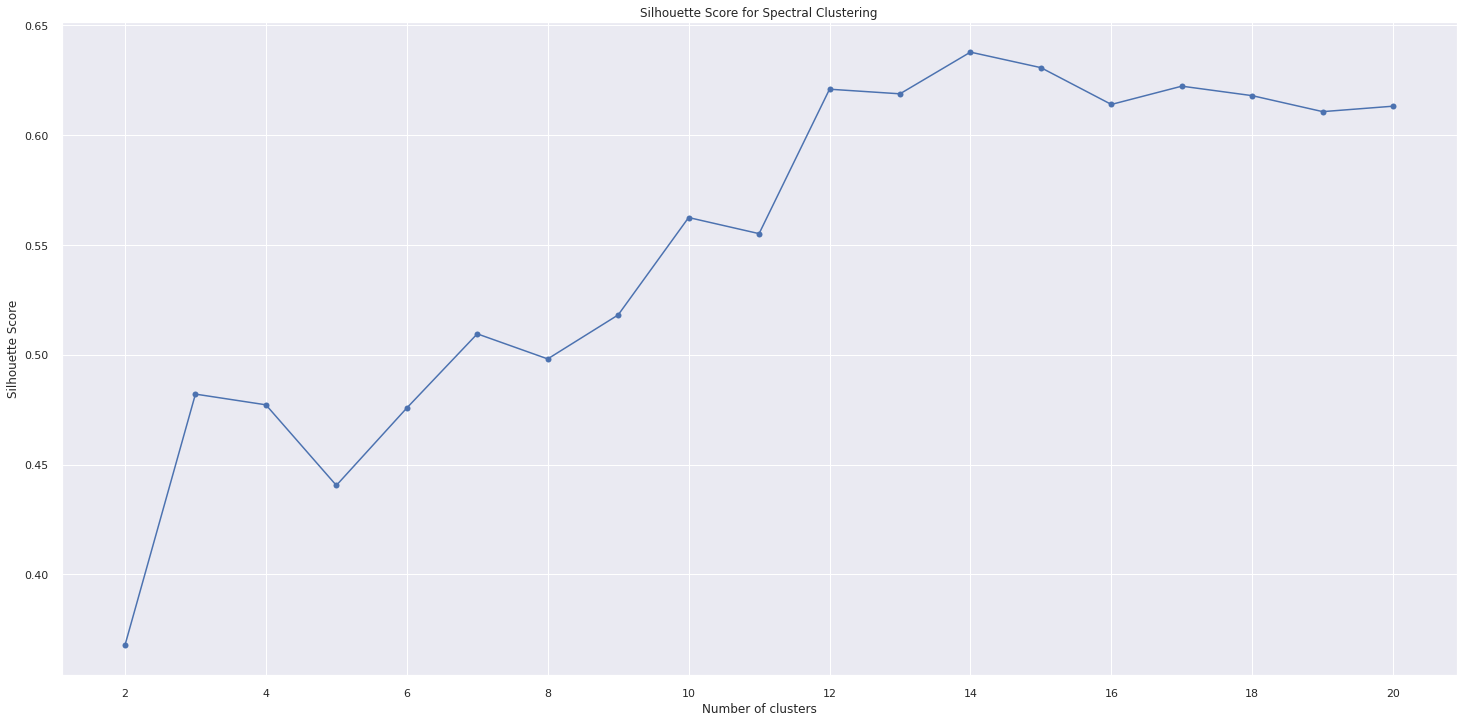

In [57]:
# Gaussian Mixture
n_max = 20

# hyperparameters

gmm_silhouette_emb = []
for n_clusters in range(2, n_max + 1):
    # define model
    sp_model = GaussianMixture(n_components= n_clusters, random_state = 42)
    
    # get labels
    labels = sp_model.fit_predict(df_tree_min_max)

    # metric
    sil = silhouette_score(df_tree_min_max, labels)
    gmm_silhouette_emb.append(sil)

# ploting silhouette
plt.title('Silhouette Score for Spectral Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks( np.arange(2, n_max+1, 2) )
plt.plot( range(2, n_max + 1) , gmm_silhouette_emb, marker = 'o', color = 'b');

In [271]:
# hyperparameters
n_components = 14

# defining model
gm_model = GaussianMixture( n_components = n_components, random_state = 42)
labels = gm_model.fit_predict(df_tree_min_max)

# Checking Performance
print( 'Silhouette Score: {:,.4f}'.format(silhouette_score(df_tree_min_max, labels)) )
print( 'Number of Clusters: {}'.format(len(np.unique(labels))) )

Silhouette Score: 0.6378
Number of Clusters: 14


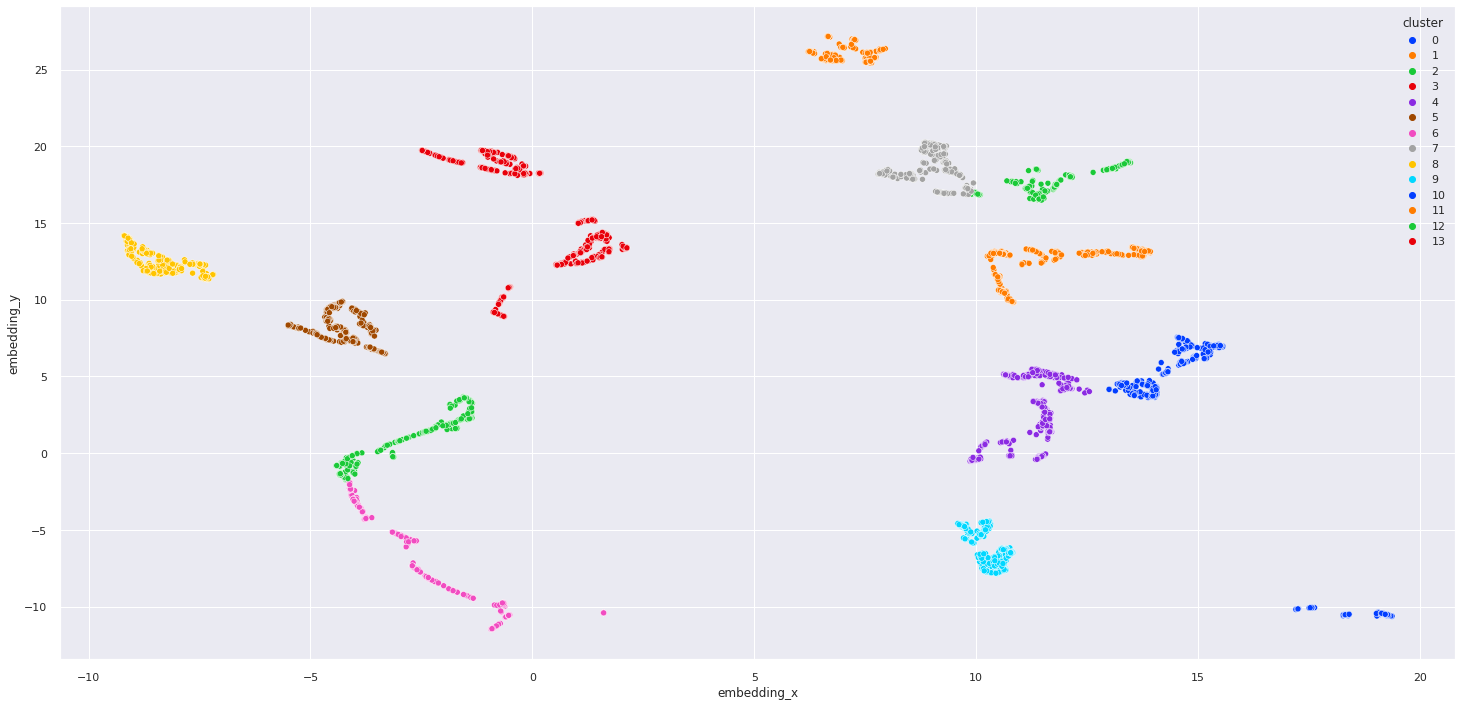

In [272]:
df_res = df_tree.copy()
df_res['cluster'] = labels

sns.scatterplot(data = df_res, x = 'embedding_x', y = 'embedding_y', hue = 'cluster', palette = 'bright');

## 7.7 Comparing Model's Performances

### 7.7.1 Rescaled Data

In [23]:
results = pd.DataFrame( { 'KMeans' : kmeans_silhouette,
                        #   'DBScan' : dbscan_silhouette,
                          'GMM' : gmm_silhouette,
                          'HC' : hc_silhouette,
                          'Spectral' : spc_silhouette } )
          
results = results.T
results.style.highlight_max( color='blue', axis=1 )

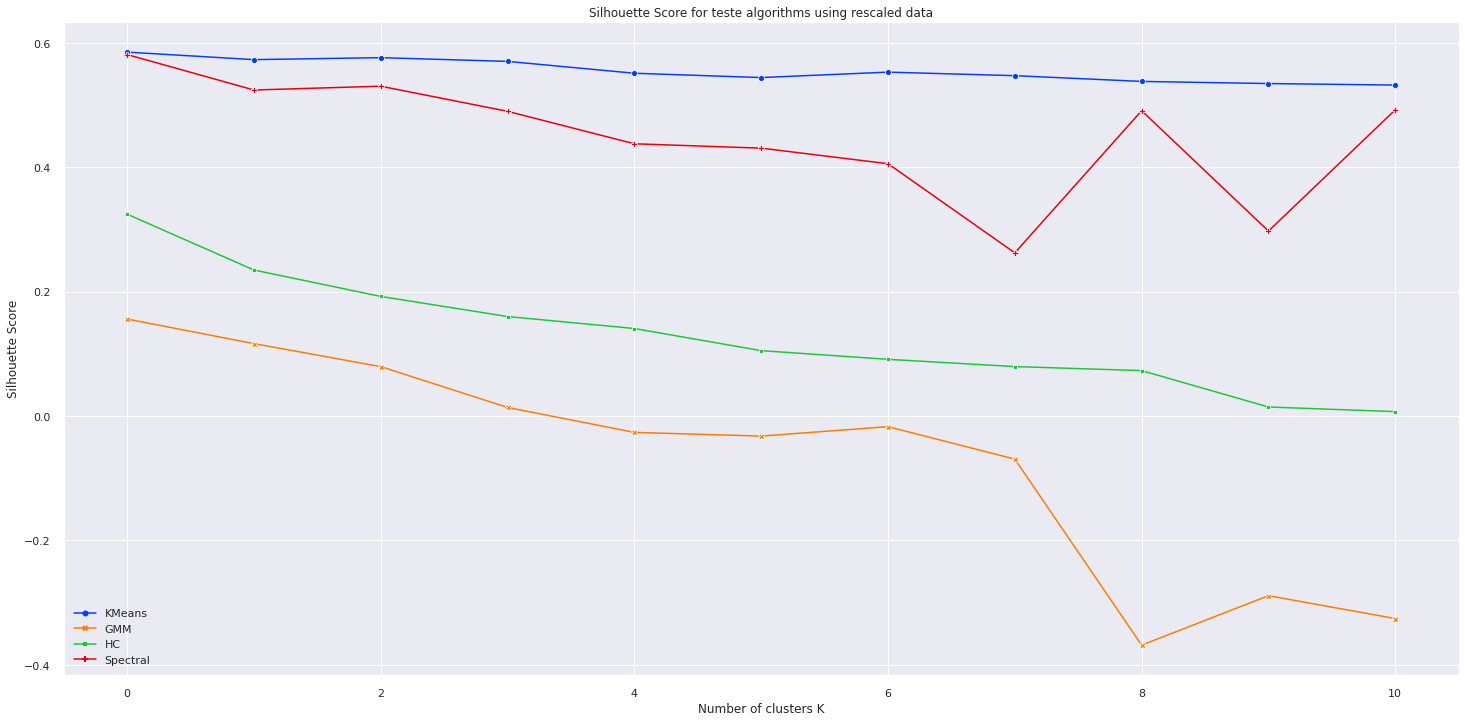

In [62]:
plt.title('Silhouette Score for teste algorithms using rescaled data')
plt.xlabel('Number of clusters K')
plt.ylabel('Silhouette Score')
sns.lineplot(data = results.T, markers = True, palette = 'bright', dashes = False);
# sns.relplot(data = results.T, palette = 'bright', dashes = False);


### 7.7.2 Embedded Data

In [274]:
results_emb = pd.DataFrame( { 'KMeans' : kmeans_silhouette_emb,
                          'DBScan' : db_silhouette_emb,
                          'GMM' : gmm_silhouette_emb,
                          'HC' : hc_silhouette_emb,
                          'Spectral' : spc_silhouette_emb } )
results_emb = results_emb.set_axis(np.arange(2,21, 1) )          
results_emb = results_emb.T
results_emb.style.highlight_max( color='blue', axis=1 )

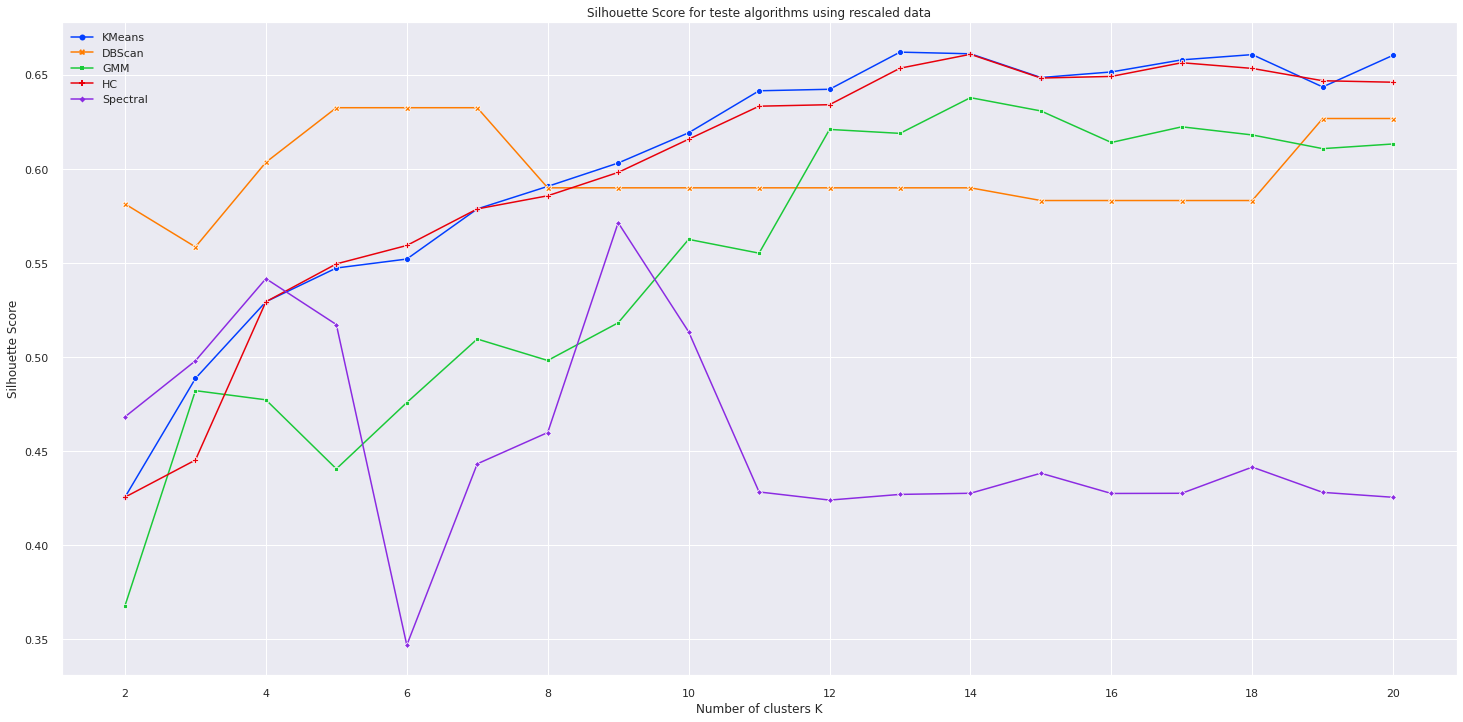

In [275]:
plt.title('Silhouette Score for teste algorithms using rescaled data')
plt.xlabel('Number of clusters K')
plt.ylabel('Silhouette Score')
plt.xticks(np.arange(2,21, 2))
sns.lineplot(data = results_emb.T, markers = True, palette = 'bright', dashes = False);
# sns.relplot(data = results.T, palette = 'bright', dashes = False);

# sidenote: DBSCAN xaxis is not number of clusters, but eps. I just ploted it this way to compare silhouette coefficient.


## Final thoughts on the used algorithms
KMEANS, Hierarchical Clustering, and GMM performed well in terms of silhouette coefficient however they did not separate clusters well.

Regarding KMEANS and Gaussian Mixture it happened probably because clusters are not spherical, nor form clear Gaussians.

Spectral Clustering should have performed well since it relies on connections between data points and not their shape however, the algorithm was very slow and I couldn't afford the time to tune it properly.

Finally, DBSCAN was the best algorithm concerning proper cluster separation (even though its silhouette score was a bit lower than that of its pairs because silhouette coefficient is negatively affected by non-spherical clusters). I believe this algorithm performed well, given that it works based on densities no matter the form of the clusters.

# 8.0 Model Training

In [9]:
# selecting data
df8 = df_tree.copy()

df_result = df5.copy()
df_result = pd.concat( [df_result, df_tree], axis = 1 )

In [10]:
# defining model
db_model = DBSCAN(eps = 2.3, min_samples=5)

# predicting cluster labels
labels = db_model.fit_predict(df_tree)

# storing labels on auxiliar dataset
df_result['cluster'] = labels.astype(str)

# sns.scatterplot(data = df_res, x = 'embedding_x', y = 'embedding_y', hue = 'cluster', palette = 'bright');

# 9.0 Cluster Analysis

## 9.1 Visual Inspection - Metrics

In [43]:
# Evaluating Silhouette Score
silhouette_score(df_tree, labels)

0.6267377

For n_clusters = 11 the average silhouette_score is : 0.6267


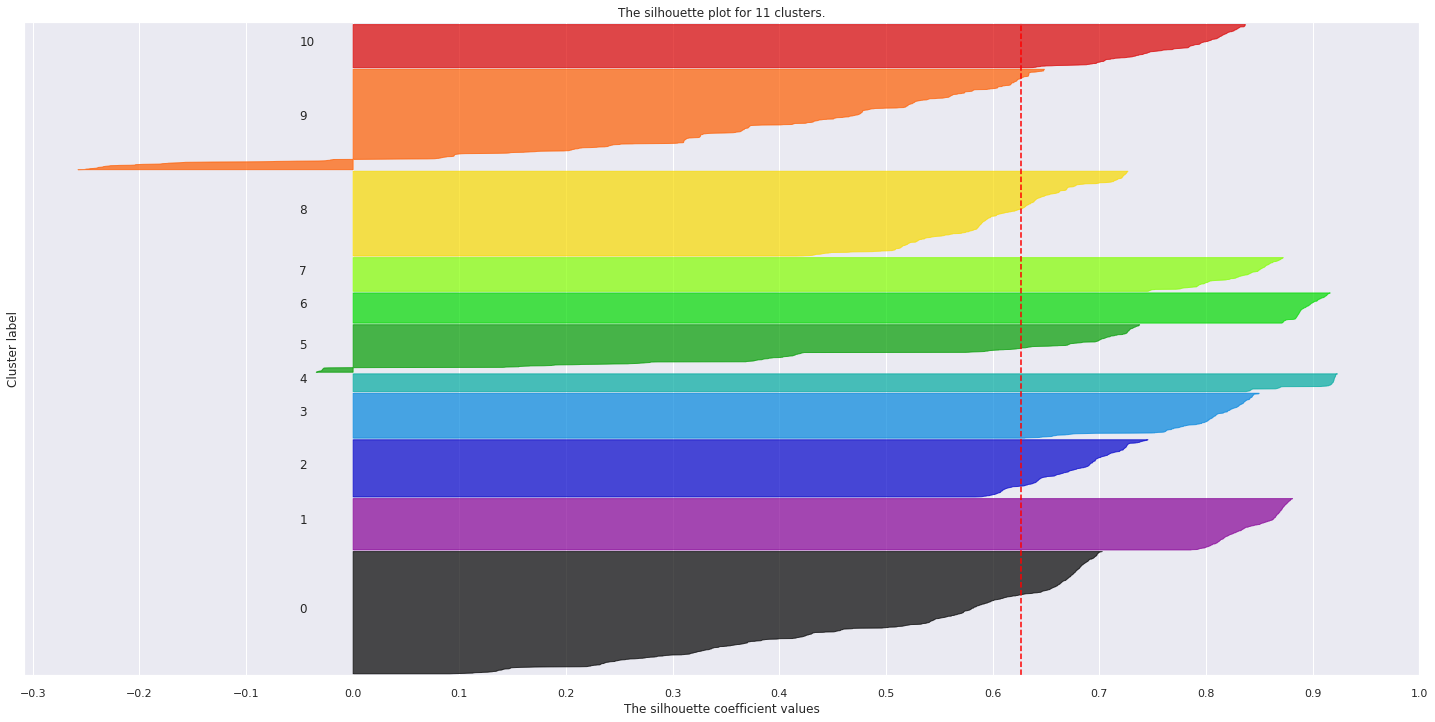

In [45]:
plot_silhouette(df_tree, labels);

## 9.2 Pairploting Features

In [51]:
# columns from pipeline
# cols = ['recency', 'num_transactions', 'frequency', 'revenue', 'avg_ticket', 'num_returns', 'date_range', 'return_revenue', 'avg_return_revenue', 'country']

# df_viz = pd.DataFrame(df_prep, columns = cols)
df_viz = pd.DataFrame(df_prep)

df_viz['cluster'] = labels
# df_viz.head()

In [47]:
# sns.pairplot(data = df_viz, hue = 'cluster' );

## 9.3 Visual Inspection - UMAP

In [28]:
px.scatter(data_frame = df_aux, x = 'embedding_x', y = 'embedding_y', color = 'cluster', hover_data=['revenue', 'num_purchases', 'avg_ticket', 'qty_items'])

## 9.4 Business Perspective

In [11]:
# number of customers per cluster
n_cust = df_result.copy()
n_cust = n_cust.groupby('cluster').count().reset_index().rename(columns = {'customer_id' : 'num_of_customers'})
n_cust['perc_of_customer'] = n_cust['num_of_customers']/n_cust['num_of_customers'].sum()*100
n_cust = n_cust[['cluster', 'num_of_customers', 'perc_of_customer']]

In [12]:
# calculating mean values for each cluster attribute

df_res = df_result.copy()

# calculating mothly frequency
df_res['frequency'] = df_res['frequency']*30

# add cluster to df
# df_res =pd.concat( [df_res, pd.DataFrame( { 'cluster' : labels} ) ], axis = 1 )
result = df_res.groupby('cluster').mean().reset_index()
result

# add nº of customers
result = result.merge( n_cust, on = 'cluster', how = 'inner')
result = result[['cluster', 'num_of_customers', 'perc_of_customer', 'num_purchases', 'date_range', 'frequency', 'recency', 'revenue', 'avg_ticket', 'num_returns', 'avg_return_revenue' ]]

# converting cluster to int to sort it
result['cluster'] = result['cluster'].astype(int)
result.sort_values('revenue', ascending = False )

cluster  num_of_customers  perc_of_customer  num_purchases  date_range  frequency     recency       revenue   avg_ticket  num_returns  avg_return_revenue
5         4               122          2.828002      28.319672  315.704918   4.216134   19.893443  26919.612541  1190.967567    16.393443         -105.774531
1         1               350          8.113120      10.774286  283.831429   1.304213   29.420000   4807.843571   663.648830     5.745714          -15.990815
0         0               832         19.286045       5.933894  231.454327   2.220941   44.183894   2081.876791   447.670658     2.514423          -10.809519
3         2               390          9.040334       4.410256  199.241026   1.159664   54.907692   1229.507103   358.422533     1.733333          -10.260330
9         8               577         13.375058       2.024263  135.192374   1.332675   93.417678    777.658839   440.048120     0.741768           -4.978410
7         6               206          4.775151       3.713592  183.577670   1.475518   69.383495    604.851311   168.244465     1.844660           -9.237072
8         7               230          5.331479       2.000000  129.313043   1.687273   90.582609    481.550435   240.775217     0.521739           -2.857373
6         5               324          7.510431       1.000000  139.441358   0.677090  139.441358    396.901204   396.901204     0.311728           -1.982865
2        10               294          6.815021       1.095238  162.758503   0.585821  165.180272    379.410000   348.322347     0.397959           -2.766372
4         3               306          7.093185       2.526144  144.503268   2.010196  101.297386    300.953072   123.893084     0.575163           -8.796140
10        9               683         15.832174       1.000000  170.915081   0.597938  170.915081    144.615608   144.615608     0.194729           -1.444912

In [32]:
# Generating a report of some attributes for each cluster

# ordering by cluster
result = result.sort_values('cluster').reset_index(drop = True)

for i in range( len(np.unique(labels)) ):
    print('Cluster {}'.format(result.loc[i, 'cluster']))
    print(' - Number of customers {} ({:,.2f} % of total)'.format(result.loc[i, 'num_of_customers'], result.loc[i, 'perc_of_customer']) )
    print(' - Average nº of purchases: {:.2f} '.format(result.loc[i, 'num_purchases']) )
    print(' - Average amount spent in total ${:,.2f} '.format(result.loc[i, 'revenue']) )
    print(' - Mean values for average ticket ${:,.2f} '.format(result.loc[i, 'avg_ticket']) )
    print(' - Average Recency (days) {:,.2f} \n'.format(result.loc[i, 'recency']) )

Cluster 0
 - Number of customers 832 (19.29 % of total)
 - Average nº of purchases: 5.93 
 - Average amount spent in total $2,081.88 
 - Mean values for average ticket $447.67 
 - Average Recency (days) 44.18 

Cluster 1
 - Number of customers 350 (8.11 % of total)
 - Average nº of purchases: 10.77 
 - Average amount spent in total $4,807.84 
 - Mean values for average ticket $663.65 
 - Average Recency (days) 29.42 

Cluster 2
 - Number of customers 390 (9.04 % of total)
 - Average nº of purchases: 4.41 
 - Average amount spent in total $1,229.51 
 - Mean values for average ticket $358.42 
 - Average Recency (days) 54.91 

Cluster 3
 - Number of customers 306 (7.09 % of total)
 - Average nº of purchases: 2.53 
 - Average amount spent in total $300.95 
 - Mean values for average ticket $123.89 
 - Average Recency (days) 101.30 

Cluster 4
 - Number of customers 122 (2.83 % of total)
 - Average nº of purchases: 28.32 
 - Average amount spent in total $26,919.61 
 - Mean values for avera

In [ ]:
# Based on the RFM Analysis I gave names to clusters 

px_result = result.copy()
px_result['recency'] = - px_result['recency'] 

# cluster names dict
names = {4 : "Insiders",
         1 : "Potential Loyalists",
         0 : "Loyal Customers",
         2 : "Promissing",
         8 : "Need Attention",
         6 : "Promising",
         7 : "Need Attention",
         5 : "Hibernating 1",
         10 : "Hibernating 2",
         3 : "Price Sensitive",
         9 : "Churn"}

px_result['cluster_names'] = px_result['cluster'].map(names)
px_result['log_revenue'] = np.log10(px_result['revenue'])

px.scatter(data_frame = px_result, x = 'recency', y = 'frequency', size = 'log_revenue', color = 'cluster_names', hover_data=['revenue']) #, hover_data=['revenue', 'num_purchases', 'avg_ticket', 'qty_items']

| Cluster | Name | Action Plan  |
|-|-|-|
| 4 | Insiders | Keep engaged, offer concierge  |
| 1 | Potential Loyalists | Increase purchase frequency  |
| 0 | Loyal Customers | Increase average ticket  |
| 2 | Promissing | Increase Frequency  |
| 8 | Need Attention | Decrease recency  |
| 6 | Promising | Increase avg ticket  |
| 7 | Need Attention | Increase Revenue |
| 5 | Hibernating 1| Make them buy again |
| 10 | Hibernating  2|Make them buy again |
| 3 | Price Sensitive | Increase avg ticket |
| 9 | Churn | Do nothing |

In [36]:

px_result = result.copy()
px_result['recency'] = - px_result['recency'] 
names = {4 : "Insiders",
1 : "Potential Loyalists",
0 : "Loyal Customers",
2 : "Promissing",
8 : "Need Attention",
6 : "Promising",
7 : "Need Attention",
5 : "Hibernating 1",
10 : "Hibernating 2",
3 : "Price Sensitive",
9 : "Churn"}
px_result['names'] = px_result['cluster'].map(names)
px_result


cluster  num_of_customers  perc_of_customer  num_purchases  date_range  frequency     recency       revenue   avg_ticket  num_returns  avg_return_revenue                names
0         0               832         19.286045       5.933894  231.454327   2.220941  -44.183894   2081.876791   447.670658     2.514423          -10.809519      Loyal Customers
1         1               350          8.113120      10.774286  283.831429   1.304213  -29.420000   4807.843571   663.648830     5.745714          -15.990815  Potential Loyalists
2         2               390          9.040334       4.410256  199.241026   1.159664  -54.907692   1229.507103   358.422533     1.733333          -10.260330           Promissing
3         3               306          7.093185       2.526144  144.503268   2.010196 -101.297386    300.953072   123.893084     0.575163           -8.796140      Price Sensitive
4         4               122          2.828002      28.319672  315.704918   4.216134  -19.893443  26919.612541  1190.967567    16.393443         -105.774531             Insiders
5         5               324          7.510431       1.000000  139.441358   0.677090 -139.441358    396.901204   396.901204     0.311728           -1.982865          Hibernating
6         6               206          4.775151       3.713592  183.577670   1.475518  -69.383495    604.851311   168.244465     1.844660           -9.237072            Promising
7         7               230          5.331479       2.000000  129.313043   1.687273  -90.582609    481.550435   240.775217     0.521739           -2.857373       Need Attention
8         8               577         13.375058       2.024263  135.192374   1.332675  -93.417678    777.658839   440.048120     0.741768           -4.978410       Need Attention
9         9               683         15.832174       1.000000  170.915081   0.597938 -170.915081    144.615608   144.615608     0.194729           -1.444912                Churn
10       10               294          6.815021       1.095238  162.758503   0.585821 -165.180272    379.410000   348.322347     0.397959           -2.766372          Hibernating

# 10 Cluster EDA and Business Hypothesis/Insights

## 10.1. Hypothesis Mind Map

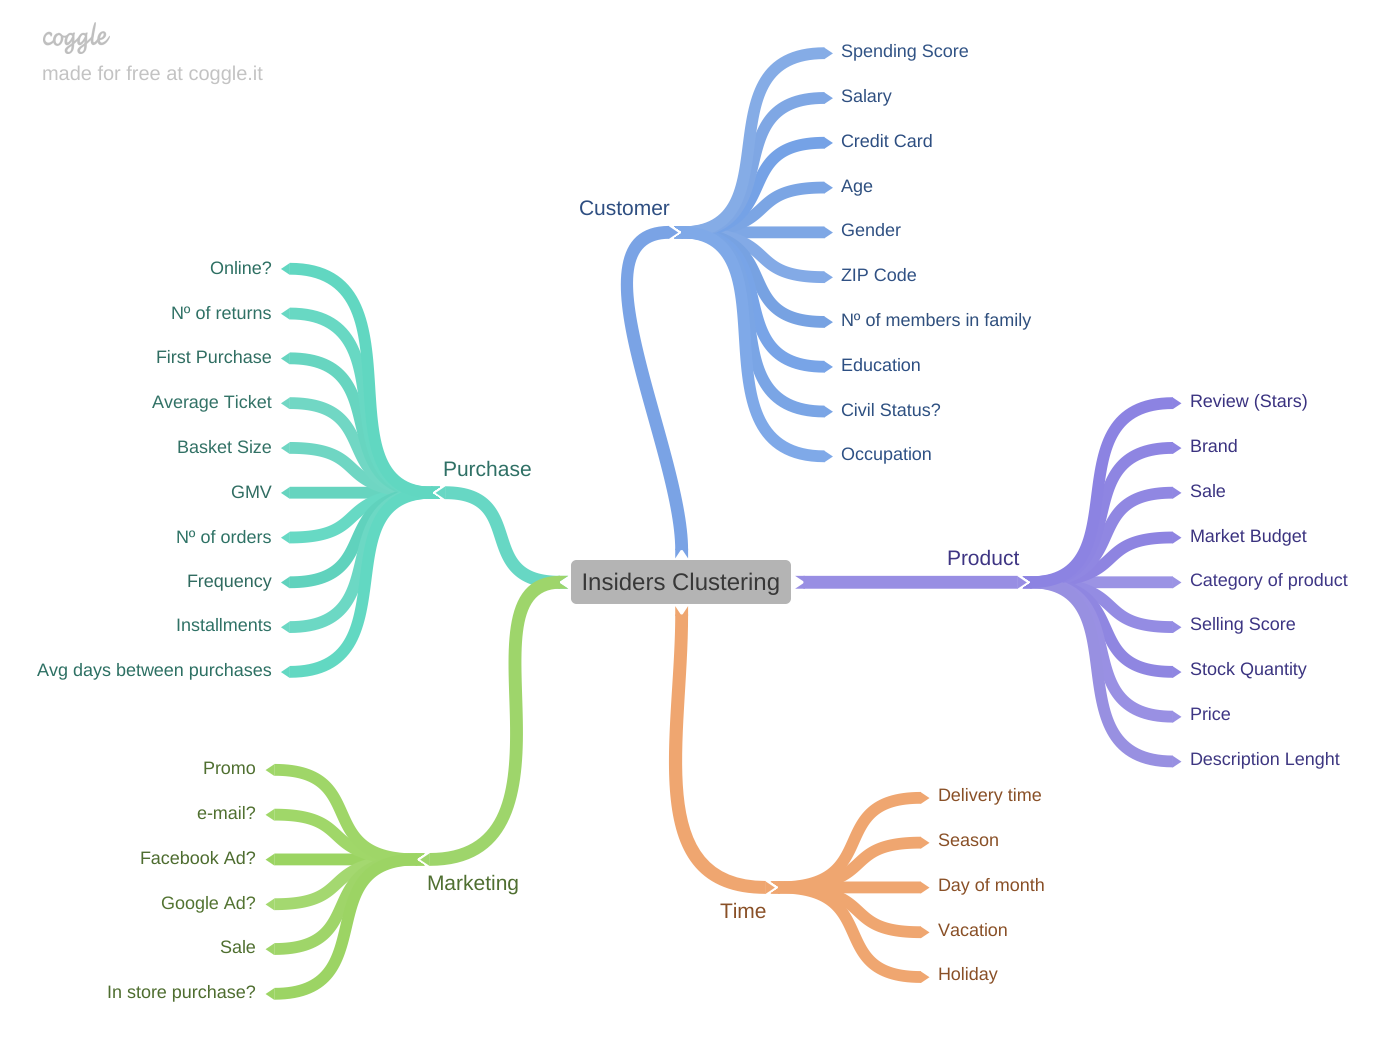

In [84]:
Image('../reports/figures/Insiders_Clustering.png')

## 10.2. Business Hypothesis

Business Hypothesis:
- Customers who buy more products return less
- **Return rates are higher than average for cheaper products**
- Customers with higher basket sizes buy less products in quantity
- **Customers buy more near holidays**
- **Customers buy more on the first half of the month**
- **Customers from Insiders Program are responsible for 20% of revenue**
- **Customers from Insiders Program buy a 30% more products in quantity than the average customer**

### H1- Return rates are higher than average for cheaper products
**False** There is no evidence to support there is difference in return rates with respect to different prices.

The only evidence we have is a weak positive correlation which indicates the oposite.

In [11]:
# creating some auxiliary dataset

# counting number of times a product was returned
df_aux1 = df_returns.copy()
df_aux1 = df_aux1.groupby('stock_code').count().reset_index()[['stock_code', 'quantity']].copy()

# geting unit price
df_aux2 = df_returns[['stock_code', 'unit_price']].copy()
df_aux2 = df_aux2.drop_duplicates('stock_code')

# merging results
df_aux3 = pd.merge( left = df_aux1, right = df_aux2, on = 'stock_code', how = 'left' )
df_aux3.rename(columns = {'quantity': 'quantity returned'}, inplace = True)
df_aux3['avg'] = df_aux3['unit_price'].apply( lambda x: 'above' if x > df_aux3['unit_price'].mean() else 'below')
df_aux3['median'] = pd.qcut( df_aux3['unit_price'], q = 2, labels = ['below', 'above'] )
# df_aux3.head()

The Spearman correlation coefficient is: 0.2232
The associated p-value is: 0.0000


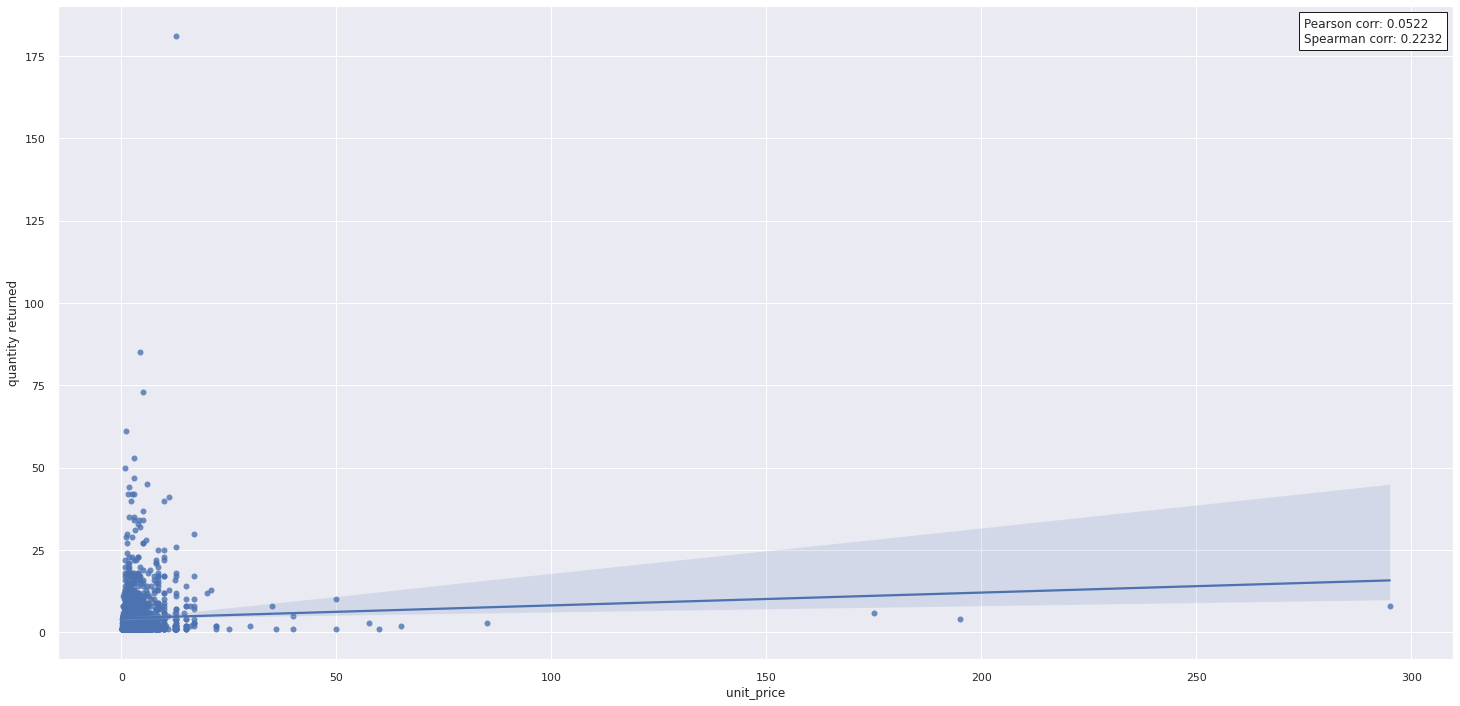

In [31]:
# ploting correlation between price and n/returns
fig, ax = plt.subplots()
sns.regplot(data = df_aux3, y = 'quantity returned', x = 'unit_price', ax = ax); # default ci = 95

# correlations
pearson = df_aux3.corr(method = 'pearson').iloc[0,1]
spearman = df_aux3.corr(method = 'spearman').iloc[0,1]

anchored_text = AnchoredText( "Pearson corr: {:.4f} \nSpearman corr: {:.4f}".format(pearson, spearman), loc=1)
ax.add_artist(anchored_text);

# calculatin p-value for the Spearman correlation coefficient
_, p_value = st.spearmanr(x, y)
print('The Spearman correlation coefficient is: {:.4f}\nThe associated p-value is: {:.4f}'.format(spearman, p_value) )

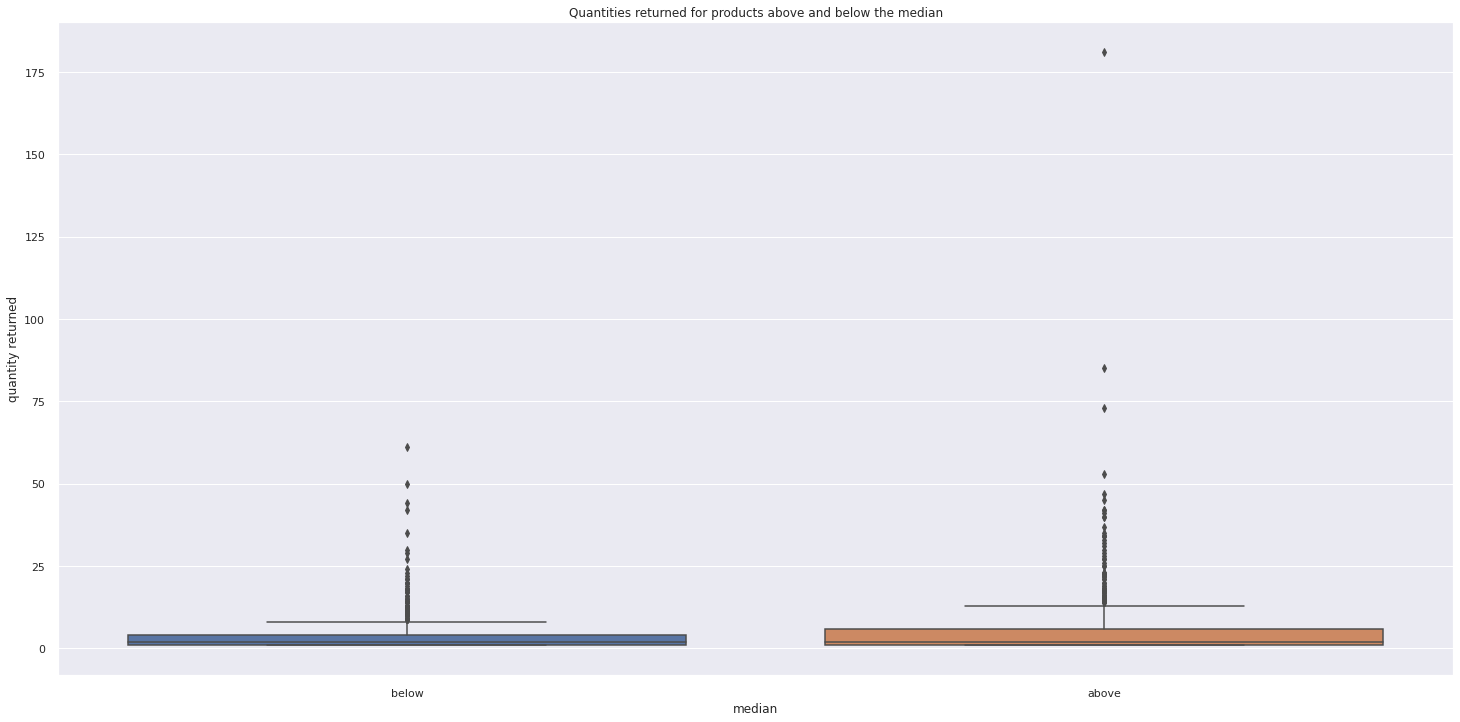

In [32]:
plt.title('Quantities returned for products above and below the median')
sns.boxplot(data = df_aux3, y = 'quantity returned', x = 'median', showfliers = True);

### H2 - Customers who buy more items are the ones that return return less
**False** One of the highest return rates are from "promissing" and "price sensitive" customers. Even though, in absolute terms, this hypothesis would be true for "Insiders" customers.


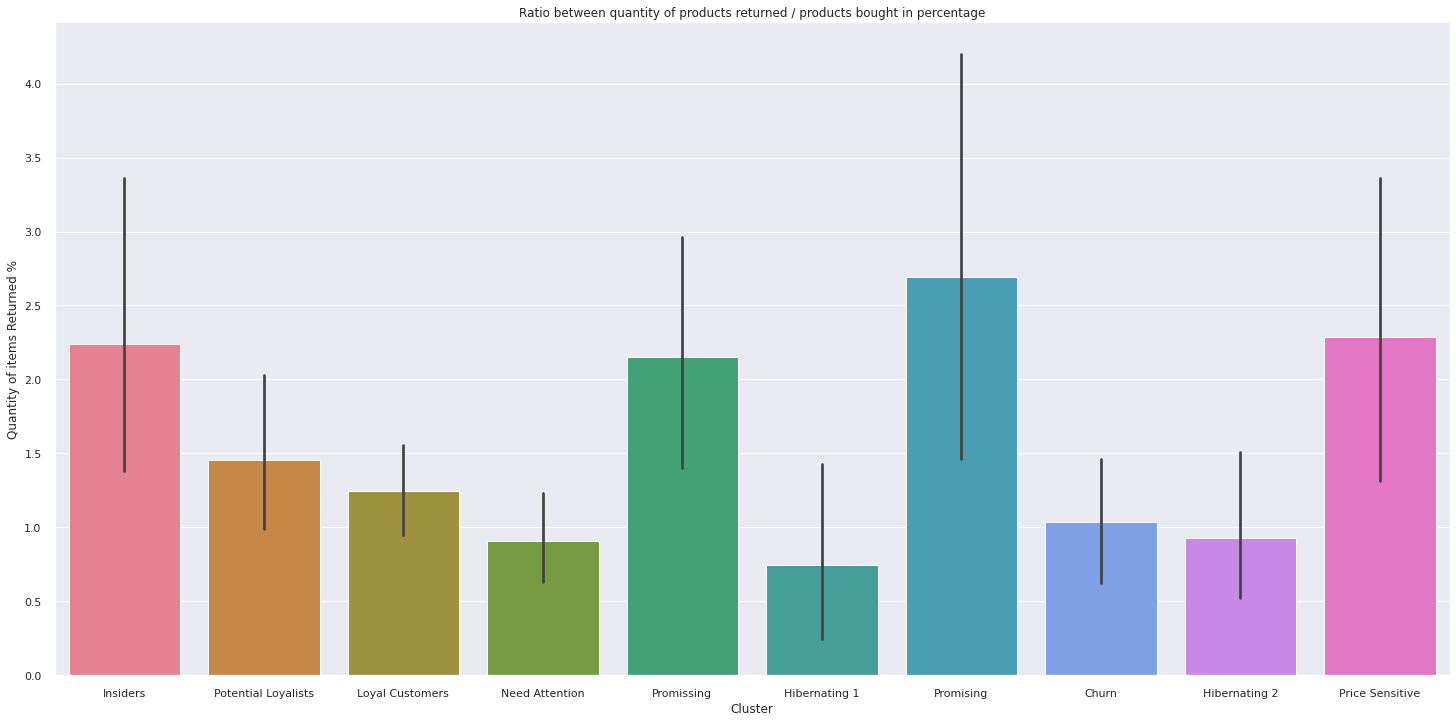

In [86]:
# since in absolute terms Insiders have the highest quantities of returns, we'll do a comparative analysis to put everyone on the same scale

df_aux4 = df_result.copy()
df_aux4['qty_return_rate_%'] = -df_aux4['qty_returned'] / df_aux4['qty_items'] * 100
df_aux4['returns_revenue_ratio'] = -df_aux4['returns_revenue'] / df_aux4['revenue']

# removing customers that should not be logged (remember to remove this in the future)
df_aux4 = df_aux4.loc[ (df_aux4['qty_return_rate_%'] <= 100) & (df_aux4['returns_revenue_ratio'] <= 1) ]

# ordering clusters from highest quantities bough to lowest
qty_ordered = list(df_result.groupby('cluster_name').sum().reset_index().sort_values('qty_items', ascending = False)['cluster_name'])

sns.barplot(data = df_aux4, x = 'cluster_name', y = 'qty_return_rate_%', order = qty_ordered, palette = 'husl');
plt.title('Ratio between quantity of products returned / products bought in percentage')
plt.ylabel('Quantity of items Returned %')
plt.xlabel('Cluster');

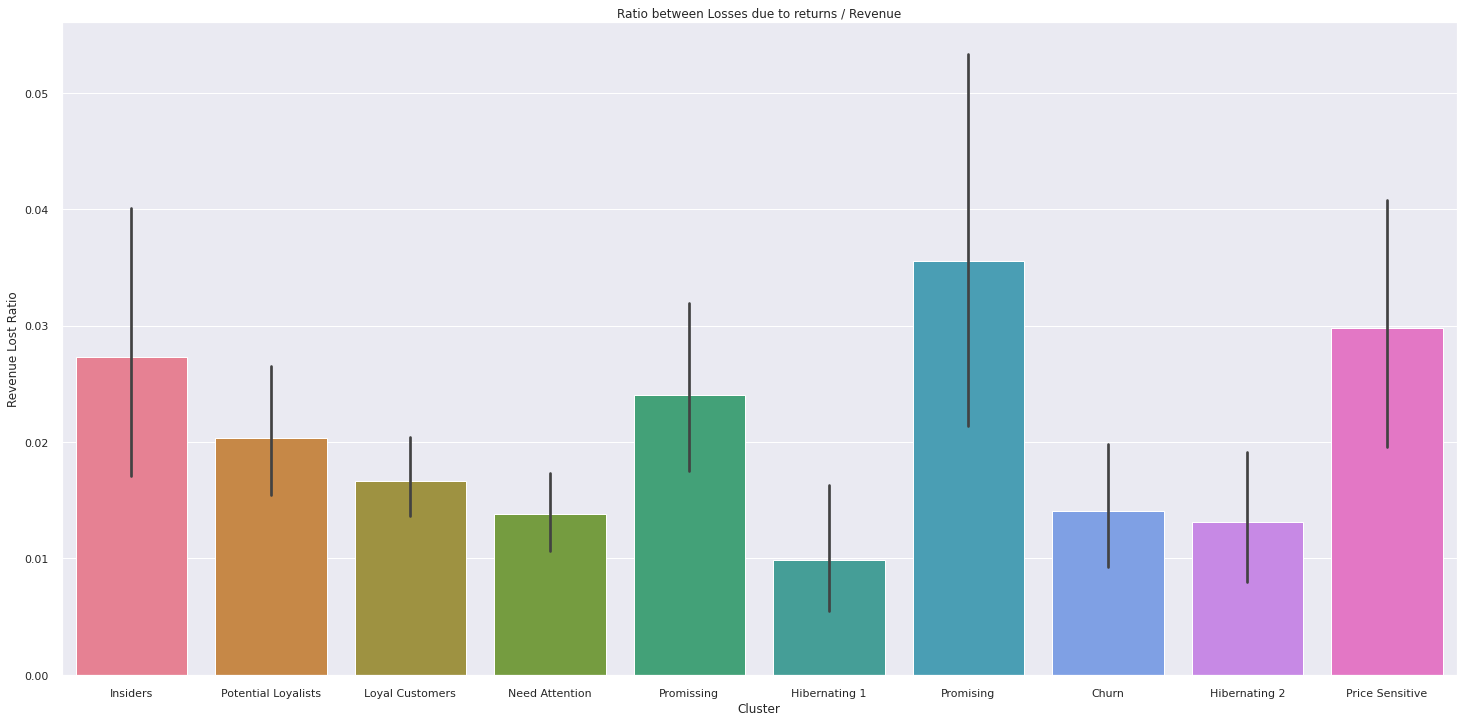

In [87]:
sns.barplot(data = df_aux4, x = 'cluster_name', y = 'returns_revenue_ratio', order = qty_ordered, palette = 'husl');
plt.title('Ratio between Losses due to returns / Revenue')
plt.ylabel('Revenue Lost Ratio')
plt.xlabel('Cluster');

### H3 - Customers buy 10% more on the first half of the month

**False** There is no significant difference between gross revenue on first and second halfs of the month

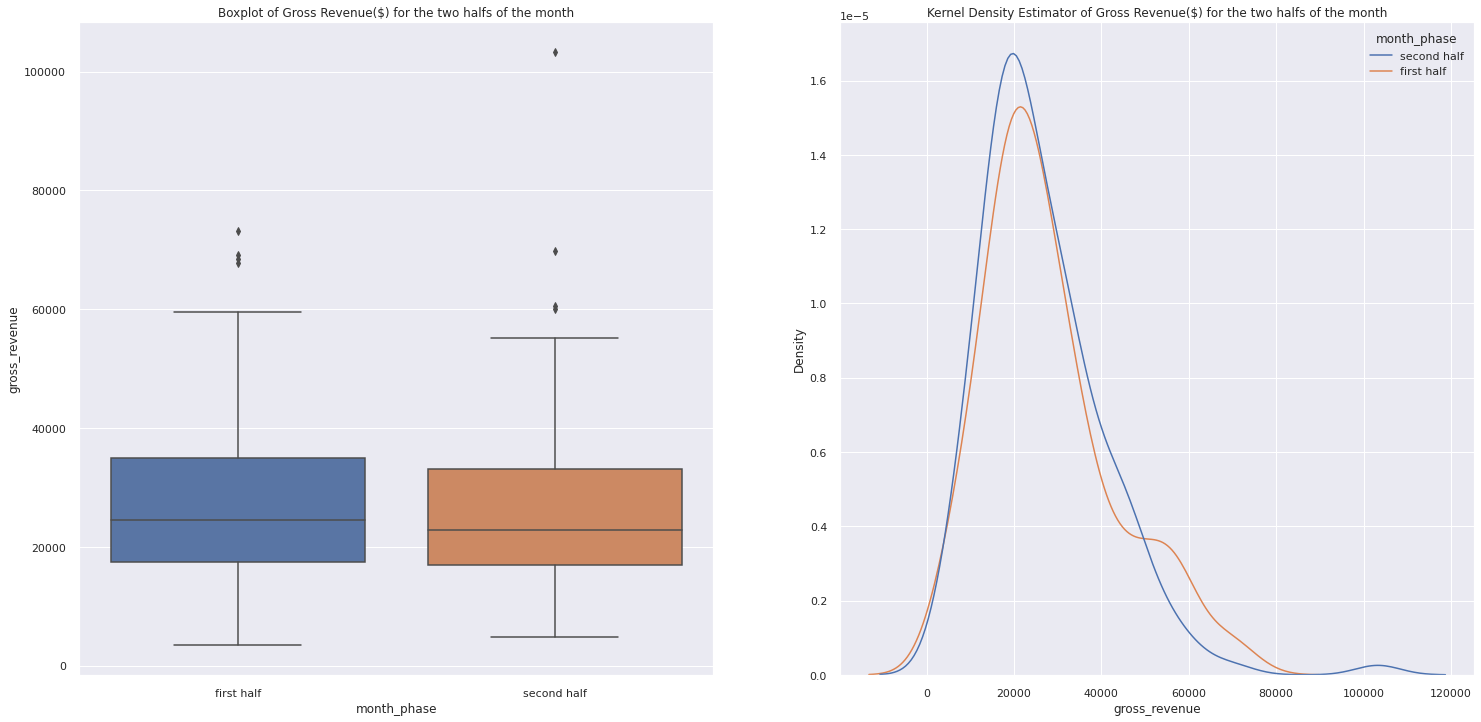

In [34]:
# date
df_date = df3.copy()
df_date['gross_revenue'] = df_date['quantity'] * df_date['unit_price']
df_date = df_date.groupby('invoice_date').sum().reset_index()
df_date['month'] = df_date['invoice_date'].dt.month
df_date['month_phase'] = df_date['invoice_date'].apply( lambda x: 'first half' if x.day <=14 else 'second half')
df_date.head()

# Ploting comparisons
fig, ax = plt.subplots(1,2)

sns.boxplot(data = df_date, y = 'gross_revenue', x = 'month_phase', ax = ax[0], order = ['first half', 'second half'] );
sns.kdeplot(data = df_date, x = 'gross_revenue', hue = 'month_phase' , ax = ax[1] );
ax[0].set_title('Boxplot of Gross Revenue($) for the two halfs of the month')
ax[1].set_title('Kernel Density Estimator of Gross Revenue($) for the two halfs of the month')

plt.show()

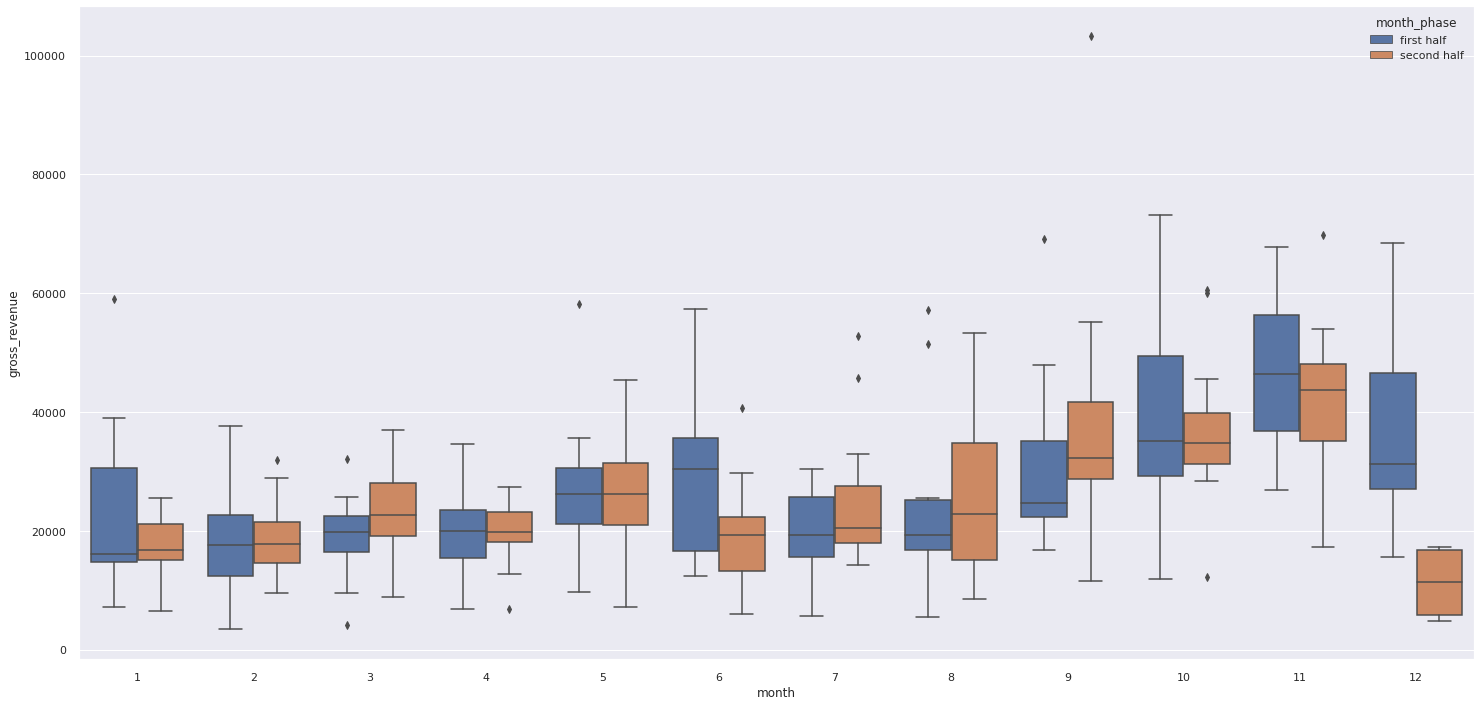

In [23]:
# ploting comparison monthly
sns.boxplot(data = df_date, x = 'month', y = 'gross_revenue', hue = 'month_phase', hue_order = ['first half', 'second half'] );

In [41]:
# defining two samples to test
first = df_date.loc[ df_date['month_phase'] == 'first half', 'gross_revenue' ]
second = df_date.loc[ df_date['month_phase'] != 'first half', 'gross_revenue' ]

print( "Mean of sample a: {:,.2f}. Median of sample a: {:,.2f}".format(first.mean(), first.median()) )
print( "Mean of sample b: {:,.2f}. Median of sample b: {:,.2f}".format(second.mean(), second.median()) )

print(st.normaltest(first))
print(st.normaltest(second))

Mean of sample a: 27,912.68. Median of sample a: 24,446.49
Mean of sample b: 26,477.52. Median of sample b: 22,810.00
NormaltestResult(statistic=18.41681031717881, pvalue=0.00010019370871206997)
NormaltestResult(statistic=62.30489657113296, pvalue=2.9557221882645036e-14)


We see that both distributions are not normal. Therefore testing the difference between means (using a t-test) is inappropriate. 

With this in mind, we'll do a Mann-Whitney U test:

In [46]:
# conducting a Mann-Whitney U test:
print(st.mannwhitneyu(first, second))

# Interestingly even with the requirement of normality not respected, the t test would yield a similar result
# print(st.ttest_ind(first, second, equal_var = False, alternative = 'two-sided'))

MannwhitneyuResult(statistic=12216.0, pvalue=0.4407692017323115)


The p-value for the test is 0.44 (>0.05). Therefore we do not reject te null hypothesis of equality of medians.

In [72]:
# feature to be tested
x = np.array(df_date['gross_revenue'])

# number of observations from group a (first half of the month)
n_a = len(first)

# number of times to repeat the test
p = 10000

# differences observed in permutation test
diffs = permutation_test(x, n_a, p, 'mean')

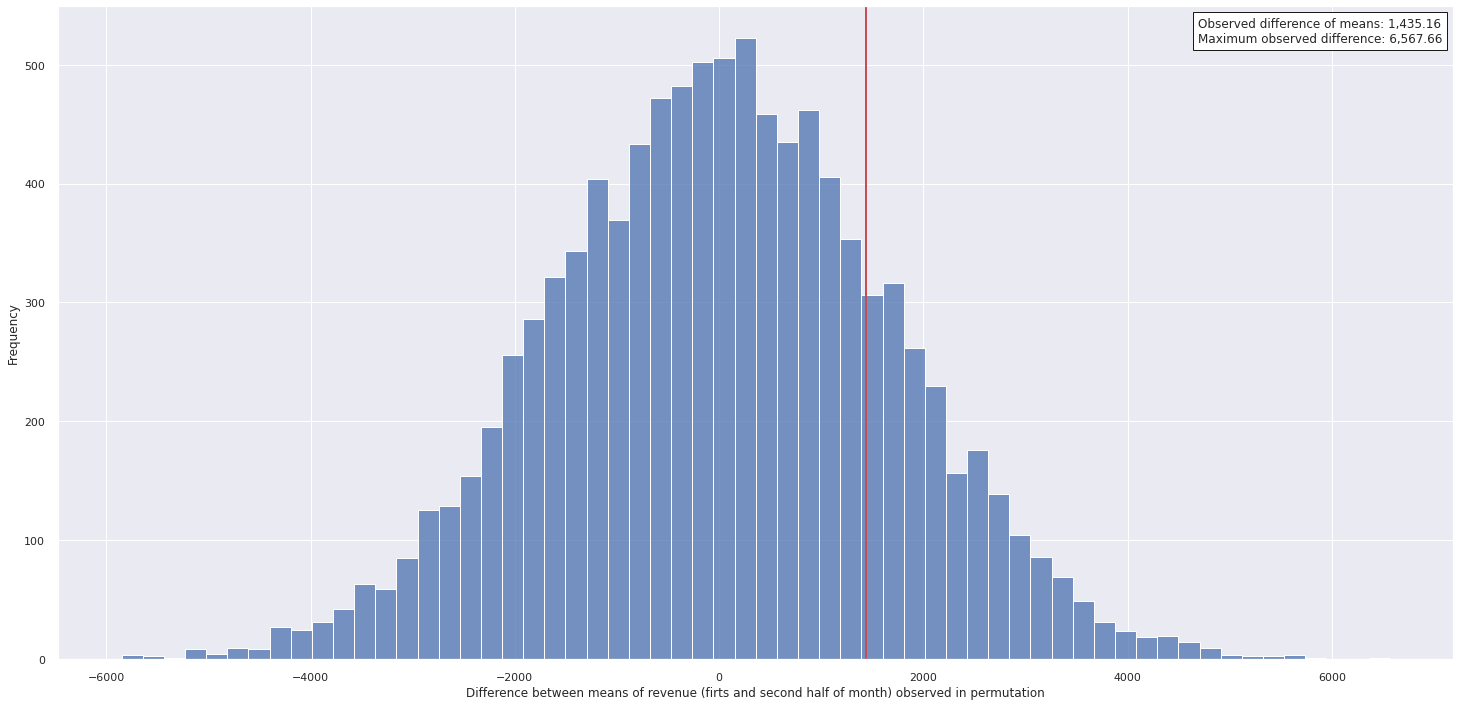

In [78]:
# calculating observed differences in data
first = df_date.loc[ df_date['month_phase'] == 'first half', 'gross_revenue' ]
second = df_date.loc[ df_date['month_phase'] != 'first half', 'gross_revenue' ]

diff_means = first.mean() - second.mean()
diff_medians = first.median() - second.median() 
max_obs = np.max(diffs)

fig, ax = plt.subplots()

sns.histplot(diffs, ax = ax);

ax.set_xlabel('Difference between means of revenue (firts and second half of month) observed in permutation')
ax.set_ylabel('Frequency');
ax.axvline(diff_means, lw = 2, color = 'r');
anchored_text = AnchoredText( "Observed difference of means: {:,.2f}\nMaximum observed difference: {:,.2f}"
                               .format(diff_means, max_obs), loc = 'upper right' )
ax.add_artist(anchored_text);

### H4 - Customers from Insiders Program are responsible for 20% of revenue
**False** These customers generate about 40% of the total revenue

In [15]:
# defining dataset with cluster names
names = {'4' : "Insiders", '1' : "Potential Loyalists", '0' : "Loyal Customers", '2' : "Promissing", '8' : "Need Attention", '6' : "Promising", '7' : "Need Attention", '5' : "Hibernating 1", '10' : "Hibernating 2", '3' : "Price Sensitive", '9' : "Churn"}

df_result['cluster_name'] = df_result['cluster'].map(names)

# summing revenue by cluster
df_agg = df_result[['cluster_name', 'revenue']].copy()
df_agg = df_agg.groupby('cluster_name').sum().reset_index()

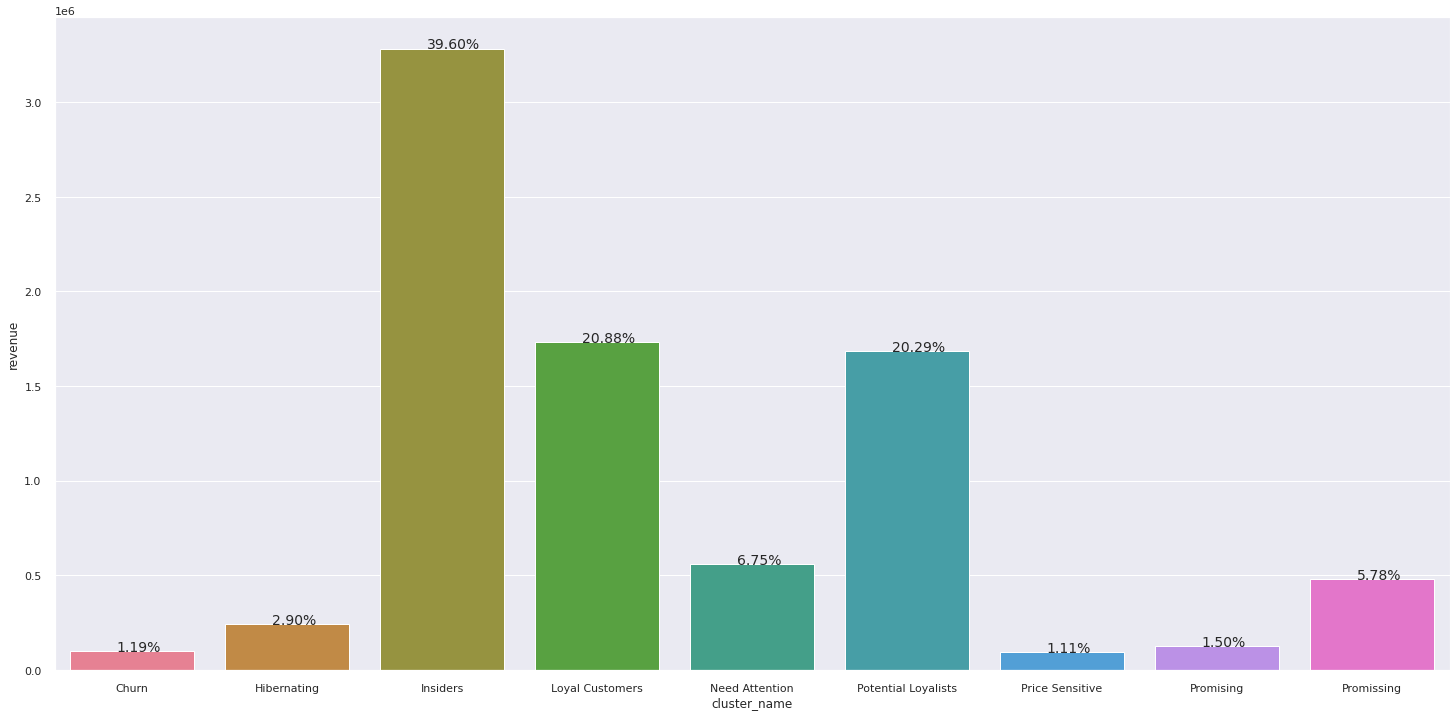

In [118]:
# ploting the results
bar = sns.barplot(data = df_agg, x = 'cluster_name', y = 'revenue', palette = 'husl' );

bar_order = list(df_agg['cluster_name'].unique())
spots = zip(bar.patches, bar_order)
for spot in spots:
    total = df_agg['revenue'].sum()
    class_total = df_agg[df_agg['cluster_name'] == spot[1]]['revenue']
    
    percent = float(class_total/total*100)

    height = spot[0].get_height()
    bar.text(spot[0].get_x()+0.3, height+5, '{:.2f}%'.format(percent), fontsize = 14 )


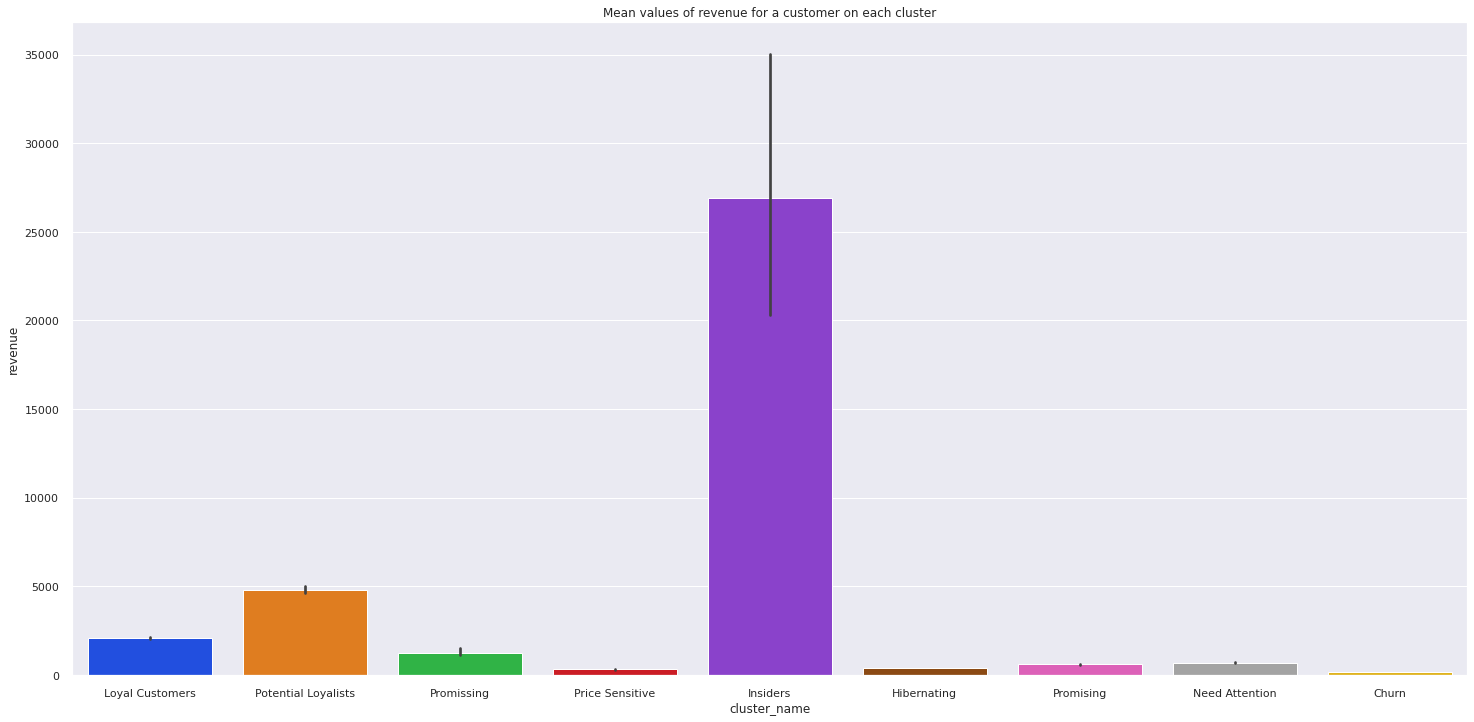

In [132]:
sns.barplot(data = df_result, x = 'cluster_name', y = 'revenue', palette = 'bright');
plt.title('Mean values of revenue for a customer on each cluster');

### H5 - Customers from Insiders Program buy 2 times more products in quantity than the average customer
**False** The average Insider Customer buys 14x more items than the average customer

Customers from Insiders Cluster buy 14.22 x more items than the average customer


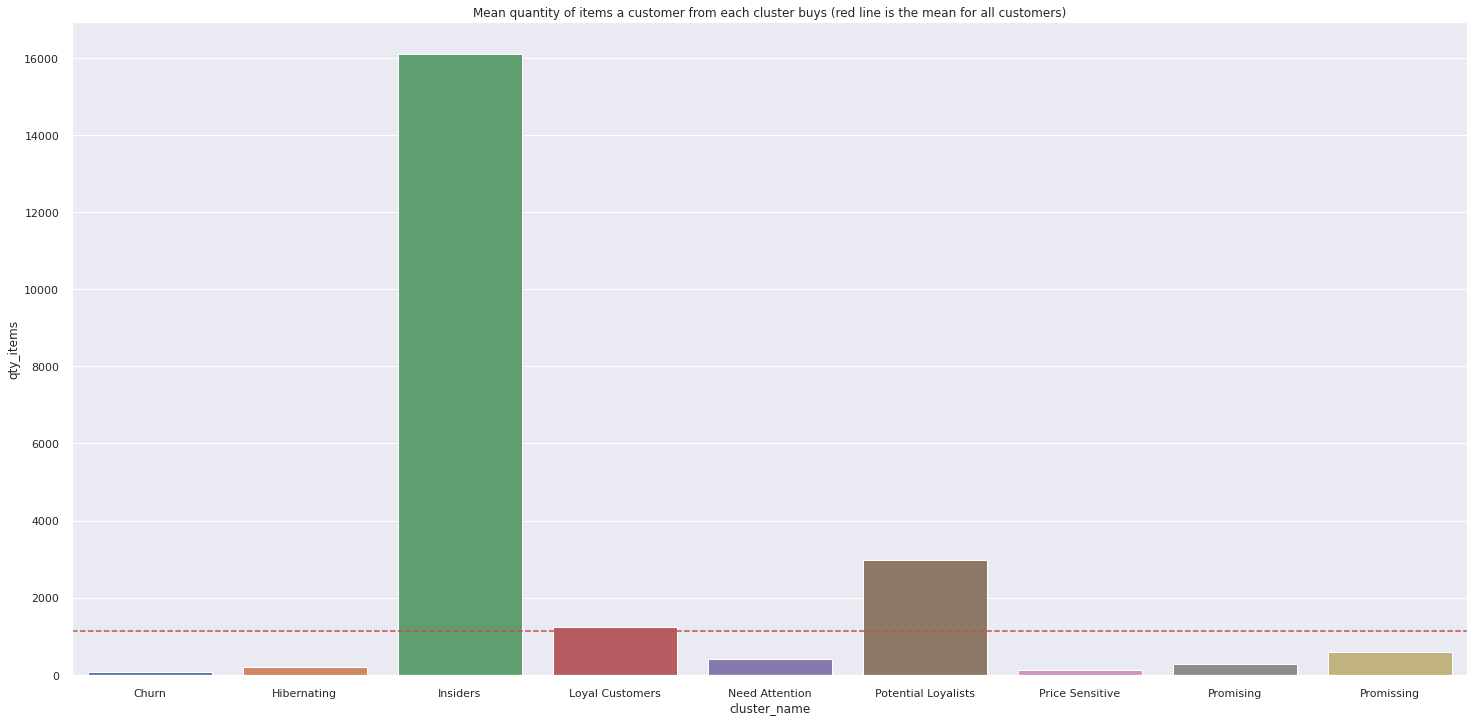

In [171]:
avg_cust_mean = df_result['qty_items'].mean()

# mean of qty by cluster
qty_by_clust = df_result[['cluster_name','qty_items']].groupby(['cluster_name']).mean().reset_index()
ins_cust_mean = qty_by_clust.loc[qty_by_clust['cluster_name'] == 'Insiders']['qty_items']

print( 'Customers from Insiders Cluster buy {:,.2f} x more items than the average customer'.format( float(ins_cust_mean/avg_cust_mean)) )

sns.barplot(data = qty_by_clust, x = 'cluster_name', y = 'qty_items');
plt.title('Mean quantity of items a customer from each cluster buys (red line is the mean for all customers)')
plt.axhline(y = avg_cust_mean, color = 'r', linestyle = '--' );

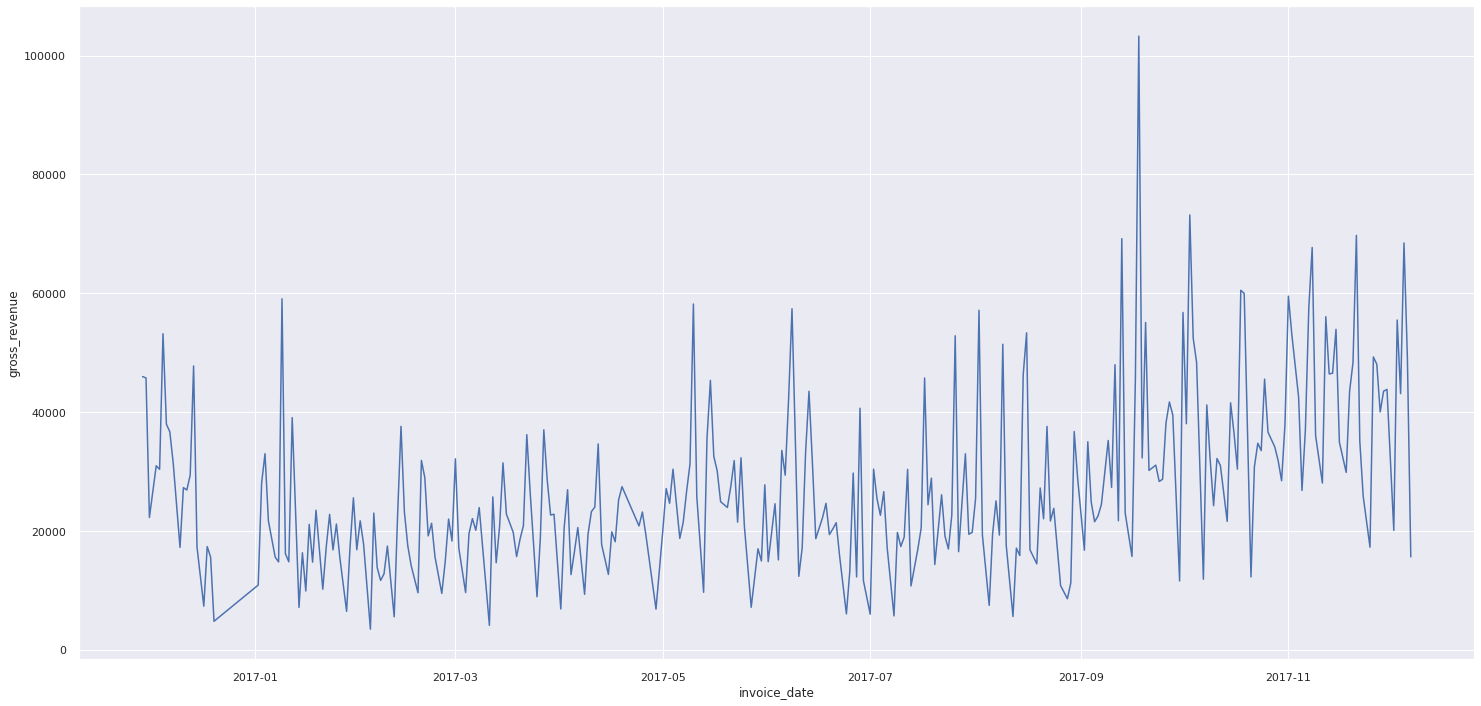

In [ ]:
# revenue over time (for consultation)
df_date = df3.copy()
df_date['gross_revenue'] = df_date['quantity'] * df_date['unit_price']
df_date = df_date.groupby('invoice_date').sum().reset_index()
df_date.head()

sns.lineplot(data = df_date, x = 'invoice_date', y = 'gross_revenue');

## 10.3. Business Questions

### 10.3.2. How many customers will be part of the group?


In [86]:
.head()

customer_id         country  recency  avg_days_bw_purchases  num_purchases  date_range  frequency  revenue  avg_ticket  qty_items  avg_basket_size  avg_unique_prods  returns_revenue  avg_return_revenue  num_returns  qty_returned  embedding_x  embedding_y cluster
0        17850  United Kingdom      373               1.000000             34           1  34.000000  5288.63  155.547941       1693        48.371429          8.735294          -102.58           -6.838667         15.0         -40.0    11.384928    -0.367669       0
1        13047  United Kingdom       57              52.833333              9         317   0.028391  3089.10  343.233333       1355        84.687500         19.000000          -143.49           -6.238696         23.0         -35.0    11.623067     1.610966       0
2        12583          France        3              26.500000             15         371   0.040431  6629.34  441.956000       4978       292.823529         15.466667           -76.04          -25.346667          3.0         -50.0    10.325433    -7.799127       1
3        13748  United Kingdom       96              92.666667              5         278   0.017986   948.25  189.650000        439        87.800000          5.600000             0.00            0.000000          0.0           0.0    10.479339    11.446996       2
4        15100  United Kingdom      334              20.000000              3          40   0.075000   635.10  211.700000         58         9.666667          1.000000          -240.90          -80.300000          3.0         -22.0    -7.344989    11.388304       3

### 10.3.2. What are the main characteristics of these customers?

### 10.3.3. What percentage of revenue contribution comes from Insiders?


### 10.3.4. What is the revenue expectation of this group for the coming months?


### 10.3.5. What are the conditions for a person to be eligible for Insiders?


### 10.3.6. What are the conditions for a person to be removed from Insiders?


### 10.3.7. Are there any guarantees that the Insiders Program customers' have indeed higher value than the rest of the customer base?


### 10.3.8. What actions can the marketing team take to increase revenue?

## 10.4. Possible Insights

Possible Insights:
- Type of product Insiders Program customers buy
- Top products Insiders Program customers buy
- Products bought together

# 11 Model Deployment

### TODO
- Deploy model
- Organize stuff and results